# Sieci neuronowe

## Wstęp

Celem laboratorium jest zapoznanie się z podstawami sieci neuronowych oraz uczeniem głębokim (*deep learning*). Zapoznasz się na nim z następującymi tematami:
- treningiem prostych sieci neuronowych, w szczególności z:
  - regresją liniową w sieciach neuronowych
  - optymalizacją funkcji kosztu
  - algorytmem spadku wzdłuż gradientu
  - siecią typu Multilayer Perceptron (MLP)
- frameworkiem PyTorch, w szczególności z:
  - ładowaniem danych
  - preprocessingiem danych
  - pisaniem pętli treningowej i walidacyjnej
  - walidacją modeli
- architekturą i hiperaprametrami sieci MLP, w szczególności z:
  - warstwami gęstymi (w pełni połączonymi)
  - funkcjami aktywacji
  - regularyzacją: L2, dropout

## Wykorzystywane biblioteki

Zaczniemy od pisania ręcznie prostych sieci w bibliotece Numpy, służącej do obliczeń numerycznych na CPU. Później przejdziemy do wykorzystywania frameworka PyTorch, służącego do obliczeń numerycznych na CPU, GPU oraz automatycznego różniczkowania, wykorzystywanego głównie do treningu sieci neuronowych.

Wykorzystamy PyTorcha ze względu na popularność, łatwość instalacji i użycia, oraz dużą kontrolę nad niskopoziomowymi aspektami budowy i treningu sieci neuronowych. Framework ten został stworzony do zastosowań badawczych i naukowych, ale ze względu na wygodę użycia stał się bardzo popularny także w przemyśle. W szczególności całkowicie zdominował przetwarzanie języka naturalnego (NLP) oraz uczenie na grafach.

Pierwszy duży framework do deep learningu, oraz obecnie najpopularniejszy, to TensorFlow, wraz z wysokopoziomową nakładką Keras. Są jednak szanse, że Google (autorzy) będzie go powoli porzucać na rzecz ich nowego frameworka JAX ([dyskusja](https://www.reddit.com/r/MachineLearning/comments/vfl57t/d_google_quietly_moving_its_products_from/), [artykuł Business Insidera](https://www.businessinsider.com/facebook-pytorch-beat-google-tensorflow-jax-meta-ai-2022-6?IR=T)), który jest bardzo świeżym, ale ciekawym narzędziem.

Trzecia, ale znacznie mniej popularna od powyższych opcja to Apache MXNet.

## Konfiguracja własnego komputera

Jeżeli korzystasz z własnego komputera, to musisz zainstalować trochę więcej bibliotek (Google Colab ma je już zainstalowane).

Jeżeli nie masz GPU lub nie chcesz z niego korzystać, to wystarczy znaleźć odpowiednią komendę CPU [na stronie PyTorcha](https://pytorch.org/get-started/locally/). Dla Anacondy odpowiednia komenda została podana poniżej, dla pip'a znajdź ją na stronie.

Jeżeli chcesz korzystać ze wsparcia GPU (na tym laboratorium nie będzie potrzebne, na kolejnych może przyspieszyć nieco obliczenia), to musi być to odpowiednio nowa karta NVidii, mająca CUDA compatibility ([lista](https://developer.nvidia.com/cuda-gpus)). Poza PyTorchem będzie potrzebne narzędzie NVidia CUDA w wersji 11.6 lub 11.7. Instalacja na Windowsie jest bardzo prosta (wystarczy ściągnąć plik EXE i zainstalować jak każdy inny program). Instalacja na Linuxie jest trudna i można względnie łatwo zepsuć sobie system, ale jeżeli chcesz spróbować, to [ten tutorial](https://www.youtube.com/results?search_query=nvidia+cuda+install+ubuntu+20.04) jest bardzo dobry.

In [1]:
# for conda users
#!conda install -y pytorch torchvision -c pytorch -c conda-forge

## Wprowadzenie

Zanim zaczniemy naszą przygodę z sieciami neuronowymi, przyjrzyjmy się prostemu przykładowi regresji liniowej na syntetycznych danych:

In [2]:
from typing import Tuple, Dict

import numpy as np
import matplotlib.pyplot as plt

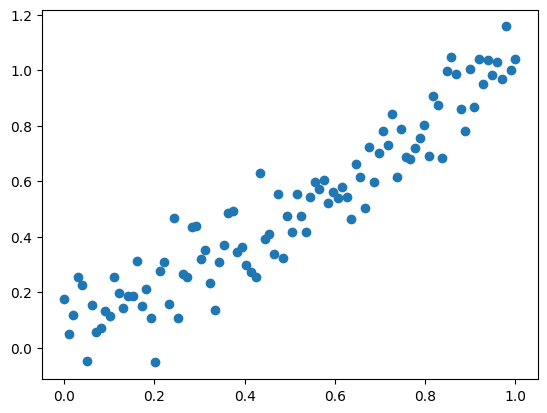

In [3]:
np.random.seed(0)

x = np.linspace(0, 1, 100)
y = x + np.random.normal(scale=0.1, size=x.shape)

plt.scatter(x, y)

W przeciwieństwie do laboratorium 1, tym razem będziemy chcieli rozwiązać ten problem własnoręcznie, bez użycia wysokopoziomowego interfejsu Scikit-learn'a. W tym celu musimy sobie przypomnieć sformułowanie naszego **problemu optymalizacyjnego (optimization problem)**.

W przypadku prostej regresji liniowej (1 zmienna) mamy model postaci $\hat{y} = \alpha x + \beta$, z dwoma parametrami, których będziemy się uczyć. Miarą niedopasowania modelu o danych parametrach jest **funkcja kosztu (cost function)**, nazywana też funkcją celu. Najczęściej używa się **błędu średniokwadratowego (mean squared error, MSE)**:
$$\large
MSE = \frac{1}{N} \sum_{i}^{N} (y - \hat{y})^2
$$

Od jakich $\alpha$ i $\beta$ zacząć? W najprostszym wypadku wystarczy po prostu je wylosować jako niewielkie liczby zmiennoprzecinkowe.

#### Zadanie 1 (0.5 punkt)

Uzupełnij kod funkcji `mse`, obliczającej błąd średniokwadratowy. Wykorzystaj Numpy'a w celu wektoryzacji obliczeń dla wydajności.

In [4]:
def mse(y: np.ndarray, y_hat: np.ndarray) -> float:
    return np.linalg.norm(y-y_hat)
    # implement me!
    # your_code


MSE: 3.647


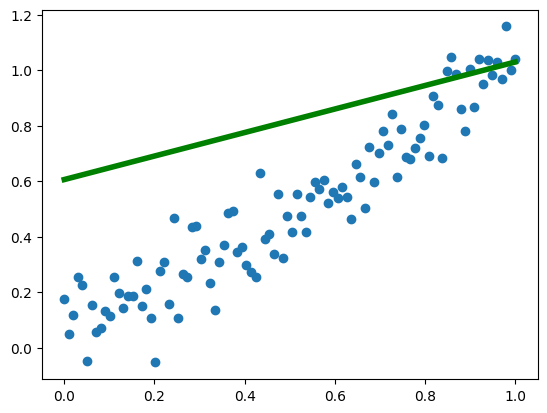

In [5]:
a = np.random.rand()
b = np.random.rand()
print(f"MSE: {mse(y, a * x + b):.3f}")

plt.scatter(x, y)
plt.plot(x, a * x + b, color="g", linewidth=4)

Losowe parametry radzą sobie nie najlepiej. Jak lepiej dopasować naszą prostą do danych? Zawsze możemy starać się wyprowadzić rozwiązanie analitycznie, i w tym wypadku nawet nam się uda. Jest to jednak szczególny i dość rzadki przypadek, a w szczególności nie będzie to możliwe w większych sieciach neuronowych.

Potrzebna nam będzie **metoda optymalizacji (optimization method)**, dającą wartości parametrów minimalizujące dowolną różniczkowalną funkcję kosztu. Zdecydowanie najpopularniejszy jest tutaj **spadek wzdłuż gradientu (gradient descent)**.

Metoda ta wywodzi się z prostych obserwacji, które tutaj przedstawimy. Bardziej szczegółowe rozwinięcie dla zainteresowanych: [sekcja 4.3 "Deep Learning Book"](https://www.deeplearningbook.org/contents/numerical.html), [ten praktyczny kurs](https://cs231n.github.io/optimization-1/), [analiza oryginalnej publikacji Cauchy'ego](https://www.math.uni-bielefeld.de/documenta/vol-ismp/40_lemarechal-claude.pdf) (oryginał w języku francuskim).

Pochodna jest dokładnie równa granicy funkcji. Dla małego $\epsilon$ można ją przybliżyć jako:
$$\large
\frac{f(x)}{dx} \approx \frac{f(x+\epsilon) - f(x)}{\epsilon}
$$

Przyglądając się temu równaniu widzimy, że: 
* dla funkcji rosnącej ($f(x+\epsilon) > f(x)$) wyrażenie $\frac{f(x)}{dx}$ będzie miało znak dodatni 
* dla funkcji malejącej ($f(x+\epsilon) < f(x)$) wyrażenie $\frac{f(x)}{dx}$ będzie miało znak ujemny 

Widzimy więc, że potrafimy wskazać kierunek zmniejszenia wartości funkcji, patrząc na znak pochodnej. Zaobserwowano także, że amplituda wartości w $\frac{f(x)}{dx}$ jest tym większa, im dalej jesteśmy od minimum (maximum). Pochodna wyznacza więc, w jakim kierunku funkcja najszybciej rośnie, zaś przeciwny zwrot to ten, w którym funkcja najszybciej spada.

Stosując powyższe do optymalizacji, mamy:
$$\large
x_{t+1} = x_{t} -  \alpha * \frac{f(x)}{dx}
$$

$\alpha$ to niewielka wartość (rzędu zwykle $10^{-5}$ - $10^{-2}$), wprowadzona, aby trzymać się założenia o małej zmianie parametrów ($\epsilon$). Nazywa się ją **stałą uczącą (learning rate)** i jest zwykle najważniejszym hiperparametrem podczas nauki sieci.

Metoda ta zakłada, że używamy całego zbioru danych do aktualizacji parametrów w każdym kroku, co nazywa się po prostu GD (od *gradient descent*) albo *full batch GD*. Wtedy każdy krok optymalizacji nazywa się **epoką (epoch)**.

Im większa stała ucząca, tym większe nasze kroki podczas minimalizacji. Możemy więc uczyć szybciej, ale istnieje ryzyko, że będziemy "przeskakiwać" minima. Mniejsza stała ucząca to wolniejszy, ale dokładniejszy trening. Jednak nie zawsze ona pozwala osiągnąć lepsze wyniki, bo może okazać się, że utkniemy w minimum lokalnym. Można także zmieniać stałą uczącą podczas treningu, co nazywa się **learning rate scheduling (LR scheduling)**. Obrazowo:

![learning_rate](http://www.bdhammel.com/assets/learning-rate/lr-types.png)

![interactive LR](http://cdn-images-1.medium.com/max/640/1*eeIvlwkMNG1wSmj3FR6M2g.gif)

Policzmy więc pochodną dla naszej funkcji kosztu MSE. Pochodną liczymy po parametrach naszego modelu, bo to właśnie ich chcemy dopasować tak, żeby koszt był jak najmniejszy:

$$\large
MSE = \frac{1}{N} \sum_{i}^{N} (y_i - \hat{y_i})^2
$$

W powyższym wzorze tylko $y_i$ jest zależny od $a$ oraz $b$. Możemy wykorzystać tu regułę łańcuchową (*chain rule*) i policzyć pochodne po naszych parametrach w sposób następujący:

$$\large
\frac{\text{d} MSE}{\text{d} a} = \frac{1}{N} \sum_{i}^{N} \frac{\text{d} (y_i - \hat{y_i})^2}{\text{d} \hat{y_i}} \frac{\text{d} \hat{y_i}}{\text{d} a}
$$

$$\large
\frac{\text{d} MSE}{\text{d} b} = \frac{1}{N} \sum_{i}^{N} \frac{\text{d} (y_i - \hat{y_i})^2}{\text{d} \hat{y_i}} \frac{\text{d} \hat{y_i}}{\text{d} b}
$$

Policzmy te pochodne po kolei:

$$\large
\frac{\text{d} (y_i - \hat{y_i})^2}{\text{d} \hat{y_i}} = -2 \cdot (y_i - \hat{y_i})
$$

$$\large
\frac{\text{d} \hat{y_i}}{\text{d} a} = x_i
$$

$$\large
\frac{\text{d} \hat{y_i}}{\text{d} b} = 1
$$

Łącząc powyższe wyniki dostaniemy:

$$\large
\frac{\text{d} MSE}{\text{d} a} = \frac{-2}{N} \sum_{i}^{N} (y_i - \hat{y_i}) \cdot {x_i}
$$

$$\large
\frac{\text{d} MSE}{\text{d} b} = \frac{-2}{N} \sum_{i}^{N} (y_i - \hat{y_i})
$$

Aktualizacja parametrów wygląda tak:

$$\large
a' = a - \alpha * \left( \frac{-2}{N} \sum_{i=1}^N (y_i - \hat{y}_i) \cdot x_i \right)
$$
$$\large
b' = b - \alpha * \left( \frac{-2}{N} \sum_{i=1}^N (y_i - \hat{y}_i) \right)
$$

Liczymy więc pochodną funkcji kosztu, a potem za pomocą reguły łańcuchowej "cofamy się", dochodząc do tego, jak każdy z parametrów wpływa na błąd i w jaki sposób powinniśmy go zmienić. Nazywa się to **propagacją wsteczną (backpropagation)** i jest podstawowym mechanizmem umożliwiającym naukę sieci neuronowych za pomocą spadku wzdłuż gradientu. Więcej możesz o tym przeczytać [tutaj](https://cs231n.github.io/optimization-2/).


#### Zadanie 2 (1.0 punkt)

Zaimplementuj funkcję realizującą jedną epokę treningową. Zauważ, że `x` oraz `y` są wektorami. Oblicz predykcję przy aktualnych parametrach oraz zaktualizuj je zgodnie z powyższymi wzorami.

In [6]:
def optimize(
    x: np.ndarray, y: np.ndarray, a: float, b: float, learning_rate: float = 0.1
):
    y_hat = a * x + b
    errors = y - y_hat
    a += 2 * learning_rate * np.sum(errors*x) / y.size
    b += 2 * learning_rate * np.sum(errors) / y.size
    # implement me!
    # your_code
    return a, b


In [7]:
for i in range(1000):
    loss = mse(y, a * x + b)
    a, b = optimize(x, y, a, b)
    if i % 100 == 0:
        print(f"step {i} loss: ", loss)

print("final loss:", loss)

step 0 loss:  3.6472251361878225
step 100 loss:  1.1257529826088704
step 200 loss:  1.0127760631481086
step 300 loss:  1.0047290059979308
step 400 loss:  1.0041859595159215
step 500 loss:  1.004149458147209
step 600 loss:  1.004147005334364
step 700 loss:  1.0041468405136404
step 800 loss:  1.0041468294382587
step 900 loss:  1.0041468286940316
final loss: 1.0041468286441209


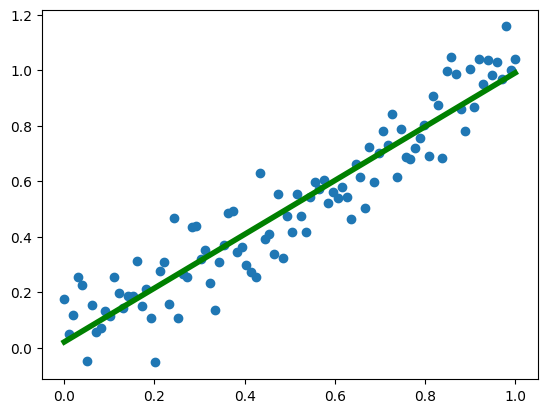

In [8]:
plt.scatter(x, y)
plt.plot(x, a * x + b, color="g", linewidth=4)

Udało ci się wytrenować swoją pierwszą sieć neuronową. Czemu? Otóż neuron to po prostu wektor parametrów, a zwykle robimy iloczyn skalarny tych parametrów z wejściem. Dodatkowo na wyjście nakłada się **funkcję aktywacji (activation function)**, która przekształca wyjście. Tutaj takiej nie było, a właściwie była to po prostu funkcja identyczności.

Oczywiście w praktyce korzystamy z odpowiedniego frameworka, który w szczególności:
- ułatwia budowanie sieci, np. ma gotowe klasy dla warstw neuronów
- ma zaimplementowane funkcje kosztu oraz ich pochodne
- sam różniczkuje ze względu na odpowiednie parametry i aktualizuje je odpowiednio podczas treningu


## Wprowadzenie do PyTorcha

PyTorch to w gruncie rzeczy narzędzie do algebry liniowej z [automatycznym rożniczkowaniem](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html), z możliwością przyspieszenia obliczeń z pomocą GPU. Na tych fundamentach zbudowany jest pełny framework do uczenia głębokiego. Można spotkać się ze stwierdzenie, że PyTorch to NumPy + GPU + opcjonalne różniczkowanie, co jest całkiem celne. Plus można łatwo debugować printem :)

PyTorch używa dynamicznego grafu obliczeń, który sami definiujemy w kodzie. Takie podejście jest bardzo wygodne, elastyczne i pozwala na łatwe eksperymentowanie. Odbywa się to potencjalnie kosztem wydajności, ponieważ pozostawia kwestię optymalizacji programiście. Więcej na ten temat dla zainteresowanych na końcu laboratorium.

Samo API PyTorcha bardzo przypomina Numpy'a, a podstawowym obiektem jest `Tensor`, klasa reprezentująca tensory dowolnego wymiaru. Dodatkowo niektóre tensory będą miały automatycznie obliczony gradient. Co ważne, tensor jest na pewnym urządzeniu, CPU lub GPU, a przenosić między nimi trzeba explicite.

Najważniejsze moduły:
- `torch` - podstawowe klasy oraz funkcje, np. `Tensor`, `from_numpy()`
- `torch.nn` - klasy związane z sieciami neuronowymi, np. `Linear`, `Sigmoid`
- `torch.optim` - wszystko związane z optymalizacją, głównie spadkiem wzdłuż gradientu

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

In [10]:
ones = torch.ones(10)
noise = torch.ones(10) * torch.rand(10)

# elementwise sum
print(ones + noise)

# elementwise multiplication
print(ones * noise)

# dot product
print(ones @ noise)

tensor([1.6027, 1.5283, 1.3901, 1.9576, 1.7786, 1.5628, 1.2439, 1.4743, 1.4467,
        1.5090])
tensor([0.6027, 0.5283, 0.3901, 0.9576, 0.7786, 0.5628, 0.2439, 0.4743, 0.4467,
        0.5090])
tensor(5.4941)


In [11]:
# beware - shares memory with original Numpy array!
# very fast, but modifications are visible to original variable
x = torch.from_numpy(x)
y = torch.from_numpy(y)

Jeżeli dla stworzonych przez nas tensorów chcemy śledzić operacje i obliczać gradient, to musimy oznaczyć `requires_grad=True`.

In [12]:
a = torch.rand(1, requires_grad=True)
b = torch.rand(1, requires_grad=True)
a, b

(tensor([0.7178], requires_grad=True), tensor([0.4949], requires_grad=True))

PyTorch zawiera większość powszechnie używanych funkcji kosztu, np. MSE. Mogą być one używane na 2 sposoby, z czego pierwszy jest popularniejszy:
- jako klasy wywoływalne z modułu `torch.nn`
- jako funkcje z modułu `torch.nn.functional`

Po wykonaniu poniższego kodu widzimy, że zwraca on nam tensor z dodatkowymi atrybutami. Co ważne, jest to skalar (0-wymiarowy tensor), bo potrzebujemy zwyczajnej liczby do obliczania propagacji wstecznych (pochodnych czątkowych).

In [13]:
mse = nn.MSELoss()
mse(y, a * x + b)

tensor(0.1365, dtype=torch.float64, grad_fn=<MseLossBackward0>)

Atrybutu `grad_fn` nie używamy wprost, bo korzysta z niego w środku PyTorch, ale widać, że tensor jest "świadomy", że liczy się na nim pochodną. Możemy natomiast skorzystać z atrybutu `grad`, który zawiera faktyczny gradient. Zanim go jednak dostaniemy, to trzeba powiedzieć PyTorchowi, żeby policzył gradient. Służy do tego metoda `.backward()`, wywoływana na obiekcie zwracanym przez funkcję kosztu.

In [14]:
loss = mse(y, a * x + b)
loss.backward()

In [15]:
print(a.grad)

tensor([0.3049])


Ważne jest, że PyTorch nie liczy za każdym razem nowego gradientu, tylko dodaje go do istniejącego, czyli go akumuluje. Jest to przydatne w niektórych sieciach neuronowych, ale zazwyczaj trzeba go zerować. Jeżeli tego nie zrobimy, to dostaniemy coraz większe gradienty.

Do zerowania służy metoda `.zero_()`. W PyTorchu wszystkie metody modyfikujące tensor w miejscu mają `_` na końcu nazwy. Jest to dość niskopoziomowa operacja dla pojedynczych tensorów - zobaczymy za chwilę, jak to robić łatwiej dla całej sieci.

In [16]:
loss = mse(y, a * x + b)
loss.backward()
a.grad

tensor([0.6098])

Zobaczmy, jak wyglądałaby regresja liniowa, ale napisana w PyTorchu. Jest to oczywiście bardzo niskopoziomowa implementacja - za chwilę zobaczymy, jak to wygląda w praktyce.

In [17]:
learning_rate = 0.1
for i in range(1000):
    loss = mse(y, a * x + b)

    # compute gradients
    loss.backward()

    # update parameters
    a.data -= learning_rate * a.grad
    b.data -= learning_rate * b.grad

    # zero gradients
    a.grad.data.zero_()
    b.grad.data.zero_()

    if i % 100 == 0:
        print(f"step {i} loss: ", loss)

print("final loss:", loss)

step 0 loss:  tensor(0.1365, dtype=torch.float64, grad_fn=<MseLossBackward0>)
step 100 loss:  tensor(0.0109, dtype=torch.float64, grad_fn=<MseLossBackward0>)
step 200 loss:  tensor(0.0101, dtype=torch.float64, grad_fn=<MseLossBackward0>)
step 300 loss:  tensor(0.0101, dtype=torch.float64, grad_fn=<MseLossBackward0>)
step 400 loss:  tensor(0.0101, dtype=torch.float64, grad_fn=<MseLossBackward0>)
step 500 loss:  tensor(0.0101, dtype=torch.float64, grad_fn=<MseLossBackward0>)
step 600 loss:  tensor(0.0101, dtype=torch.float64, grad_fn=<MseLossBackward0>)
step 700 loss:  tensor(0.0101, dtype=torch.float64, grad_fn=<MseLossBackward0>)
step 800 loss:  tensor(0.0101, dtype=torch.float64, grad_fn=<MseLossBackward0>)
step 900 loss:  tensor(0.0101, dtype=torch.float64, grad_fn=<MseLossBackward0>)
final loss: tensor(0.0101, dtype=torch.float64, grad_fn=<MseLossBackward0>)


Trening modeli w PyTorchu jest dosyć schematyczny i najczęściej rozdziela się go na kilka bloków, dających razem **pętlę uczącą (training loop)**, powtarzaną w każdej epoce:
1. Forward pass - obliczenie predykcji sieci
2. Loss calculation
3. Backpropagation - obliczenie pochodnych oraz zerowanie gradientów
4. Optimalization - aktualizacja wag
5. Other - ewaluacja na zbiorze walidacyjnym, logging etc.

In [18]:
# initialization
learning_rate = 0.1
a = torch.rand(1, requires_grad=True)
b = torch.rand(1, requires_grad=True)
optimizer = torch.optim.SGD([a, b], lr=learning_rate)
best_loss = float("inf")

# training loop in each epoch
for i in range(1000):
    # forward pass
    y_hat = a * x + b

    # loss calculation
    loss = mse(y, y_hat)

    # backpropagation
    loss.backward()

    # optimization
    optimizer.step()
    optimizer.zero_grad()  # zeroes all gradients - very convenient!

    if i % 100 == 0:
        if loss < best_loss:
            best_model = (a.clone(), b.clone())
            best_loss = loss
        print(f"step {i} loss: {loss.item():.4f}")

print("final loss:", loss)

step 0 loss: 0.0900
step 100 loss: 0.0137
step 200 loss: 0.0103
step 300 loss: 0.0101
step 400 loss: 0.0101
step 500 loss: 0.0101
step 600 loss: 0.0101
step 700 loss: 0.0101
step 800 loss: 0.0101
step 900 loss: 0.0101
final loss: tensor(0.0101, dtype=torch.float64, grad_fn=<MseLossBackward0>)


Przejdziemy teraz do budowy sieci neuronowej do klasyfikacji. Typowo implementuje się ją po prostu jako sieć dla regresji, ale zwracającą tyle wyników, ile mamy klas, a potem aplikuje się na tym funkcję sigmoidalną (2 klasy) lub softmax (>2 klasy). W przypadku klasyfikacji binarnej zwraca się czasem tylko 1 wartość, przepuszczaną przez sigmoidę - wtedy wyjście z sieci to prawdopodobieństwo klasy pozytywnej.

Funkcją kosztu zwykle jest **entropia krzyżowa (cross-entropy)**, stosowana też w klasycznej regresji logistycznej. Co ważne, sieci neuronowe, nawet tak proste, uczą się szybciej i stabilniej, gdy dane na wejściu (a przynajmniej zmienne numeryczne) są **ustandaryzowane (standardized)**. Operacja ta polega na odjęciu średniej i podzieleniu przez odchylenie standardowe (tzw. *Z-score transformation*).

**Uwaga - PyTorch wymaga tensora klas będącego liczbami zmiennoprzecinkowymi!**

## Zbiór danych

Na tym laboratorium wykorzystamy zbiór [Adult Census](https://archive.ics.uci.edu/ml/datasets/adult). Dotyczy on przewidywania na podstawie danych demograficznych, czy dany człowiek zarabia powyżej 50 tysięcy dolarów rocznie, czy też mniej. Jest to cenna informacja np. przy planowaniu kampanii marketingowych. Jak możesz się domyślić, zbiór pochodzi z czasów, kiedy inflacja była dużo niższa :)

Poniżej znajduje się kod do ściągnięcia i preprocessingu zbioru. Nie musisz go dokładnie analizować.

In [19]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [20]:
import pandas as pd


columns = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education-num",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
    "native-country",
    "wage"
]

"""
age: continuous.
workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
fnlwgt: continuous.
education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
education-num: continuous.
marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
sex: Female, Male.
capital-gain: continuous.
capital-loss: continuous.
hours-per-week: continuous.
native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.
"""

df = pd.read_csv("adult.data", header=None, names=columns)
df.wage.unique()

array([' <=50K', ' >50K'], dtype=object)

In [21]:
# attribution: https://www.kaggle.com/code/royshih23/topic7-classification-in-python
df['education'].replace('Preschool', 'dropout',inplace=True)
df['education'].replace('10th', 'dropout',inplace=True)
df['education'].replace('11th', 'dropout',inplace=True)
df['education'].replace('12th', 'dropout',inplace=True)
df['education'].replace('1st-4th', 'dropout',inplace=True)
df['education'].replace('5th-6th', 'dropout',inplace=True)
df['education'].replace('7th-8th', 'dropout',inplace=True)
df['education'].replace('9th', 'dropout',inplace=True)
df['education'].replace('HS-Grad', 'HighGrad',inplace=True)
df['education'].replace('HS-grad', 'HighGrad',inplace=True)
df['education'].replace('Some-college', 'CommunityCollege',inplace=True)
df['education'].replace('Assoc-acdm', 'CommunityCollege',inplace=True)
df['education'].replace('Assoc-voc', 'CommunityCollege',inplace=True)
df['education'].replace('Bachelors', 'Bachelors',inplace=True)
df['education'].replace('Masters', 'Masters',inplace=True)
df['education'].replace('Prof-school', 'Masters',inplace=True)
df['education'].replace('Doctorate', 'Doctorate',inplace=True)

df['marital-status'].replace('Never-married', 'NotMarried',inplace=True)
df['marital-status'].replace(['Married-AF-spouse'], 'Married',inplace=True)
df['marital-status'].replace(['Married-civ-spouse'], 'Married',inplace=True)
df['marital-status'].replace(['Married-spouse-absent'], 'NotMarried',inplace=True)
df['marital-status'].replace(['Separated'], 'Separated',inplace=True)
df['marital-status'].replace(['Divorced'], 'Separated',inplace=True)
df['marital-status'].replace(['Widowed'], 'Widowed',inplace=True)

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler


X = df.copy()
y = (X.pop("wage") == ' >50K').astype(int).values

train_valid_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=train_valid_size, 
    random_state=0, 
    shuffle=True, 
    stratify=y
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, 
    test_size=train_valid_size, 
    random_state=0, 
    shuffle=True, 
    stratify=y_train
)

continuous_cols = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
continuous_X_train = X_train[continuous_cols]
categorical_X_train = X_train.loc[:, ~X_train.columns.isin(continuous_cols)]

continuous_X_valid = X_valid[continuous_cols]
categorical_X_valid = X_valid.loc[:, ~X_valid.columns.isin(continuous_cols)]

continuous_X_test = X_test[continuous_cols]
categorical_X_test = X_test.loc[:, ~X_test.columns.isin(continuous_cols)]

categorical_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
continuous_scaler = StandardScaler() #MinMaxScaler(feature_range=(-1, 1))

categorical_encoder.fit(categorical_X_train)
continuous_scaler.fit(continuous_X_train)

continuous_X_train = continuous_scaler.transform(continuous_X_train)
continuous_X_valid = continuous_scaler.transform(continuous_X_valid)
continuous_X_test = continuous_scaler.transform(continuous_X_test)

categorical_X_train = categorical_encoder.transform(categorical_X_train)
categorical_X_valid = categorical_encoder.transform(categorical_X_valid)
categorical_X_test = categorical_encoder.transform(categorical_X_test)

X_train = np.concatenate([continuous_X_train, categorical_X_train], axis=1)
X_valid = np.concatenate([continuous_X_valid, categorical_X_valid], axis=1)
X_test = np.concatenate([continuous_X_test, categorical_X_test], axis=1)

X_train.shape, y_train.shape

C:\Users\Władek\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


((20838, 108), (20838,))

Uwaga co do typów - PyTorchu wszystko w sieci neuronowej musi być typu `float32`. W szczególności trzeba uważać na konwersje z Numpy'a, który używa domyślnie typu `float64`. Może ci się przydać metoda `.float()`.

Uwaga co do kształtów wyjścia - wejścia do `nn.BCELoss` muszą być tego samego kształtu. Może ci się przydać metoda `.squeeze()` lub `.unsqueeze()`.

In [23]:
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float().unsqueeze(-1)

X_valid = torch.from_numpy(X_valid).float()
y_valid = torch.from_numpy(y_valid).float().unsqueeze(-1)

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float().unsqueeze(-1)

Podobnie jak w laboratorium 2, mamy tu do czynienia z klasyfikacją niezbalansowaną:

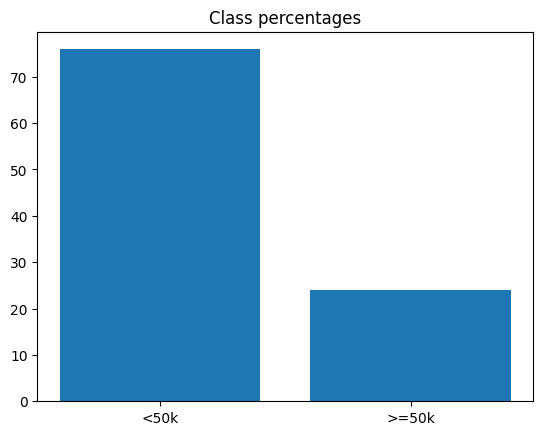

In [24]:
import matplotlib.pyplot as plt

y_pos_perc = 100 * y_train.sum().item() / len(y_train)
y_neg_perc = 100 - y_pos_perc

plt.title("Class percentages")
plt.bar(["<50k", ">=50k"], [y_neg_perc, y_pos_perc])
plt.show()

W związku z powyższym będziemy używać odpowiednich metryk, czyli AUROC, precyzji i czułości.

#### Zadanie 3 (1.0 punkt)

Zaimplementuj regresję logistyczną dla tego zbioru danych, używając PyTorcha. Dane wejściowe zostały dla ciebie przygotowane w komórkach poniżej.

Sama sieć składa się z 2 elementów:
- warstwa liniowa `nn.Linear`, przekształcająca wektor wejściowy na 1 wyjście - logit
- aktywacja sigmoidalna `nn.Sigmoid`, przekształcająca logit na prawdopodobieństwo klasy pozytywnej

Użyj binarnej entropii krzyżowej `nn.BCELoss` jako funkcji kosztu. Użyj optymalizatora SGD ze stałą uczącą `1e-3`. Trenuj przez 3000 epok. Pamiętaj, aby przekazać do optymalizatora `torch.optim.SGD` parametry sieci (metoda `.parameters()`). Dopisz logowanie kosztu raz na 100 epok.

In [25]:
X_train.size()

torch.Size([20838, 108])

In [26]:
learning_rate = 1e-3

model = torch.nn.Linear(X_train.shape[1], 1)
activation = torch.nn.Sigmoid()
loss_fn=nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
best_loss = float("inf")
optimizer.zero_grad()
model.train()
for i in range(3000):
    # forward pass
    y_hat = activation(model(X_train))

    # loss calculation
    loss = loss_fn(activation(y_train), y_hat)

    # backpropagation
    loss.backward()

    # optimization
    optimizer.step()
    optimizer.zero_grad()  # zeroes all gradients - very convenient!

    if i % 100 == 0:
        if loss < best_loss:
            best_model = (a.clone(), b.clone())
            best_loss = loss
        print(f"step {i} loss: {loss.item():.4f}")

print("final loss:", loss)
# implement me!
# your_code


step 0 loss: 0.7186
step 100 loss: 0.7163
step 200 loss: 0.7141
step 300 loss: 0.7118
step 400 loss: 0.7096
step 500 loss: 0.7074
step 600 loss: 0.7052
step 700 loss: 0.7031
step 800 loss: 0.7009
step 900 loss: 0.6988
step 1000 loss: 0.6968
step 1100 loss: 0.6947
step 1200 loss: 0.6927
step 1300 loss: 0.6908
step 1400 loss: 0.6888
step 1500 loss: 0.6869
step 1600 loss: 0.6851
step 1700 loss: 0.6833
step 1800 loss: 0.6815
step 1900 loss: 0.6798
step 2000 loss: 0.6781
step 2100 loss: 0.6765
step 2200 loss: 0.6749
step 2300 loss: 0.6733
step 2400 loss: 0.6718
step 2500 loss: 0.6703
step 2600 loss: 0.6689
step 2700 loss: 0.6675
step 2800 loss: 0.6661
step 2900 loss: 0.6648
final loss: tensor(0.6635, grad_fn=<BinaryCrossEntropyBackward0>)


Teraz trzeba sprawdzić, jak poszło naszej sieci. W PyTorchu sieć pracuje zawsze w jednym z dwóch trybów: treningowym lub ewaluacyjnym (predykcyjnym). Ten drugi wyłącza niektóre mechanizmy, które są używane tylko podczas treningu, w szczególności regularyzację dropout. Do przełączania służą metody modelu `.train()` i `.eval()`.

Dodatkowo podczas liczenia predykcji dobrze jest wyłączyć liczenie gradientów, bo nie będą potrzebne, a oszczędza to czas i pamięć. Używa się do tego menadżera kontekstu `with torch.no_grad():`.

In [27]:
from sklearn.metrics import precision_recall_curve, precision_recall_fscore_support, roc_auc_score


model.eval()
with torch.no_grad():
    y_score = activation(model(X_test))

auroc = roc_auc_score(y_test, y_score)
print(f"AUROC: {100 * auroc:.2f}%")

AUROC: 80.42%


Jest to całkiem dobry wynik, a może być jeszcze lepszy. Sprawdźmy dla pewności jeszcze inne metryki: precyzję, recall oraz F1-score. Dodatkowo narysujemy krzywą precision-recall, czyli jak zmieniają się te metryki w zależności od przyjętego progu (threshold) prawdopodobieństwa, powyżej którego przyjmujemy klasę pozytywną. Taką krzywą należy rysować na zbiorze walidacyjnym, bo później chcemy wykorzystać tę informację do doboru progu, a nie chcemy mieć wycieku danych testowych (data leakage).

Poniżej zaimplementowano także funkcję `get_optimal_threshold()`, która sprawdza, dla którego progu uzyskujemy maksymalny F1-score, i zwraca indeks oraz wartość optymalnego progu. Przyda ci się ona w dalszej części laboratorium.

In [28]:
from sklearn.metrics import PrecisionRecallDisplay


def get_optimal_threshold(
    precisions: np.array, 
    recalls: np.array, 
    thresholds: np.array
) -> Tuple[int, float]:
    
    numerator = 2 * precisions * recalls
    denominator = precisions + recalls
    f1_scores = np.divide(numerator, denominator, out=np.zeros_like(numerator), where=denominator != 0)
    
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    
    return optimal_idx, optimal_threshold


def plot_precision_recall_curve(y_true, y_pred_score) -> None:
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_pred_score)
    optimal_idx, optimal_threshold = get_optimal_threshold(precisions, recalls, thresholds)

    disp = PrecisionRecallDisplay(precisions, recalls)
    disp.plot()
    plt.title(f"Precision-recall curve (opt. thresh.: {optimal_threshold:.4f})")
    plt.axvline(recalls[optimal_idx], color="green", linestyle="-.")
    plt.axhline(precisions[optimal_idx], color="green", linestyle="-.")
    plt.show()


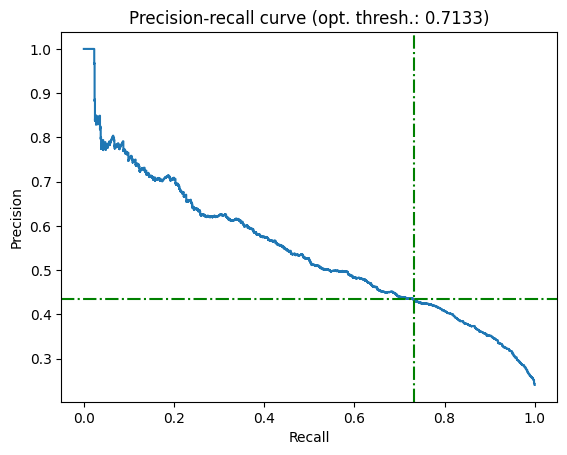

In [29]:
model.eval()
with torch.no_grad():
    y_pred_valid_score = activation(model(X_valid))

plot_precision_recall_curve(y_valid, y_pred_valid_score)

Jak widać, chociaż AUROC jest wysokie, to dla optymalnego F1-score recall nie jest zbyt wysoki, a precyzja jest już dość niska. Być może wynik uda się poprawić, używając modelu o większej pojemności - pełnej, głębokiej sieci neuronowej.

## Sieci neuronowe

Wszystko zaczęło się od inspirowanych biologią [sztucznych neuronów](https://en.wikipedia.org/wiki/Artificial_neuron), których próbowano użyć do symulacji mózgu. Naukowcy szybko odeszli od tego podejścia (sam problem modelowania okazał się też znacznie trudniejszy, niż sądzono), zamiast tego używając neuronów jako jednostek reprezentującą dowolną funkcję parametryczną $f(x, \Theta)$. Każdy neuron jest zatem bardzo elastyczny, bo jedyne wymagania to funkcja różniczkowalna, a mamy do tego wektor parametrów $\Theta$.

W praktyce najczęściej można spotkać się z kilkoma rodzinami sieci neuronowych:
1. Perceptrony wielowarstwowe (*MultiLayer Perceptron*, MLP) - najbardziej podobne do powyższego opisu, niezbędne do klasyfikacji i regresji
2. Konwolucyjne (*Convolutional Neural Networks*, CNNs) - do przetwarzania danych z zależnościami przestrzennymi, np. obrazów czy dźwięku
3. Rekurencyjne (*Recurrent Neural Networks*, RNNs) - do przetwarzania danych z zależnościami sekwencyjnymi, np. szeregi czasowe, oraz kiedyś do języka naturalnego
4. Transformacyjne (*Transformers*), oparte o mechanizm atencji (*attention*) - do przetwarzania języka naturalnego (NLP), z którego wyparły RNNs, a coraz częściej także do wszelkich innych danych, np. obrazów, dźwięku
5. Grafowe (*Graph Neural Networks*, GNNS) - do przetwarzania grafów

Na tym laboratorium skupimy się na najprostszej architekturze, czyli MLP. Jest ona powszechnie łączona z wszelkimi innymi architekturami, bo pozwala dokonywać klasyfikacji i regresji. Przykładowo, klasyfikacja obrazów to zwykle CNN + MLP, klasyfikacja tekstów to transformer + MLP, a regresja na grafach to GNN + MLP.

Dodatkowo, pomimo prostoty MLP są bardzo potężne - udowodniono, że perceptrony (ich powszechna nazwa) są [uniwersalnym aproksymatorem](https://www.sciencedirect.com/science/article/abs/pii/0893608089900208), będącym w stanie przybliżyć dowolną funkcję z odpowiednio małym błędem, zakładając wystarczającą wielkość warstw sieci. Szczególne ich wersje potrafią nawet [reprezentować drzewa decyzyjne](https://www.youtube.com/watch?v=_okxGdHM5b8).

Dla zainteresowanych polecamy [doskonałą książkę "Dive into Deep Learning", z implementacjami w PyTorchu](https://d2l.ai/chapter_multilayer-perceptrons/index.html), [klasyczną książkę "Deep Learning Book"](https://www.deeplearningbook.org/contents/mlp.html), oraz [ten filmik](https://www.youtube.com/watch?v=BFHrIxKcLjA), jeśli zastanawiałeś/-aś się, czemu używamy deep learning, a nie naprzykład (wide?) learning. (aka. czemu staramy się budować głębokie sieci, a nie płytkie za to szerokie)

### Sieci MLP

Dla przypomnienia, na wejściu mamy punkty ze zbioru treningowego, czyli $d$-wymiarowe wektory. W klasyfikacji chcemy znaleźć granicę decyzyjną, czyli krzywą, która oddzieli od siebie klasy. W wejściowej przestrzeni może być to trudne, bo chmury punktów z poszczególnych klas mogą być ze sobą dość pomieszane. Pamiętajmy też, że regresja logistyczna jest klasyfikatorem liniowym, czyli w danej przestrzeni potrafi oddzielić punkty tylko linią prostą.

Sieć MLP składa się z warstw. Każda z nich dokonuje nieliniowego przekształcenia przestrzeni (można o tym myśleć jak o składaniu przestrzeni jakąś prostą/łamaną), tak, aby w finalnej przestrzeni nasze punkty były możliwie liniowo separowalne. Wtedy ostatnia warstwa z sigmoidą będzie potrafiła je rozdzielić od siebie.

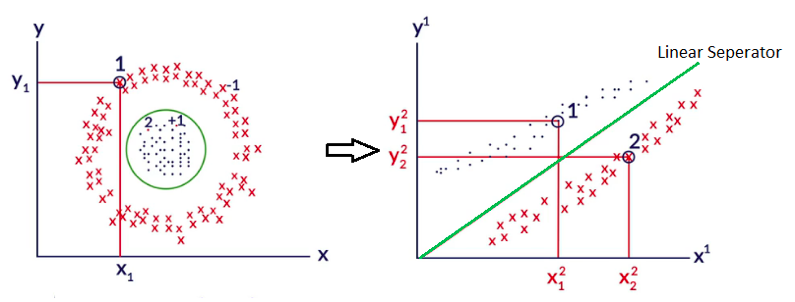

Poszczególne neurony składają się z iloczynu skalarnego wejść z wagami neuronu, oraz nieliniowej funkcji aktywacji. W PyTorchu są to osobne obiekty - `nn.Linear` oraz np. `nn.Sigmoid`. Funkcja aktywacji przyjmuje wynik iloczynu skalarnego i przekształca go, aby sprawdzić, jak mocno reaguje neuron na dane wejście. Musi być nieliniowa z dwóch powodów. Po pierwsze, tylko nieliniowe przekształcenia są na tyle potężne, żeby umożliwić liniową separację danych w ostatniej warstwie. Po drugie, liniowe przekształcenia zwyczajnie nie działają. Aby zrozumieć czemu, trzeba zobaczyć, co matematycznie oznacza sieć MLP.

![perceptron](https://www.saedsayad.com/images/Perceptron_bkp_1.png)

Zapisane matematycznie MLP to:

$\large
h_1 = f_1(x) \\
h_2 = f_2(h_1) \\
h_3 = f_3(h_2) \\
... \\
h_n = f_n(h_{n-1})
$

gdzie $x$ to wejście $f_i$ to funkcja aktywacji $i$-tej warstwy, a $h_i$ to wyjście $i$-tej warstwy, nazywane **ukrytą reprezentacją (hidden representation)**, lub *latent representation*. Nazwa bierze się z tego, że w środku sieci wyciągamy cechy i wzorce w danych, które nie są widoczne na pierwszy rzut oka na wejściu.

Załóżmy, że uczymy się na danych $x$ o jednym wymiarze (dla uproszczenia wzorów) oraz nie mamy funkcji aktywacji, czyli wykorzystujemy tak naprawdę aktywację liniową $f(x) = x$. Zobaczmy jak będą wyglądać dane przechodząc przez kolejne warstwy:

$\large
h_1 = f_1(xw_1) = xw_1 \\
h_2 = f_2(h_1w_2) = xw_1w_2 \\
... \\
h_n = f_n(h_{n-1}w_n) = xw_1w_2...w_n
$

gdzie $w_i$ to jest parametr $i$-tej warstwy sieci, $x$ to są dane (w naszym przypadku jedna liczba) wejściowa, a $h_i$ to wyjście $i$-tej warstwy.

Jak widać, taka sieć o $n$ warstwach jest równoważna sieci o jednej warstwie z parametrem $w = w_1w_2...w_n$. Wynika to z tego, że złożenie funkcji liniowych jest także funkcją liniową - patrz notatki z algebry :)

Jeżeli natomiast użyjemy nieliniowej funkcji aktywacji, często oznaczanej jako $\sigma$, to wszystko będzie działać. Co ważne, ostatnia warstwa, dająca wyjście sieci, ma zwykle inną aktywację od warstw wewnątrz sieci, bo też ma inne zadanie - zwrócić wartość dla klasyfikacji lub regresji. Na wyjściu korzysta się z funkcji liniowej (regresja), sigmoidalnej (klasyfikacja binarna) lub softmax (klasyfikacja wieloklasowa).

Wewnątrz sieci używano kiedyś sigmoidy oraz tangensa hiperbolicznego `tanh`, ale okazało się to nieefektywne przy uczeniu głębokich sieci o wielu warstwach. Nowoczesne sieci korzystają zwykle z funkcji ReLU (*rectified linear unit*), która jest zaskakująco prosta: $ReLU(x) = \max(0, x)$. Okazało się, że bardzo dobrze nadaje się do treningu nawet bardzo głębokich sieci neuronowych. Nowsze funkcje aktywacji są głównie modyfikacjami ReLU.

![relu](https://www.nomidl.com/wp-content/uploads/2022/04/image-10.png)

### MLP w PyTorchu

Warstwę neuronów w MLP nazywa się warstwą gęstą (*dense layer*) lub warstwą w pełni połączoną (*fully-connected layer*), i taki opis oznacza zwykle same neurony oraz funkcję aktywacji. PyTorch, jak już widzieliśmy, definiuje osobno transformację liniową oraz aktywację, a więc jedna warstwa składa się de facto z 2 obiektów, wywoływanych jeden po drugim. Inne frameworki, szczególnie wysokopoziomowe (np. Keras) łączą to często w jeden obiekt.

MLP składa się zatem z sekwencji obiektów, które potem wywołuje się jeden po drugim, gdzie wyjście poprzedniego to wejście kolejnego. Ale nie można tutaj używać Pythonowych list! Z perspektywy PyTorcha to wtedy niezależne obiekty i nie zostanie wtedy przekazany między nimi gradient. Trzeba tutaj skorzystać z `nn.Sequential`, aby tworzyć taki pipeline.

Rozmiary wejścia i wyjścia dla każdej warstwy trzeba w PyTorchu podawać explicite. Jest to po pierwsze edukacyjne, a po drugie często ułatwia wnioskowanie o działaniu sieci oraz jej debugowanie - mamy jasno podane, czego oczekujemy. Niektóre frameworki (np. Keras) obliczają to automatycznie.

Co ważne, ostatnia warstwa zwykle nie ma funkcji aktywacji. Wynika to z tego, że obliczanie wielu funkcji kosztu (np. entropii krzyżowej) na aktywacjach jest często niestabilne numerycznie. Z tego powodu PyTorch oferuje funkcje kosztu zawierające w środku aktywację dla ostatniej warstwy, a ich implementacje są stabilne numerycznie. Przykładowo, `nn.BCELoss` przyjmuje wejście z zaaplikowanymi już aktywacjami, ale może skutkować under/overflow, natomiast `nn.BCEWithLogitsLoss` przyjmuje wejście bez aktywacji, a w środku ma specjalną implementację łączącą binarną entropię krzyżową z aktywacją sigmoidalną. Oczywiście w związku z tym aby dokonać potem predykcji w praktyce, trzeba pamiętać o użyciu funkcji aktywacji. Często korzysta się przy tym z funkcji z modułu `torch.nn.functional`, które są w tym wypadku nieco wygodniejsze od klas wywoływalnych z `torch.nn`.

Całe sieci w PyTorchu tworzy się jako klasy dziedziczące po `nn.Module`. Co ważne, obiekty, z których tworzymy sieć, np. `nn.Linear`, także dziedziczą po tej klasie. Pozwala to na bardzo modułową budowę kodu, zgodną z zasadami OOP. W konstruktorze najpierw trzeba zawsze wywołać konstruktor rodzica - `super().__init__()`, a później tworzy się potrzebne obiekty i zapisuje jako atrybuty. Każdy atrybut dziedziczący po `nn.Module` lub `nn.Parameter` jest uważany za taki, który zawiera parametry sieci, a więc przy wywołaniu metody `parameters()` - parametry z tych atrybutów pojawią się w liście wszystkich parametrów. Musimy też zdefiniować metodę `forward()`, która przyjmuje tensor `x` i zwraca wynik. Typowo ta metoda po prostu używa obiektów zdefiniowanych w konstruktorze.


**UWAGA: nigdy w normalnych warunkach się nie woła metody `forward` ręcznie**

#### Zadanie 4 (0.5 punktu)

Uzupełnij implementację 3-warstwowej sieci MLP. Użyj rozmiarów:
* pierwsza warstwa: input_size x 256
* druga warstwa: 256 x 128
* trzecia warstwa: 128 x 1

Użyj funkcji aktywacji ReLU.

Przydatne klasy:
- `nn.Sequential`
- `nn.Linear`
- `nn.ReLU`

In [30]:
from torch import sigmoid


class MLP(nn.Module):
    def __init__(self, input_size: int):
        super().__init__()
        activation = torch.nn.ReLU()
        L1 = torch.nn.Linear(input_size, 256)
        L2 = torch.nn.Linear(256, 128)
        L3 = torch.nn.Linear(128, 1)
        self.model = nn.Sequential(
            L1,
            activation,
            L2,
            activation,
            L3
        )
        self.model.train()
        # implement me!
        # your_code

    def forward(self, x):
        return self.model(x)
        # implement me!
        # your_code

    def predict_proba(self, x):
        return sigmoid(self(x))
    
    def predict(self, x, threshold: float = 0.5):
        y_pred_score = self.predict_proba(x)
        return (y_pred_score > threshold).to(torch.int32)


In [31]:
learning_rate = 1e-3
model = MLP(input_size=X_train.shape[1])
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# note that we are using loss function with sigmoid built in
loss_fn = torch.nn.BCEWithLogitsLoss()
num_epochs = 2000
evaluation_steps = 200

for i in range(num_epochs):
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

    if i % evaluation_steps == 0:
        print(f"Epoch {i} train loss: {loss.item():.4f}")

print(f"final loss: {loss.item():.4f}")

Epoch 0 train loss: 0.7161
Epoch 200 train loss: 0.6873
Epoch 400 train loss: 0.6632
Epoch 600 train loss: 0.6424
Epoch 800 train loss: 0.6243
Epoch 1000 train loss: 0.6083
Epoch 1200 train loss: 0.5942
Epoch 1400 train loss: 0.5816
Epoch 1600 train loss: 0.5705
Epoch 1800 train loss: 0.5606
final loss: 0.5518


AUROC: 77.76%


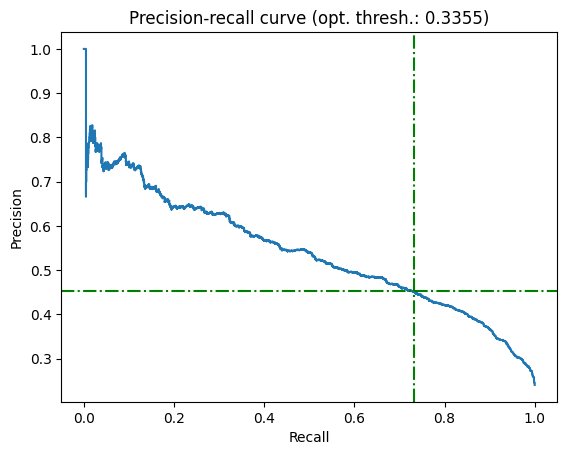

In [32]:
model.eval()
with torch.no_grad():
    # positive class probabilities
    y_pred_valid_score = model.predict_proba(X_valid)
    y_pred_test_score = model.predict_proba(X_test)

auroc = roc_auc_score(y_test, y_pred_test_score)
print(f"AUROC: {100 * auroc:.2f}%")

plot_precision_recall_curve(y_valid, y_pred_valid_score)

AUROC jest podobne, a precision i recall spadły - wypadamy wręcz gorzej od regresji liniowej! Skoro dodaliśmy więcej warstw, to może pojemność modelu jest teraz za duża i trzeba by go zregularyzować?

Sieci neuronowe bardzo łatwo przeuczają, bo są bardzo elastycznymi i pojemnymi modelami. Dlatego mają wiele różnych rodzajów regularyzacji, których używa się razem. Co ciekawe, udowodniono eksperymentalnie, że zbyt duże sieci z mocną regularyzacją działają lepiej niż mniejsze sieci, odpowiedniego rozmiaru, za to ze słabszą regularyzacją.

Pierwszy rodzaj regularyzacji to znana nam już **regularyzacja L2**, czyli penalizacja zbyt dużych wag. W kontekście sieci neuronowych nazywa się też ją czasem *weight decay*. W PyTorchu dodaje się ją jako argument do optymalizatora.

Regularyzacja specyficzna dla sieci neuronowych to **dropout**. Polega on na losowym wyłączaniu zadanego procenta neuronów podczas treningu. Pomimo prostoty okazała się niesamowicie skuteczna, szczególnie w treningu bardzo głębokich sieci. Co ważne, jest to mechanizm używany tylko podczas treningu - w trakcie predykcji za pomocą sieci wyłącza się ten mechanizm i dokonuje normalnie predykcji całą siecią. Podejście to można potraktować jak ensemble learning, podobny do lasów losowych - wyłączając losowe części sieci, w każdej iteracji trenujemy nieco inną sieć, co odpowiada uśrednianiu predykcji różnych algorytmów. Typowo stosuje się dość mocny dropout, rzędu 25-50%. W PyTorchu implementuje go warstwa `nn.Dropout`, aplikowana zazwyczaj po funkcji aktywacji.

Ostatni, a być może najważniejszy rodzaj regularyzacji to **wczesny stop (early stopping)**. W każdym kroku mocniej dostosowujemy terenową sieć do zbioru treningowego, a więc zbyt długi trening będzie skutkował przeuczeniem. W metodzie wczesnego stopu używamy wydzielonego zbioru walidacyjnego (pojedynczego, metoda holdout), sprawdzając co określoną liczbę epok wynik na tym zbiorze. Jeżeli nie uzyskamy wyniku lepszego od najlepszego dotychczas uzyskanego przez określoną liczbę epok, to przerywamy trening. Okres, przez który czekamy na uzyskanie lepszego wyniku, to cierpliwość (*patience*). Im mniejsze, tym mocniejszy jest ten rodzaj regularyzacji, ale trzeba z tym uważać, bo łatwo jest przesadzić i zbyt szybko przerywać trening. Niektóre implementacje uwzględniają tzw. *grace period*, czyli gwarantowaną minimalną liczbę epok, przez którą będziemy trenować sieć, niezależnie od wybranej cierpliwości.

Dodatkowo ryzyko przeuczenia można zmniejszyć, używając mniejszej stałej uczącej.

#### Zadanie 5 (1.5 punktu)

Zaimplementuj funkcję `evaluate_model()`, obliczającą metryki na zbiorze testowym:
- wartość funkcji kosztu (loss)
- AUROC
- optymalny próg
- F1-score przy optymalnym progu
- precyzję oraz recall dla optymalnego progu

Jeżeli podana jest wartość argumentu `threshold`, to użyj jej do zamiany prawdopodobieństw na twarde predykcje. W przeciwnym razie użyj funkcji `get_optimal_threshold` i oblicz optymalną wartość progu.

Pamiętaj o przełączeniu modelu w tryb ewaluacji oraz o wyłączeniu obliczania gradientów.

In [33]:
from typing import Optional

from sklearn.metrics import precision_score, recall_score, f1_score
from torch import sigmoid


def evaluate_model(
    model: nn.Module, 
    X: torch.Tensor, 
    y: torch.Tensor, 
    loss_fn: nn.Module,
    threshold: Optional[float]= None
) -> Dict[str, float]:
    with torch.no_grad():
        model.eval()
        y_pred_proba = model(X)
        loss = loss_fn(y_pred_proba, y)
        if threshold is not None:
            y_pred = np.where(y_pred_proba>threshold,1,0)
        else:
            precisions, recalls, thresholds = precision_recall_curve(y, y_pred_proba)
            optimal_idx, threshold = get_optimal_threshold(precisions, recalls, thresholds)
            print(f"optimal threshold: {threshold:.4f}")
            y_pred = np.where(y_pred_proba>threshold,1,0)
        auroc = roc_auc_score(y, y_pred_proba)
        precission = precision_score(y, y_pred)
        recall = recall_score(y, y_pred)
        f1 = f1_score(y, y_pred)
        return {
            'loss':loss,
            'AUROC':auroc,
            'F1-score':f1,
            'precision':precission,
            'recall':recall,
            'threshold':threshold,
        }
    
    
    # implement me!
    # your_code
    


#### Zadanie 6 (0.5 punktu)

Zaimplementuj 3-warstwową sieć MLP z dropout (50%). Rozmiary warstw ukrytych mają wynosić 256 i 128.

In [34]:
class RegularizedMLP(nn.Module):
    def __init__(self, input_size: int, dropout_p: float = 0.5):
        super().__init__()
        activation = torch.nn.ReLU()
        dropout = torch.nn.Dropout(dropout_p, inplace=False)
        L1 = torch.nn.Linear(input_size, 256)
        L2 = torch.nn.Linear(256, 128)
        L3 = torch.nn.Linear(128, 1)
        self.model = nn.Sequential(
            L1,
            activation,
            dropout,
            L2,
            activation,
            dropout,
            L3
        )
        self.model.train()
        # implement me!
        # your_code
    
    def forward(self, x):
        return self.model(x)

    def predict_proba(self, x):
        return sigmoid(self(x))
    
    def predict(self, x, threshold: float = 0.5):
        y_pred_score = self.predict_proba(x)
        return (y_pred_score > threshold).to(torch.int32)


Opisaliśmy wcześniej podstawowy optymalizator w sieciach neuronowych - spadek wzdłuż gradientu. Jednak wymaga on użycia całego zbioru danych, aby obliczyć gradient, co jest często niewykonalne przez rozmiar zbioru. Dlatego wymyślono **stochastyczny spadek wzdłuż gradientu (stochastic gradient descent, SGD)**, w którym używamy 1 przykładu naraz, liczymy gradient tylko po nim i aktualizujemy parametry. Jest to oczywiście dość grube przybliżenie gradientu, ale pozwala robić szybko dużo małych kroków. Kompromisem, którego używa się w praktyce, jest **minibatch gradient descent**, czyli używanie batchy np. 32, 64 czy 128 przykładów.

Rzadko wspominanym, a ważnym faktem jest także to, że stochastyczność metody optymalizacji jest sama w sobie też [metodą regularyzacji](https://arxiv.org/abs/2101.12176), a więc `batch_size` to także hiperparametr.

Obecnie najpopularniejszą odmianą SGD jest [Adam](https://arxiv.org/abs/1412.6980), gdyż uczy on szybko sieć oraz daje bardzo dobre wyniki nawet przy niekoniecznie idealnie dobranych hiperparametrach. W PyTorchu najlepiej korzystać z jego implementacji `AdamW`, która jest nieco lepsza niż implementacja `Adam`. Jest to zasadniczo zawsze wybór domyślny przy treningu współczesnych sieci neuronowych.

Na razie użyjemy jednak minibatch SGD.

Poniżej znajduje się implementacja prostej klasy dziedziczącej po `Dataset` - tak w PyTorchu implementuje się własne zbiory danych. Użycie takich klas umożliwia użycie klas ładujących dane (`DataLoader`), które z kolei pozwalają łatwo ładować batche danych. Trzeba w takiej klasie zaimplementować metody:
- `__len__` - zwraca ilość punktów w zbiorze
- `__getitem__` - zwraca przykład ze zbioru pod danym indeksem oraz jego klasę


In [35]:
from torch.utils.data import Dataset


class MyDataset(Dataset):
    def __init__(self, data, y):
        super().__init__()
        
        self.data = data
        self.y = y
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        return self.data[idx], self.y[idx]


#### Zadanie 7 (1.5 punktu)

Zaimplementuj pętlę treningowo-walidacyjną dla sieci neuronowej. Wykorzystaj podane wartości hiperparametrów do treningu (stała ucząca, prawdopodobieństwo dropoutu, regularyzacja L2, rozmiar batcha, maksymalna liczba epok). Użyj optymalizatora SGD.

Dodatkowo zaimplementuj regularyzację przez early stopping. Sprawdzaj co epokę wynik na zbiorze walidacyjnym. Użyj podanej wartości patience, a jako metryki po prostu wartości funkcji kosztu. Może się tutaj przydać zaimplementowana funkcja `evaluate_model()`.

Pamiętaj o tym, aby przechowywać najlepszy dotychczasowy wynik walidacyjny oraz najlepszy dotychczasowy model. Zapamiętaj też optymalny próg do klasyfikacji dla najlepszego modelu.

In [36]:
from copy import deepcopy

from torch.utils.data import DataLoader


learning_rate = 1e-3
dropout_p = 0.5
l2_reg = 1e-4
batch_size = 128
max_epochs = 300

early_stopping_patience = 4

In [37]:
model = RegularizedMLP(
    input_size=X_train.shape[1], 
    dropout_p=dropout_p
)
optimizer = torch.optim.SGD(
    model.parameters(), 
    lr=learning_rate, 
    weight_decay=l2_reg
)
loss_fn = torch.nn.BCEWithLogitsLoss()

train_dataset = MyDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

steps_without_improvement = 0

best_val_loss = np.inf
best_model = None
best_threshold = None

for epoch_num in range(max_epochs):
    model.train()
    
    # note that we are using DataLoader to get batches
    for X_batch, y_batch in train_dataloader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
        # model training
        # implement me!
        # your_code
    
    # model evaluation, early stopping
    valid_metrics=evaluate_model(
    model, 
    X_valid, 
    y_valid, 
    loss_fn)
    val_loss = valid_metrics['loss']
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        steps_without_improvement = 0
        best_model = deepcopy(model)
        best_threshold = valid_metrics['threshold']
    else:
        steps_without_improvement += 1
    if early_stopping_patience == steps_without_improvement:
        break
    # implement me!
    # your_code
    
    
    print(f"Epoch {epoch_num} train loss: {loss.item():.4f}, eval loss {valid_metrics['loss']}")


optimal threshold: -0.0800
Epoch 0 train loss: 0.6793, eval loss 0.6859622597694397
optimal threshold: -0.1204
Epoch 1 train loss: 0.6679, eval loss 0.669268012046814
optimal threshold: -0.1825
Epoch 2 train loss: 0.6557, eval loss 0.6543168425559998
optimal threshold: -0.2462
Epoch 3 train loss: 0.6331, eval loss 0.6408593654632568
optimal threshold: -0.3067
Epoch 4 train loss: 0.6294, eval loss 0.6286293864250183
optimal threshold: -0.3663
Epoch 5 train loss: 0.6158, eval loss 0.6175408959388733
optimal threshold: -0.4151
Epoch 6 train loss: 0.5991, eval loss 0.6074447631835938
optimal threshold: -0.4661
Epoch 7 train loss: 0.5877, eval loss 0.5981877446174622
optimal threshold: -0.5187
Epoch 8 train loss: 0.5799, eval loss 0.5897964239120483
optimal threshold: -0.5487
Epoch 9 train loss: 0.5793, eval loss 0.5821008086204529
optimal threshold: -0.5895
Epoch 10 train loss: 0.5761, eval loss 0.5750584006309509
optimal threshold: -0.6330
Epoch 11 train loss: 0.5615, eval loss 0.56859898

optimal threshold: -0.6385
Epoch 97 train loss: 0.4119, eval loss 0.3612672984600067
optimal threshold: -0.6321
Epoch 98 train loss: 0.4080, eval loss 0.36068516969680786
optimal threshold: -0.6304
Epoch 99 train loss: 0.3927, eval loss 0.3601219058036804
optimal threshold: -0.6251
Epoch 100 train loss: 0.3902, eval loss 0.3595942258834839
optimal threshold: -0.9187
Epoch 101 train loss: 0.4052, eval loss 0.35907283425331116
optimal threshold: -0.9134
Epoch 102 train loss: 0.3954, eval loss 0.3585621118545532
optimal threshold: -0.9064
Epoch 103 train loss: 0.4141, eval loss 0.35808947682380676
optimal threshold: -0.9005
Epoch 104 train loss: 0.4005, eval loss 0.35762152075767517
optimal threshold: -0.8983
Epoch 105 train loss: 0.3991, eval loss 0.35718420147895813
optimal threshold: -0.8986
Epoch 106 train loss: 0.3985, eval loss 0.35675135254859924
optimal threshold: -0.8976
Epoch 107 train loss: 0.4298, eval loss 0.3563348352909088
optimal threshold: -0.5654
Epoch 108 train loss: 0.

optimal threshold: -0.8191
Epoch 192 train loss: 0.3972, eval loss 0.33858320116996765
optimal threshold: -0.8229
Epoch 193 train loss: 0.4081, eval loss 0.3384525179862976
optimal threshold: -0.8104
Epoch 194 train loss: 0.3807, eval loss 0.33832812309265137
optimal threshold: -0.8043
Epoch 195 train loss: 0.3745, eval loss 0.3381955325603485
optimal threshold: -0.8158
Epoch 196 train loss: 0.3748, eval loss 0.33806726336479187
optimal threshold: -0.8153
Epoch 197 train loss: 0.4058, eval loss 0.3379388451576233
optimal threshold: -0.8210
Epoch 198 train loss: 0.3860, eval loss 0.3378155529499054
optimal threshold: -0.8184
Epoch 199 train loss: 0.3822, eval loss 0.33768704533576965
optimal threshold: -0.8241
Epoch 200 train loss: 0.3853, eval loss 0.33756428956985474
optimal threshold: -0.8240
Epoch 201 train loss: 0.3898, eval loss 0.337445467710495
optimal threshold: -0.8228
Epoch 202 train loss: 0.3916, eval loss 0.33731144666671753
optimal threshold: -0.8230
Epoch 203 train loss: 

optimal threshold: -0.5888
Epoch 287 train loss: 0.3498, eval loss 0.3293163478374481
optimal threshold: -0.5971
Epoch 288 train loss: 0.3670, eval loss 0.3292429447174072
optimal threshold: -0.5922
Epoch 289 train loss: 0.3770, eval loss 0.3291637599468231
optimal threshold: -0.5927
Epoch 290 train loss: 0.3752, eval loss 0.32909032702445984
optimal threshold: -0.5948
Epoch 291 train loss: 0.3655, eval loss 0.3290310502052307
optimal threshold: -0.5923
Epoch 292 train loss: 0.4151, eval loss 0.32895585894584656
optimal threshold: -0.5973
Epoch 293 train loss: 0.4077, eval loss 0.32889053225517273
optimal threshold: -0.5924
Epoch 294 train loss: 0.3952, eval loss 0.3288157284259796
optimal threshold: -0.5932
Epoch 295 train loss: 0.3386, eval loss 0.328757643699646
optimal threshold: -0.5446
Epoch 296 train loss: 0.3627, eval loss 0.32867535948753357
optimal threshold: -0.5461
Epoch 297 train loss: 0.3393, eval loss 0.32859909534454346
optimal threshold: -0.5464
Epoch 298 train loss: 0

In [38]:
test_metrics = evaluate_model(best_model, X_test, y_test, loss_fn, best_threshold)

print(f"AUROC: {100 * test_metrics['AUROC']:.2f}%")
print(f"F1: {100 * test_metrics['F1-score']:.2f}%")
print(f"Precision: {100 * test_metrics['precision']:.2f}%")
print(f"Recall: {100 * test_metrics['recall']:.2f}%")

AUROC: 90.10%
F1: 68.19%
Precision: 62.24%
Recall: 75.38%


Wyniki wyglądają już dużo lepiej.

Na koniec laboratorium dołożymy do naszego modelu jeszcze 3 powrzechnie używane techniki, które są bardzo proste, a pozwalają często ulepszyć wynik modelu.

Pierwszą z nich są **warstwy normalizacji (normalization layers)**. Powstały one początkowo z założeniem, że przez przekształcenia przestrzeni dokonywane przez sieć zmienia się rozkład prawdopodobieństw pomiędzy warstwami, czyli tzw. *internal covariate shift*. Później okazało się, że zastosowanie takiej normalizacji wygładza powierzchnię funkcji kosztu, co ułatwia i przyspiesza optymalizację. Najpowszechniej używaną normalizacją jest **batch normalization (batch norm)**.

Drugim ulepszeniem jest dodanie **wag klas (class weights)**. Mamy do czynienia z problemem klasyfikacji niezbalansowanej, więc klasa mniejszościowa, ważniejsza dla nas, powinna dostać większą wagę. Implementuje się to trywialnie prosto - po prostu mnożymy wartość funkcji kosztu dla danego przykładu przez wagę dla prawdziwej klasy tego przykładu. Praktycznie każdy klasyfikator operujący na jakiejś ważonej funkcji może działać w ten sposób, nie tylko sieci neuronowe.

Ostatnim ulepszeniem jest zamiana SGD na optymalizator Adam, a konkretnie na optymalizator `AdamW`. Jest to przykład **optymalizatora adaptacyjnego (adaptive optimizer)**, który potrafi zaadaptować stałą uczącą dla każdego parametru z osobna w trakcie treningu. Wykorzystuje do tego gradienty - w uproszczeniu, im większa wariancja gradientu, tym mniejsze kroki w tym kierunku robimy.

#### Zadanie 8 (0.5 punktu)

Zaimplementuj model `NormalizingMLP`, o takiej samej strukturze jak `RegularizedMLP`, ale dodatkowo z warstwami `BatchNorm1d` pomiędzy warstwami `Linear` oraz `ReLU`.

Za pomocą funkcji `compute_class_weight()` oblicz wagi dla poszczególnych klas. Użyj opcji `"balanced"`. Przekaż do funkcji kosztu wagę klasy pozytywnej (pamiętaj, aby zamienić ją na tensor).

Zamień używany optymalizator na `AdamW`.

Na koniec skopiuj resztę kodu do treningu z poprzedniego zadania, wytrenuj sieć i oblicz wyniki na zbiorze testowym.

In [39]:
class NormalizingMLP(nn.Module):
    def __init__(self, input_size: int, dropout_p: float = 0.5):
        super().__init__()
        activation = torch.nn.ReLU()
        bn1 = torch.nn.BatchNorm1d(256)
        bn2 = torch.nn.BatchNorm1d(128)
        dropout = torch.nn.Dropout(dropout_p, inplace=False)
        L1 = torch.nn.Linear(input_size, 256)
        L2 = torch.nn.Linear(256, 128)
        L3 = torch.nn.Linear(128, 1)
        self.model = nn.Sequential(
            L1,
            bn1,
            activation,
            dropout,
            L2,
            bn2,
            activation,
            dropout,
            L3
        )
        self.model.train()
        # implement me!
        # your_code
    
    def forward(self, x):
        return self.model(x)

    def predict_proba(self, x):
        return sigmoid(self(x))
    
    def predict(self, x, threshold: float = 0.5):
        y_pred_score = self.predict_proba(x)
        return (y_pred_score > threshold).to(torch.int32)


In [40]:
# define all the hyperparameters
# your_code
from sklearn.utils.class_weight import compute_class_weight
learning_rate = 1e-3
dropout_p = 0.5
l2_reg = 1e-4
batch_size = 128
max_epochs = 300

early_stopping_patience = 4

In [41]:
# training loop
# your_code
model = NormalizingMLP(
    input_size=X_train.shape[1], 
    dropout_p=dropout_p
)
optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=learning_rate, 
    weight_decay=l2_reg
)
positive_weight = torch.tensor(compute_class_weight(class_weight='balanced',classes=np.unique(y_train),y=np.ravel(y_train))[1:])
loss_fn = torch.nn.BCEWithLogitsLoss(weight = positive_weight)

train_dataset = MyDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

steps_without_improvement = 0

best_val_loss = np.inf
best_model = None
best_threshold = None

for epoch_num in range(max_epochs):
    model.train()
    
    # note that we are using DataLoader to get batches
    for X_batch, y_batch in train_dataloader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
        # model training
        # implement me!
        # your_code
    
    # model evaluation, early stopping
    valid_metrics=evaluate_model(
    model, 
    X_valid, 
    y_valid, 
    loss_fn)
    val_loss = valid_metrics['loss']
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        steps_without_improvement = 0
        best_model = deepcopy(model)
        best_threshold = valid_metrics['threshold']
    else:
        steps_without_improvement += 1
    if early_stopping_patience == steps_without_improvement:
        break
    # implement me!
    # your_code
    
    
    print(f"Epoch {epoch_num} train loss: {loss.item():.4f}, eval loss {valid_metrics['loss']}")

optimal threshold: -0.3469
Epoch 0 train loss: 0.7742, eval loss 0.6821264028549194
optimal threshold: -0.3957
Epoch 1 train loss: 0.7580, eval loss 0.6668983101844788
optimal threshold: -0.5437
Epoch 2 train loss: 0.7714, eval loss 0.6644926071166992
optimal threshold: -0.5498
Epoch 3 train loss: 0.7970, eval loss 0.6645700931549072
optimal threshold: -0.4917
Epoch 4 train loss: 0.8056, eval loss 0.6616824865341187
optimal threshold: -0.4794
Epoch 5 train loss: 0.7907, eval loss 0.6648877859115601
optimal threshold: -0.3404
Epoch 6 train loss: 0.6735, eval loss 0.6626525521278381
optimal threshold: -0.4647
Epoch 7 train loss: 0.7679, eval loss 0.6618438959121704
optimal threshold: -0.6242


In [42]:
test_metrics = evaluate_model(best_model, X_test, y_test, loss_fn, best_threshold)

print(f"AUROC: {100 * test_metrics['AUROC']:.2f}%")
print(f"F1: {100 * test_metrics['F1-score']:.2f}%")
print(f"Precision: {100 * test_metrics['precision']:.2f}%")
print(f"Recall: {100 * test_metrics['recall']:.2f}%")

AUROC: 90.75%
F1: 69.10%
Precision: 64.53%
Recall: 74.36%


## Akceleracja sprzętowa (dla zainteresowanych)

Jak wcześniej wspominaliśmy, użycie akceleracji sprzętowej, czyli po prostu GPU do obliczeń, jest bardzo efektywne w przypadku sieci neuronowych. Karty graficzne bardzo efektywnie mnożą macierze, a sieci neuronowe to, jak można było się przekonać, dużo mnożenia macierzy.

W PyTorchu jest to dosyć łatwe, ale trzeba robić to explicite. Służy do tego metoda `.to()`, która przenosi tensory między CPU i GPU. Poniżej przykład, jak to się robi (oczywiście trzeba mieć skonfigurowane GPU, żeby działało):

In [43]:
'''
import time 


class CudaMLP(nn.Module):
    def __init__(self, input_size: int, dropout_p: float = 0.5):
        super().__init__()

        self.mlp = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(256, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(128, 1),
        )
    
    def forward(self, x):
        return self.mlp(x)

    def predict_proba(self, x):
        return sigmoid(self(x))
    
    def predict(self, x, threshold: float = 0.5):
        y_pred_score = self.predict_proba(x)
        return (y_pred_score > threshold).to(torch.int32)


model = CudaMLP(X_train.shape[1]).to('cuda')

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)

# note that we are using loss function with sigmoid built in
loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.from_numpy(weights)[1].to('cuda'))

step_counter = 0
time_from_eval = time.time()
for epoch_id in range(30):
    for batch_x, batch_y in train_dataloader:
        batch_x = batch_x.to('cuda')
        batch_y = batch_y.to('cuda')
        
        loss = loss_fn(model(batch_x), batch_y)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
        
        if step_counter % evaluation_steps == 0:
            print(f"Epoch {epoch_id} train loss: {loss.item():.4f}, time: {time.time() - time_from_eval}")
            time_from_eval = time.time()

        step_counter += 1

test_res = evaluate_model(model.to('cpu'), X_test, y_test, loss_fn.to('cpu'), threshold=0.5)

print(f"AUROC: {100 * test_res['AUROC']:.2f}%")
print(f"F1: {100 * test_res['F1-score']:.2f}%")
print(test_res)'''

'\nimport time \n\n\nclass CudaMLP(nn.Module):\n    def __init__(self, input_size: int, dropout_p: float = 0.5):\n        super().__init__()\n\n        self.mlp = nn.Sequential(\n            nn.Linear(input_size, 512),\n            nn.BatchNorm1d(512),\n            nn.ReLU(),\n            nn.Dropout(dropout_p),\n            nn.Linear(512, 256),\n            nn.BatchNorm1d(256),\n            nn.ReLU(),\n            nn.Dropout(dropout_p),\n            nn.Linear(256, 256),\n            nn.BatchNorm1d(256),\n            nn.ReLU(),\n            nn.Dropout(dropout_p),\n            nn.Linear(256, 128),\n            nn.BatchNorm1d(128),\n            nn.ReLU(),\n            nn.Dropout(dropout_p),\n            nn.Linear(128, 1),\n        )\n    \n    def forward(self, x):\n        return self.mlp(x)\n\n    def predict_proba(self, x):\n        return sigmoid(self(x))\n    \n    def predict(self, x, threshold: float = 0.5):\n        y_pred_score = self.predict_proba(x)\n        return (y_pred_scor

Co prawda ten model nie będzie tak dobry jak ten z laboratorium, ale zwróć uwagę, o ile jest większy, a przy tym szybszy.

Dla zainteresowanych polecamy [tę serie artykułów](https://medium.com/@adi.fu7/ai-accelerators-part-i-intro-822c2cdb4ca4)

## Zadanie dla chętnych

Jak widzieliśmy, sieci neuronowe mają bardzo dużo hiperparametrów. Przeszukiwanie ich grid search'em jest więc niewykonalne, a chociaż random search by działał, to potrzebowałby wielu iteracji, co też jest kosztowne obliczeniowo.

Zaimplementuj inteligentne przeszukiwanie przestrzeni hiperparametrów za pomocą biblioteki [Optuna](https://optuna.org/). Implementuje ona między innymi algorytm Tree Parzen Estimator (TPE), należący do grupy algorytmów typu Bayesian search. Typowo osiągają one bardzo dobre wyniki, a właściwie zawsze lepsze od przeszukiwania losowego. Do tego wystarcza im często niewielka liczba kroków.

Zaimplementuj 3-warstwową sieć MLP, gdzie pierwsza warstwa ma rozmiar ukryty N, a druga N // 2. Ucz ją optymalizatorem Adam przez maksymalnie 300 epok z cierpliwością 10.

Przeszukaj wybrane zakresy dla hiperparametrów:
- rozmiar warstw ukrytych (N)
- stała ucząca
- batch size
- siła regularyzacji L2
- prawdopodobieństwo dropoutu

Wykorzystaj przynajmniej 30 iteracji. Następnie przełącz algorytm na losowy (Optuna także jego implementuje), wykonaj 30 iteracji i porównaj jakość wyników.

Przydatne materiały:
- [Optuna code examples - PyTorch](https://optuna.org/#code_examples)
- [Auto-Tuning Hyperparameters with Optuna and PyTorch](https://www.youtube.com/watch?v=P6NwZVl8ttc)
- [Hyperparameter Tuning of Neural Networks with Optuna and PyTorch](https://towardsdatascience.com/hyperparameter-tuning-of-neural-networks-with-optuna-and-pytorch-22e179efc837)
- [Using Optuna to Optimize PyTorch Hyperparameters](https://medium.com/pytorch/using-optuna-to-optimize-pytorch-hyperparameters-990607385e36)

In [44]:
class MLP(nn.Module):
    def __init__(self, input_size: int, N: int, dropout_p: float):
        super().__init__()
        activation = torch.nn.ReLU()
        L1 = torch.nn.Linear(input_size, N)
        L2 = torch.nn.Linear(N, N//2)
        L3 = torch.nn.Linear(N//2, 1)
        dropout = torch.nn.Dropout(dropout_p, inplace=False)
        self.model = nn.Sequential(
            L1,
            activation,
            dropout,
            L2,
            activation,
            dropout,
            L3
        )
        self.model.train()

    def forward(self, x):
        return self.model(x)

    def predict_proba(self, x):
        return sigmoid(self(x))
    
    def predict(self, x, threshold: float = 0.5):
        y_pred_score = self.predict_proba(x)
        return (y_pred_score > threshold).to(torch.int32)

In [54]:
def testMLP(learning_rate: float,dropout_p: float, l2_reg: float, batch_size: int, N: int):
    max_epochs = 300
    early_stopping_patience = 10
    model = MLP(
        input_size=X_train.shape[1], 
        dropout_p=dropout_p,
        N=N
    )
    optimizer = torch.optim.AdamW(
        model.parameters(), 
        lr=learning_rate, 
        weight_decay=l2_reg
    )
    positive_weight = torch.tensor(compute_class_weight(class_weight='balanced',classes=np.unique(y_train),y=np.ravel(y_train))[1:])
    loss_fn = torch.nn.BCEWithLogitsLoss(weight = positive_weight)

    train_dataset = MyDataset(X_train, y_train)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

    steps_without_improvement = 0

    best_val_loss = np.inf
    best_model = None
    best_threshold = None

    for epoch_num in range(max_epochs):
        model.train()

        for X_batch, y_batch in train_dataloader:
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()
            # model training

        # model evaluation, early stopping
        valid_metrics=evaluate_model(
        model, 
        X_valid, 
        y_valid, 
        loss_fn)
        val_loss = valid_metrics['loss']
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            steps_without_improvement = 0
            best_model = deepcopy(model)
            best_threshold = valid_metrics['threshold']
        else:
            steps_without_improvement += 1
        if early_stopping_patience == steps_without_improvement:
            break
        print(f"Epoch {epoch_num} train loss: {loss.item():.4f}, eval loss {valid_metrics['loss']}")
    return loss.item()
        

In [55]:
import optuna
def objective(trial):
    learning_rate_exp = trial.suggest_float('learning_rate_exp', -6, -2)
    dropout_p         = trial.suggest_float('dropout_p', 0.05, 0.60)
    l2_reg_exp        = trial.suggest_float('l2_reg_exp', -7, -2)
    batch_size        = trial.suggest_int('batch_size', 8, 512)
    N                 = trial.suggest_int('N', 32, 512)
    
    return testMLP(10**learning_rate_exp, dropout_p, 10**l2_reg_exp, batch_size, N)

In [56]:
#direction= 'minimize' or 'maximize' 
study = optuna.create_study(direction='minimize')
#study = optuna.create_study(sampler=TPESampler(), #direction="maximize") by default the sampler = TPESampler()
study.optimize(objective, n_trials=40)

[I 2023-11-18 11:51:48,496] A new study created in memory with name: no-name-10ccdd07-6f1b-4711-bcbb-eae17faaf6b8


optimal threshold: -0.6672
Epoch 0 train loss: 1.1053, eval loss 1.1148873567581177
optimal threshold: -0.9788
Epoch 1 train loss: 0.9116, eval loss 0.8965790271759033
optimal threshold: -0.8712
Epoch 2 train loss: 0.8137, eval loss 0.7711989283561707
optimal threshold: -0.9012
Epoch 3 train loss: 0.7951, eval loss 0.7299638986587524
optimal threshold: -0.8454
Epoch 4 train loss: 0.7816, eval loss 0.713834285736084
optimal threshold: -0.8269
Epoch 5 train loss: 0.7524, eval loss 0.7035317420959473
optimal threshold: -0.8515
Epoch 6 train loss: 0.7934, eval loss 0.6957297325134277
optimal threshold: -0.6329
Epoch 7 train loss: 0.7660, eval loss 0.6895248889923096
optimal threshold: -0.5876
Epoch 8 train loss: 0.7417, eval loss 0.6845573782920837
optimal threshold: -0.6427
Epoch 9 train loss: 0.7225, eval loss 0.6806442141532898
optimal threshold: -0.5974
Epoch 10 train loss: 0.7340, eval loss 0.6775942444801331
optimal threshold: -0.5669
Epoch 11 train loss: 0.8049, eval loss 0.67511898

[I 2023-11-18 11:52:48,088] Trial 0 finished with value: 0.6650635600090027 and parameters: {'learning_rate_exp': -4.325400043246469, 'dropout_p': 0.41213419345976443, 'l2_reg_exp': -5.190794291932059, 'batch_size': 223, 'N': 474}. Best is trial 0 with value: 0.6650635600090027.


optimal threshold: -0.5819
optimal threshold: -0.4012
Epoch 0 train loss: 0.6362, eval loss 0.6688444018363953
optimal threshold: -0.4311
Epoch 1 train loss: 0.6727, eval loss 0.6632043719291687
optimal threshold: -0.4159
Epoch 2 train loss: 0.6391, eval loss 0.6588773727416992
optimal threshold: -0.6049
Epoch 3 train loss: 0.6453, eval loss 0.6681647896766663
optimal threshold: -0.4914
Epoch 4 train loss: 0.6598, eval loss 0.6651393175125122
optimal threshold: -0.6858
Epoch 5 train loss: 0.6195, eval loss 0.662865400314331
optimal threshold: -0.3498
Epoch 6 train loss: 0.6243, eval loss 0.6657825112342834
optimal threshold: -0.4431
Epoch 7 train loss: 0.6059, eval loss 0.6714516878128052
optimal threshold: -0.4195
Epoch 8 train loss: 0.5839, eval loss 0.6801894903182983
optimal threshold: -0.3608
Epoch 9 train loss: 0.6154, eval loss 0.6789467334747314
optimal threshold: -0.4462
Epoch 10 train loss: 0.6333, eval loss 0.6774603724479675
optimal threshold: -0.3454
Epoch 11 train loss: 0

[I 2023-11-18 11:52:55,977] Trial 1 finished with value: 0.6184212565422058 and parameters: {'learning_rate_exp': -2.057529186947169, 'dropout_p': 0.46250897377241595, 'l2_reg_exp': -4.019426181981968, 'batch_size': 268, 'N': 253}. Best is trial 1 with value: 0.6184212565422058.


optimal threshold: -0.3931
optimal threshold: -0.8073
Epoch 0 train loss: 0.8398, eval loss 0.7244613170623779
optimal threshold: -0.6444
Epoch 1 train loss: 0.7366, eval loss 0.6859903335571289
optimal threshold: -0.6057
Epoch 2 train loss: 0.7042, eval loss 0.6718201637268066
optimal threshold: -0.5522
Epoch 3 train loss: 0.8067, eval loss 0.6661244034767151
optimal threshold: -0.3748
Epoch 4 train loss: 0.7690, eval loss 0.6619346737861633
optimal threshold: -0.4356
Epoch 5 train loss: 0.6618, eval loss 0.6603356003761292
optimal threshold: -0.5081
Epoch 6 train loss: 0.6537, eval loss 0.6596104502677917
optimal threshold: -0.4658
Epoch 7 train loss: 0.7426, eval loss 0.6582477688789368
optimal threshold: -0.4518
Epoch 8 train loss: 0.7502, eval loss 0.6572262048721313
optimal threshold: -0.4088
Epoch 9 train loss: 0.6433, eval loss 0.6572208404541016
optimal threshold: -0.4412
Epoch 10 train loss: 0.7192, eval loss 0.656642496585846
optimal threshold: -0.5508
Epoch 11 train loss: 0

[I 2023-11-18 11:53:33,665] Trial 2 finished with value: 0.6015430688858032 and parameters: {'learning_rate_exp': -3.9569800171636866, 'dropout_p': 0.25796465138506997, 'l2_reg_exp': -4.6601853792225825, 'batch_size': 101, 'N': 426}. Best is trial 2 with value: 0.6015430688858032.


optimal threshold: -0.5522
optimal threshold: -0.9500
Epoch 0 train loss: 0.6611, eval loss 0.6955122351646423
optimal threshold: -0.5267
Epoch 1 train loss: 0.6189, eval loss 0.6689026951789856
optimal threshold: -0.7159
Epoch 2 train loss: 0.6038, eval loss 0.6643853187561035
optimal threshold: -0.8605
Epoch 3 train loss: 0.5953, eval loss 0.6663855910301208
optimal threshold: -0.6836
Epoch 4 train loss: 0.5708, eval loss 0.6651358604431152
optimal threshold: -0.9287
Epoch 5 train loss: 0.5699, eval loss 0.667400598526001
optimal threshold: -0.8399
Epoch 6 train loss: 0.5793, eval loss 0.6673734188079834
optimal threshold: -0.7677
Epoch 7 train loss: 0.5554, eval loss 0.6687062978744507
optimal threshold: -0.8535
Epoch 8 train loss: 0.5362, eval loss 0.6723506450653076
optimal threshold: -0.7783
Epoch 9 train loss: 0.5515, eval loss 0.6730241179466248
optimal threshold: -0.8136
Epoch 10 train loss: 0.5298, eval loss 0.6740732789039612
optimal threshold: -0.7776
Epoch 11 train loss: 0

[I 2023-11-18 11:53:41,351] Trial 3 finished with value: 0.5098819732666016 and parameters: {'learning_rate_exp': -2.9084857338999783, 'dropout_p': 0.17302937077484754, 'l2_reg_exp': -5.652282872676569, 'batch_size': 448, 'N': 345}. Best is trial 3 with value: 0.5098819732666016.


optimal threshold: -0.8020
optimal threshold: -0.3752
Epoch 0 train loss: 1.2669, eval loss 1.2181028127670288
optimal threshold: -0.7623
Epoch 1 train loss: 1.0337, eval loss 0.9978921413421631
optimal threshold: -0.8580
Epoch 2 train loss: 0.8185, eval loss 0.8577830791473389
optimal threshold: -0.8409
Epoch 3 train loss: 0.6922, eval loss 0.7814964652061462
optimal threshold: -0.9371
Epoch 4 train loss: 0.6120, eval loss 0.7458717823028564
optimal threshold: -1.0087
Epoch 5 train loss: 0.5673, eval loss 0.7281809449195862
optimal threshold: -1.0614
Epoch 6 train loss: 0.5798, eval loss 0.7175149321556091
optimal threshold: -0.7237
Epoch 7 train loss: 0.6173, eval loss 0.7096944451332092
optimal threshold: -0.6391
Epoch 8 train loss: 0.5515, eval loss 0.7033977508544922
optimal threshold: -0.6176
Epoch 9 train loss: 0.5796, eval loss 0.6980535984039307
optimal threshold: -0.5049
Epoch 10 train loss: 0.5139, eval loss 0.6934439539909363
optimal threshold: -0.6516
Epoch 11 train loss: 

optimal threshold: -0.3430
Epoch 97 train loss: 0.5157, eval loss 0.6561251878738403
optimal threshold: -0.4249
Epoch 98 train loss: 0.4262, eval loss 0.6561793088912964
optimal threshold: -0.3919
Epoch 99 train loss: 0.4298, eval loss 0.6561481952667236
optimal threshold: -0.4058
Epoch 100 train loss: 0.5308, eval loss 0.6561641693115234
optimal threshold: -0.4076
Epoch 101 train loss: 0.4883, eval loss 0.6561391353607178
optimal threshold: -0.4046
Epoch 102 train loss: 0.4849, eval loss 0.6562215089797974
optimal threshold: -0.4083
Epoch 103 train loss: 0.5006, eval loss 0.656210720539093
optimal threshold: -0.4067
Epoch 104 train loss: 0.4534, eval loss 0.6561474204063416
optimal threshold: -0.6391
Epoch 105 train loss: 0.5254, eval loss 0.6562028527259827
optimal threshold: -0.4055
Epoch 106 train loss: 0.5126, eval loss 0.6561944484710693


[I 2023-11-18 11:57:55,899] Trial 4 finished with value: 0.49366649985313416 and parameters: {'learning_rate_exp': -5.067860789808828, 'dropout_p': 0.1328949272994101, 'l2_reg_exp': -3.4006271421715777, 'batch_size': 38, 'N': 407}. Best is trial 4 with value: 0.49366649985313416.


optimal threshold: -0.4120
optimal threshold: 0.0954
Epoch 0 train loss: 1.5050, eval loss 1.506309986114502
optimal threshold: 0.0845
Epoch 1 train loss: 1.4915, eval loss 1.4947603940963745
optimal threshold: 0.0734
Epoch 2 train loss: 1.4857, eval loss 1.4833202362060547
optimal threshold: 0.0567
Epoch 3 train loss: 1.4765, eval loss 1.4718199968338013
optimal threshold: 0.0474
Epoch 4 train loss: 1.4601, eval loss 1.4601020812988281
optimal threshold: 0.0295
Epoch 5 train loss: 1.4513, eval loss 1.4480262994766235
optimal threshold: 0.0119
Epoch 6 train loss: 1.4339, eval loss 1.4355144500732422
optimal threshold: -0.0082
Epoch 7 train loss: 1.4191, eval loss 1.422413945198059
optimal threshold: -0.0301
Epoch 8 train loss: 1.4042, eval loss 1.408727765083313
optimal threshold: -0.0483
Epoch 9 train loss: 1.3964, eval loss 1.3944200277328491
optimal threshold: -0.0704
Epoch 10 train loss: 1.3802, eval loss 1.3794806003570557
optimal threshold: -0.0949
Epoch 11 train loss: 1.3692, ev

optimal threshold: -0.7208
Epoch 97 train loss: 0.6912, eval loss 0.6993467807769775
optimal threshold: -0.7086
Epoch 98 train loss: 0.6877, eval loss 0.6985940337181091
optimal threshold: -0.7034
Epoch 99 train loss: 0.6988, eval loss 0.6978541016578674
optimal threshold: -0.7004
Epoch 100 train loss: 0.6863, eval loss 0.6971719264984131
optimal threshold: -0.6960
Epoch 101 train loss: 0.6774, eval loss 0.6964813470840454
optimal threshold: -0.6972
Epoch 102 train loss: 0.6786, eval loss 0.695848286151886
optimal threshold: -0.7836
Epoch 103 train loss: 0.6737, eval loss 0.6952265501022339
optimal threshold: -0.8012
Epoch 104 train loss: 0.6682, eval loss 0.6945928931236267
optimal threshold: -0.7709
Epoch 105 train loss: 0.6787, eval loss 0.6939719915390015
optimal threshold: -0.7777
Epoch 106 train loss: 0.6696, eval loss 0.693382978439331
optimal threshold: -0.7743
Epoch 107 train loss: 0.6644, eval loss 0.6928004026412964
optimal threshold: -0.7703
Epoch 108 train loss: 0.6494, ev

optimal threshold: -0.7783
Epoch 193 train loss: 0.6381, eval loss 0.6683839559555054
optimal threshold: -0.7821
Epoch 194 train loss: 0.6385, eval loss 0.6682500839233398
optimal threshold: -0.7833
Epoch 195 train loss: 0.6224, eval loss 0.6681005954742432
optimal threshold: -0.7880
Epoch 196 train loss: 0.6229, eval loss 0.6680009961128235
optimal threshold: -0.7878
Epoch 197 train loss: 0.6241, eval loss 0.6678532958030701
optimal threshold: -0.7051
Epoch 198 train loss: 0.6207, eval loss 0.6677554249763489
optimal threshold: -0.7094
Epoch 199 train loss: 0.6039, eval loss 0.6676397323608398
optimal threshold: -0.7078
Epoch 200 train loss: 0.6306, eval loss 0.6674954891204834
optimal threshold: -0.7072
Epoch 201 train loss: 0.6210, eval loss 0.667418897151947
optimal threshold: -0.7042
Epoch 202 train loss: 0.6083, eval loss 0.6672953367233276
optimal threshold: -0.6999
Epoch 203 train loss: 0.6026, eval loss 0.6671432256698608
optimal threshold: -0.7057
Epoch 204 train loss: 0.6098

optimal threshold: -0.7563
Epoch 289 train loss: 0.6229, eval loss 0.6612169146537781
optimal threshold: -0.7540
Epoch 290 train loss: 0.6234, eval loss 0.661151647567749
optimal threshold: -0.7535
Epoch 291 train loss: 0.5809, eval loss 0.661103367805481
optimal threshold: -0.7517
Epoch 292 train loss: 0.5969, eval loss 0.6610389947891235
optimal threshold: -0.7505
Epoch 293 train loss: 0.6292, eval loss 0.6609859466552734
optimal threshold: -0.7504
Epoch 294 train loss: 0.6079, eval loss 0.6609523892402649
optimal threshold: -0.7539
Epoch 295 train loss: 0.6086, eval loss 0.660956621170044
optimal threshold: -0.5030
Epoch 296 train loss: 0.5966, eval loss 0.6609418392181396
optimal threshold: -0.7790
Epoch 297 train loss: 0.6236, eval loss 0.6609231233596802
optimal threshold: -0.7785
Epoch 298 train loss: 0.6233, eval loss 0.6608924269676208


[I 2023-11-18 12:00:02,275] Trial 5 finished with value: 0.6138169765472412 and parameters: {'learning_rate_exp': -4.957583736831479, 'dropout_p': 0.15801842088511503, 'l2_reg_exp': -3.5760169713966645, 'batch_size': 491, 'N': 146}. Best is trial 4 with value: 0.49366649985313416.


optimal threshold: -0.4988
Epoch 299 train loss: 0.6138, eval loss 0.6608469486236572
optimal threshold: -0.8712
Epoch 0 train loss: 0.2599, eval loss 0.6749852299690247
optimal threshold: -0.7206
Epoch 1 train loss: 0.7529, eval loss 0.6803928017616272
optimal threshold: -0.7871
Epoch 2 train loss: 0.4005, eval loss 0.6917563676834106
optimal threshold: -0.6756
Epoch 3 train loss: 0.3725, eval loss 0.6948298215866089
optimal threshold: -0.4270
Epoch 4 train loss: 0.3283, eval loss 0.6862303018569946
optimal threshold: -0.6104
Epoch 5 train loss: 0.3965, eval loss 0.7040987610816956
optimal threshold: -0.4521
Epoch 6 train loss: 0.3941, eval loss 0.7177454829216003
optimal threshold: -0.4853
Epoch 7 train loss: 0.2400, eval loss 0.7009866237640381
optimal threshold: -0.5295
Epoch 8 train loss: 0.2368, eval loss 0.6904971599578857
optimal threshold: -0.5090
Epoch 9 train loss: 0.5598, eval loss 0.7126233577728271


[I 2023-11-18 12:00:43,650] Trial 6 finished with value: 0.22441545128822327 and parameters: {'learning_rate_exp': -2.183218474058122, 'dropout_p': 0.3922070242036134, 'l2_reg_exp': -5.172311747879126, 'batch_size': 22, 'N': 231}. Best is trial 6 with value: 0.22441545128822327.


optimal threshold: -0.5615
optimal threshold: -0.7818
Epoch 0 train loss: 1.0636, eval loss 1.073926329612732
optimal threshold: -0.8942
Epoch 1 train loss: 0.8492, eval loss 0.8291903138160706
optimal threshold: -0.7063
Epoch 2 train loss: 0.7796, eval loss 0.7334268093109131
optimal threshold: -0.9671
Epoch 3 train loss: 0.7309, eval loss 0.7097318768501282
optimal threshold: -0.9196
Epoch 4 train loss: 0.6691, eval loss 0.6971383690834045
optimal threshold: -0.7867
Epoch 5 train loss: 0.6730, eval loss 0.6879879832267761
optimal threshold: -0.9420
Epoch 6 train loss: 0.7133, eval loss 0.6816247701644897
optimal threshold: -0.7151
Epoch 7 train loss: 0.6892, eval loss 0.6763940453529358
optimal threshold: -0.6457
Epoch 8 train loss: 0.6435, eval loss 0.6728527545928955
optimal threshold: -0.4840
Epoch 9 train loss: 0.6842, eval loss 0.670073926448822
optimal threshold: -0.6165
Epoch 10 train loss: 0.6207, eval loss 0.6679393649101257
optimal threshold: -0.4632
Epoch 11 train loss: 0.

[I 2023-11-18 12:01:21,344] Trial 7 finished with value: 0.5717821717262268 and parameters: {'learning_rate_exp': -4.142543232222796, 'dropout_p': 0.4918919409993212, 'l2_reg_exp': -6.092427259270391, 'batch_size': 249, 'N': 490}. Best is trial 6 with value: 0.22441545128822327.


optimal threshold: -0.4572
optimal threshold: -0.0878
Epoch 0 train loss: 1.3936, eval loss 1.4033992290496826
optimal threshold: -0.0991
Epoch 1 train loss: 1.3861, eval loss 1.3959910869598389
optimal threshold: -0.1081
Epoch 2 train loss: 1.3767, eval loss 1.388567328453064
optimal threshold: -0.1062
Epoch 3 train loss: 1.3674, eval loss 1.3811172246932983
optimal threshold: -0.1149
Epoch 4 train loss: 1.3554, eval loss 1.3735630512237549
optimal threshold: -0.1308
Epoch 5 train loss: 1.3529, eval loss 1.3658303022384644
optimal threshold: -0.1402
Epoch 6 train loss: 1.3410, eval loss 1.357945203781128
optimal threshold: -0.1542
Epoch 7 train loss: 1.3317, eval loss 1.3498576879501343
optimal threshold: -0.1675
Epoch 8 train loss: 1.2939, eval loss 1.3415919542312622
optimal threshold: -0.1805
Epoch 9 train loss: 1.3131, eval loss 1.3331133127212524
optimal threshold: -0.1941
Epoch 10 train loss: 1.3145, eval loss 1.324444055557251
optimal threshold: -0.2120
Epoch 11 train loss: 1.2

optimal threshold: -0.9827
Epoch 97 train loss: 0.7327, eval loss 0.7782083749771118
optimal threshold: -0.9762
Epoch 98 train loss: 0.6762, eval loss 0.7757479548454285
optimal threshold: -0.9737
Epoch 99 train loss: 0.7041, eval loss 0.7733497023582458
optimal threshold: -0.9708
Epoch 100 train loss: 0.7852, eval loss 0.7710238695144653
optimal threshold: -0.9742
Epoch 101 train loss: 0.7615, eval loss 0.7687830328941345
optimal threshold: -0.9704
Epoch 102 train loss: 0.7278, eval loss 0.7665653228759766
optimal threshold: -0.9129
Epoch 103 train loss: 0.7528, eval loss 0.7644357085227966
optimal threshold: -0.9077
Epoch 104 train loss: 0.7982, eval loss 0.7623559236526489
optimal threshold: -0.9066
Epoch 105 train loss: 0.6964, eval loss 0.760375440120697
optimal threshold: -0.8987
Epoch 106 train loss: 0.7985, eval loss 0.7584255933761597
optimal threshold: -0.9537
Epoch 107 train loss: 0.7197, eval loss 0.756573498249054
optimal threshold: -0.9515
Epoch 108 train loss: 0.7541, ev

optimal threshold: -0.5946
Epoch 193 train loss: 0.6610, eval loss 0.699581503868103
optimal threshold: -0.5905
Epoch 194 train loss: 0.6886, eval loss 0.6993163228034973
optimal threshold: -0.5922
Epoch 195 train loss: 0.6561, eval loss 0.6990721225738525
optimal threshold: -0.5942
Epoch 196 train loss: 0.6587, eval loss 0.6988347768783569
optimal threshold: -0.5773
Epoch 197 train loss: 0.6989, eval loss 0.6985937356948853
optimal threshold: -0.5731
Epoch 198 train loss: 0.7672, eval loss 0.6983526349067688
optimal threshold: -0.5708
Epoch 199 train loss: 0.8348, eval loss 0.6981271505355835
optimal threshold: -0.5688
Epoch 200 train loss: 0.8538, eval loss 0.6978574395179749
optimal threshold: -0.5700
Epoch 201 train loss: 0.7615, eval loss 0.6976361274719238
optimal threshold: -0.5703
Epoch 202 train loss: 0.6800, eval loss 0.6974055767059326
optimal threshold: -0.5711
Epoch 203 train loss: 0.7008, eval loss 0.6971760392189026
optimal threshold: -0.5719
Epoch 204 train loss: 0.6745

optimal threshold: -0.9477
Epoch 289 train loss: 0.8757, eval loss 0.6825724840164185
optimal threshold: -0.9485
Epoch 290 train loss: 0.8083, eval loss 0.6824672818183899
optimal threshold: -0.9499
Epoch 291 train loss: 0.8245, eval loss 0.6823625564575195
optimal threshold: -0.9501
Epoch 292 train loss: 0.7829, eval loss 0.6822460293769836
optimal threshold: -0.9535
Epoch 293 train loss: 0.7646, eval loss 0.6821317672729492
optimal threshold: -0.9501
Epoch 294 train loss: 0.7765, eval loss 0.6819832921028137
optimal threshold: -0.9509
Epoch 295 train loss: 0.7242, eval loss 0.6818708181381226
optimal threshold: -0.9520
Epoch 296 train loss: 0.6235, eval loss 0.6817551851272583
optimal threshold: -0.9518
Epoch 297 train loss: 0.7710, eval loss 0.6816142797470093
optimal threshold: -0.9543
Epoch 298 train loss: 0.7191, eval loss 0.6815318465232849


[I 2023-11-18 12:04:43,048] Trial 8 finished with value: 0.7589697241783142 and parameters: {'learning_rate_exp': -5.622491310549236, 'dropout_p': 0.4920067176869001, 'l2_reg_exp': -4.6161842687026535, 'batch_size': 204, 'N': 259}. Best is trial 6 with value: 0.22441545128822327.


optimal threshold: -0.9803
Epoch 299 train loss: 0.7590, eval loss 0.6814150214195251
optimal threshold: -0.5215
Epoch 0 train loss: 0.7621, eval loss 0.679905891418457
optimal threshold: -0.3497
Epoch 1 train loss: 0.7266, eval loss 0.6673070788383484
optimal threshold: -0.3267
Epoch 2 train loss: 0.7357, eval loss 0.667455792427063
optimal threshold: -0.4346
Epoch 3 train loss: 0.6719, eval loss 0.6662411093711853
optimal threshold: -0.5475
Epoch 4 train loss: 0.7051, eval loss 0.6679524183273315
optimal threshold: -0.4315
Epoch 5 train loss: 0.7336, eval loss 0.6650242805480957
optimal threshold: -0.3477
Epoch 6 train loss: 0.6394, eval loss 0.6641123294830322
optimal threshold: -0.6916
Epoch 7 train loss: 0.6649, eval loss 0.6634733080863953
optimal threshold: -0.5768
Epoch 8 train loss: 0.6998, eval loss 0.6654040217399597
optimal threshold: -0.6752
Epoch 9 train loss: 0.6924, eval loss 0.6691297292709351
optimal threshold: -0.4318
Epoch 10 train loss: 0.7089, eval loss 0.66895210

[I 2023-11-18 12:04:50,917] Trial 9 finished with value: 0.6104923486709595 and parameters: {'learning_rate_exp': -2.15118360464723, 'dropout_p': 0.5020571753705337, 'l2_reg_exp': -2.051991639673732, 'batch_size': 292, 'N': 69}. Best is trial 6 with value: 0.22441545128822327.


optimal threshold: -0.6538
optimal threshold: -0.4812
Epoch 0 train loss: 0.6549, eval loss 0.665800929069519
optimal threshold: -0.4083
Epoch 1 train loss: 0.4954, eval loss 0.6611120104789734
optimal threshold: -0.5169
Epoch 2 train loss: 0.5988, eval loss 0.6589739918708801
optimal threshold: -0.4868
Epoch 3 train loss: 0.5424, eval loss 0.658159613609314
optimal threshold: -0.3523
Epoch 4 train loss: 0.6257, eval loss 0.6621463298797607
optimal threshold: -0.6636
Epoch 5 train loss: 0.5388, eval loss 0.6594688892364502
optimal threshold: -0.4108
Epoch 6 train loss: 0.5842, eval loss 0.6588241457939148
optimal threshold: -0.4100
Epoch 7 train loss: 0.6243, eval loss 0.6566323637962341
optimal threshold: -0.3791
Epoch 8 train loss: 0.6199, eval loss 0.6553756594657898
optimal threshold: -0.5170
Epoch 9 train loss: 0.5306, eval loss 0.6590044498443604
optimal threshold: -0.4869
Epoch 10 train loss: 0.5152, eval loss 0.6591609120368958
optimal threshold: -0.4452
Epoch 11 train loss: 0.

[I 2023-11-18 12:05:35,101] Trial 10 finished with value: 0.5695439577102661 and parameters: {'learning_rate_exp': -2.998878186547972, 'dropout_p': 0.5908760090415164, 'l2_reg_exp': -6.7605296417244265, 'batch_size': 25, 'N': 166}. Best is trial 6 with value: 0.22441545128822327.


optimal threshold: -0.6433
optimal threshold: -0.1932
Epoch 0 train loss: 1.4538, eval loss 1.3284361362457275
optimal threshold: -0.3487
Epoch 1 train loss: 1.4990, eval loss 1.2471792697906494
optimal threshold: -0.5108
Epoch 2 train loss: 1.4472, eval loss 1.1722153425216675
optimal threshold: -0.6426
Epoch 3 train loss: 1.5024, eval loss 1.1074550151824951
optimal threshold: -0.7777
Epoch 4 train loss: 1.3600, eval loss 1.053760290145874
optimal threshold: -0.8767
Epoch 5 train loss: 1.4262, eval loss 1.0089256763458252
optimal threshold: -0.9570
Epoch 6 train loss: 1.3125, eval loss 0.9706423282623291
optimal threshold: -0.9719
Epoch 7 train loss: 1.2474, eval loss 0.9366575479507446
optimal threshold: -0.9972
Epoch 8 train loss: 1.2147, eval loss 0.9059115648269653
optimal threshold: -1.0117
Epoch 9 train loss: 1.0872, eval loss 0.8780496716499329
optimal threshold: -0.9761
Epoch 10 train loss: 1.1389, eval loss 0.8532033562660217
optimal threshold: -0.9832
Epoch 11 train loss: 1

optimal threshold: -0.3657
Epoch 97 train loss: 0.4890, eval loss 0.6696261763572693
optimal threshold: -0.3637
Epoch 98 train loss: 0.5414, eval loss 0.6694664359092712
optimal threshold: -0.3600
Epoch 99 train loss: 0.3071, eval loss 0.6692376732826233
optimal threshold: -0.3584
Epoch 100 train loss: 0.3776, eval loss 0.6691231727600098
optimal threshold: -0.6888
Epoch 101 train loss: 0.3811, eval loss 0.6689718961715698
optimal threshold: -0.3481
Epoch 102 train loss: 0.4264, eval loss 0.6687666177749634
optimal threshold: -0.6859
Epoch 103 train loss: 0.4505, eval loss 0.6686504483222961
optimal threshold: -0.6834
Epoch 104 train loss: 0.3427, eval loss 0.6685117483139038
optimal threshold: -0.6795
Epoch 105 train loss: 0.6830, eval loss 0.6683938503265381
optimal threshold: -0.6805
Epoch 106 train loss: 0.4917, eval loss 0.668235182762146
optimal threshold: -0.6787
Epoch 107 train loss: 0.3055, eval loss 0.6680692434310913
optimal threshold: -0.6808
Epoch 108 train loss: 0.6153, e

optimal threshold: -0.4626
Epoch 193 train loss: 0.4488, eval loss 0.661625325679779
optimal threshold: -0.4691
Epoch 194 train loss: 0.2791, eval loss 0.6616429090499878
optimal threshold: -0.4676
Epoch 195 train loss: 0.3002, eval loss 0.6616055369377136
optimal threshold: -0.4674
Epoch 196 train loss: 0.4066, eval loss 0.6615699529647827
optimal threshold: -0.4652
Epoch 197 train loss: 0.4242, eval loss 0.6615081429481506
optimal threshold: -0.4658
Epoch 198 train loss: 0.3186, eval loss 0.6614753603935242
optimal threshold: -0.4682
Epoch 199 train loss: 0.4107, eval loss 0.6614677906036377
optimal threshold: -0.4694
Epoch 200 train loss: 0.3294, eval loss 0.6613965034484863
optimal threshold: -0.4585
Epoch 201 train loss: 0.3503, eval loss 0.6613926291465759
optimal threshold: -0.4546
Epoch 202 train loss: 0.3598, eval loss 0.6612523198127747
optimal threshold: -0.6378
Epoch 203 train loss: 0.4409, eval loss 0.6611708998680115
optimal threshold: -0.6396
Epoch 204 train loss: 0.3581

optimal threshold: -0.7351
Epoch 289 train loss: 0.3222, eval loss 0.6588852405548096
optimal threshold: -0.7352
Epoch 290 train loss: 0.3014, eval loss 0.6589230298995972
optimal threshold: -0.7348
Epoch 291 train loss: 0.3111, eval loss 0.6588894724845886
optimal threshold: -0.7305
Epoch 292 train loss: 0.4201, eval loss 0.6589046120643616
optimal threshold: -0.7305
Epoch 293 train loss: 0.3782, eval loss 0.6588565707206726
optimal threshold: -0.7273
Epoch 294 train loss: 0.3174, eval loss 0.6588484644889832
optimal threshold: -0.7350
Epoch 295 train loss: 0.2972, eval loss 0.6588490605354309
optimal threshold: -0.7332
Epoch 296 train loss: 0.3113, eval loss 0.6588215827941895
optimal threshold: -0.7321
Epoch 297 train loss: 0.4089, eval loss 0.6587789058685303
optimal threshold: -0.7307
Epoch 298 train loss: 0.4044, eval loss 0.6587883830070496


[I 2023-11-18 12:40:27,057] Trial 11 finished with value: 0.3034173846244812 and parameters: {'learning_rate_exp': -5.881798747138811, 'dropout_p': 0.31488662630043823, 'l2_reg_exp': -3.252748219580417, 'batch_size': 10, 'N': 350}. Best is trial 6 with value: 0.22441545128822327.


optimal threshold: -0.7376
Epoch 299 train loss: 0.3034, eval loss 0.6588298082351685
optimal threshold: -0.2551
Epoch 0 train loss: 1.3955, eval loss 1.4008153676986694
optimal threshold: -0.3105
Epoch 1 train loss: 1.3819, eval loss 1.3837519884109497
optimal threshold: -0.1406
Epoch 2 train loss: 1.3617, eval loss 1.36697518825531
optimal threshold: -0.1700
Epoch 3 train loss: 1.3428, eval loss 1.3503262996673584
optimal threshold: -0.1983
Epoch 4 train loss: 1.3325, eval loss 1.3337137699127197
optimal threshold: -0.2237
Epoch 5 train loss: 1.3105, eval loss 1.317132592201233
optimal threshold: -0.2568
Epoch 6 train loss: 1.2882, eval loss 1.300641655921936
optimal threshold: -0.2827
Epoch 7 train loss: 1.2828, eval loss 1.2842237949371338
optimal threshold: -0.3182
Epoch 8 train loss: 1.2514, eval loss 1.2679202556610107
optimal threshold: -0.3513
Epoch 9 train loss: 1.2405, eval loss 1.2518593072891235
optimal threshold: -0.3841
Epoch 10 train loss: 1.2321, eval loss 1.2361093759

optimal threshold: -0.8963
Epoch 96 train loss: 0.7690, eval loss 0.7149087190628052
optimal threshold: -0.8900
Epoch 97 train loss: 0.7357, eval loss 0.7142838835716248
optimal threshold: -0.8901
Epoch 98 train loss: 0.7295, eval loss 0.7136462330818176
optimal threshold: -0.9310
Epoch 99 train loss: 0.7652, eval loss 0.7130635380744934
optimal threshold: -0.9309
Epoch 100 train loss: 0.7605, eval loss 0.7124568223953247
optimal threshold: -0.8515
Epoch 101 train loss: 0.7210, eval loss 0.7118552327156067
optimal threshold: -0.9307
Epoch 102 train loss: 0.7316, eval loss 0.7112652659416199
optimal threshold: -0.9328
Epoch 103 train loss: 0.7425, eval loss 0.710720419883728
optimal threshold: -0.9285
Epoch 104 train loss: 0.7141, eval loss 0.7101730108261108
optimal threshold: -0.9266
Epoch 105 train loss: 0.7215, eval loss 0.7096011638641357
optimal threshold: -0.9381
Epoch 106 train loss: 0.7471, eval loss 0.7090686559677124
optimal threshold: -0.9437
Epoch 107 train loss: 0.7522, ev

optimal threshold: -0.7081
Epoch 192 train loss: 0.7207, eval loss 0.6812444925308228
optimal threshold: -0.7075
Epoch 193 train loss: 0.7685, eval loss 0.6810728907585144
optimal threshold: -0.7111
Epoch 194 train loss: 0.7455, eval loss 0.6808809041976929
optimal threshold: -0.7340
Epoch 195 train loss: 0.7114, eval loss 0.6807146072387695
optimal threshold: -0.7388
Epoch 196 train loss: 0.6963, eval loss 0.6805475950241089
optimal threshold: -0.7345
Epoch 197 train loss: 0.7328, eval loss 0.6803755164146423
optimal threshold: -0.7133
Epoch 198 train loss: 0.7247, eval loss 0.6802150011062622
optimal threshold: -0.7225
Epoch 199 train loss: 0.7206, eval loss 0.680049479007721
optimal threshold: -0.7150
Epoch 200 train loss: 0.7243, eval loss 0.6798782348632812
optimal threshold: -0.7093
Epoch 201 train loss: 0.7324, eval loss 0.6796960234642029
optimal threshold: -0.7080
Epoch 202 train loss: 0.7446, eval loss 0.6795200109481812
optimal threshold: -0.7318
Epoch 203 train loss: 0.7427

optimal threshold: -0.7104
Epoch 288 train loss: 0.7474, eval loss 0.6704535484313965
optimal threshold: -0.7126
Epoch 289 train loss: 0.7105, eval loss 0.6704228520393372
optimal threshold: -0.7136
Epoch 290 train loss: 0.6944, eval loss 0.6703375577926636
optimal threshold: -0.7110
Epoch 291 train loss: 0.6758, eval loss 0.6702505946159363
optimal threshold: -0.7137
Epoch 292 train loss: 0.7221, eval loss 0.6701626777648926
optimal threshold: -0.7122
Epoch 293 train loss: 0.7277, eval loss 0.6701095700263977
optimal threshold: -0.7126
Epoch 294 train loss: 0.7668, eval loss 0.6700503826141357
optimal threshold: -0.7142
Epoch 295 train loss: 0.7686, eval loss 0.6700009107589722
optimal threshold: -0.7147
Epoch 296 train loss: 0.7112, eval loss 0.6699351668357849
optimal threshold: -0.7150
Epoch 297 train loss: 0.6882, eval loss 0.6698634028434753
optimal threshold: -0.7141
Epoch 298 train loss: 0.7245, eval loss 0.6697944402694702


[I 2023-11-18 12:45:12,289] Trial 12 finished with value: 0.7269095778465271 and parameters: {'learning_rate_exp': -5.713697919417162, 'dropout_p': 0.29499216314267795, 'l2_reg_exp': -2.8552598129545133, 'batch_size': 114, 'N': 317}. Best is trial 6 with value: 0.22441545128822327.


optimal threshold: -0.7136
Epoch 299 train loss: 0.7269, eval loss 0.6697381138801575
optimal threshold: 0.1086
Epoch 0 train loss: 1.5113, eval loss 1.4974318742752075
optimal threshold: 0.1036
Epoch 1 train loss: 1.4977, eval loss 1.4915943145751953
optimal threshold: 0.0961
Epoch 2 train loss: 1.4969, eval loss 1.48582124710083
optimal threshold: 0.0850
Epoch 3 train loss: 1.4860, eval loss 1.480057716369629
optimal threshold: 0.0760
Epoch 4 train loss: 1.4799, eval loss 1.4742902517318726
optimal threshold: 0.0686
Epoch 5 train loss: 1.4696, eval loss 1.4685732126235962
optimal threshold: 0.0624
Epoch 6 train loss: 1.4619, eval loss 1.462801218032837
optimal threshold: 0.0506
Epoch 7 train loss: 1.4606, eval loss 1.4570327997207642
optimal threshold: 0.0429
Epoch 8 train loss: 1.4565, eval loss 1.4512125253677368
optimal threshold: 0.0304
Epoch 9 train loss: 1.4606, eval loss 1.445380687713623
optimal threshold: 0.0241
Epoch 10 train loss: 1.4436, eval loss 1.4395079612731934
optim

optimal threshold: -0.8589
Epoch 96 train loss: 0.9528, eval loss 0.948354959487915
optimal threshold: -0.8642
Epoch 97 train loss: 0.9396, eval loss 0.9445764422416687
optimal threshold: -0.8718
Epoch 98 train loss: 0.9462, eval loss 0.9408377408981323
optimal threshold: -0.8945
Epoch 99 train loss: 0.9278, eval loss 0.9371533393859863
optimal threshold: -0.9047
Epoch 100 train loss: 0.9559, eval loss 0.9335228800773621
optimal threshold: -0.9060
Epoch 101 train loss: 0.9439, eval loss 0.9299275279045105
optimal threshold: -0.9112
Epoch 102 train loss: 0.9134, eval loss 0.9263730645179749
optimal threshold: -0.9163
Epoch 103 train loss: 0.9276, eval loss 0.9228743314743042
optimal threshold: -0.9215
Epoch 104 train loss: 0.8975, eval loss 0.9193954467773438
optimal threshold: -0.9281
Epoch 105 train loss: 0.8857, eval loss 0.915961742401123
optimal threshold: -0.9322
Epoch 106 train loss: 0.9023, eval loss 0.9125791192054749
optimal threshold: -0.9353
Epoch 107 train loss: 0.9063, eva

optimal threshold: -0.8558
Epoch 192 train loss: 0.7671, eval loss 0.7429451942443848
optimal threshold: -0.8619
Epoch 193 train loss: 0.7806, eval loss 0.7421558499336243
optimal threshold: -0.8631
Epoch 194 train loss: 0.7766, eval loss 0.7413815855979919
optimal threshold: -0.8583
Epoch 195 train loss: 0.7726, eval loss 0.7406319379806519
optimal threshold: -0.8591
Epoch 196 train loss: 0.7764, eval loss 0.7398799657821655
optimal threshold: -0.8532
Epoch 197 train loss: 0.7703, eval loss 0.7391459941864014
optimal threshold: -0.8465
Epoch 198 train loss: 0.7704, eval loss 0.7384375333786011
optimal threshold: -0.8753
Epoch 199 train loss: 0.7534, eval loss 0.7377405762672424
optimal threshold: -0.8749
Epoch 200 train loss: 0.7632, eval loss 0.737052321434021
optimal threshold: -0.7629
Epoch 201 train loss: 0.7653, eval loss 0.7363663911819458
optimal threshold: -0.7615
Epoch 202 train loss: 0.7649, eval loss 0.7357138991355896
optimal threshold: -0.7601
Epoch 203 train loss: 0.7975

optimal threshold: -0.9100
Epoch 288 train loss: 0.7520, eval loss 0.7057137489318848
optimal threshold: -0.9145
Epoch 289 train loss: 0.7148, eval loss 0.7055074572563171
optimal threshold: -0.9130
Epoch 290 train loss: 0.7358, eval loss 0.7053049802780151
optimal threshold: -0.9084
Epoch 291 train loss: 0.7559, eval loss 0.7051001191139221
optimal threshold: -0.9075
Epoch 292 train loss: 0.7382, eval loss 0.7048841714859009
optimal threshold: -0.9067
Epoch 293 train loss: 0.7275, eval loss 0.7046684622764587
optimal threshold: -0.9093
Epoch 294 train loss: 0.6906, eval loss 0.7044624090194702
optimal threshold: -0.9070
Epoch 295 train loss: 0.7475, eval loss 0.7042728066444397
optimal threshold: -0.9071
Epoch 296 train loss: 0.7195, eval loss 0.7040782570838928
optimal threshold: -0.9070
Epoch 297 train loss: 0.7359, eval loss 0.7038792371749878
optimal threshold: -0.9067
Epoch 298 train loss: 0.7428, eval loss 0.7036811709403992


[I 2023-11-18 12:49:18,513] Trial 13 finished with value: 0.7407963275909424 and parameters: {'learning_rate_exp': -5.976512701544697, 'dropout_p': 0.35292356083788784, 'l2_reg_exp': -4.213862882697128, 'batch_size': 122, 'N': 210}. Best is trial 6 with value: 0.22441545128822327.


optimal threshold: -1.0457
Epoch 299 train loss: 0.7408, eval loss 0.7034901976585388
optimal threshold: -0.6352
Epoch 0 train loss: 0.4369, eval loss 0.662179708480835
optimal threshold: -0.5465
Epoch 1 train loss: 0.3807, eval loss 0.6572457551956177
optimal threshold: -0.5681
Epoch 2 train loss: 0.2523, eval loss 0.6565122008323669
optimal threshold: -0.7111
Epoch 3 train loss: 0.1392, eval loss 0.6567111015319824
optimal threshold: -0.5173
Epoch 4 train loss: 0.1454, eval loss 0.6564567685127258
optimal threshold: -0.4784
Epoch 5 train loss: 0.1192, eval loss 0.6573070883750916
optimal threshold: -0.3915
Epoch 6 train loss: 0.1054, eval loss 0.6587116718292236
optimal threshold: -0.5150
Epoch 7 train loss: 0.1528, eval loss 0.6582719683647156
optimal threshold: -0.4177
Epoch 8 train loss: 0.1252, eval loss 0.6616467833518982
optimal threshold: -0.3875
Epoch 9 train loss: 0.0925, eval loss 0.66314697265625
optimal threshold: -0.5746
Epoch 10 train loss: 0.0745, eval loss 0.665635585

[I 2023-11-18 12:51:14,177] Trial 14 finished with value: 0.10548289865255356 and parameters: {'learning_rate_exp': -3.417577960778775, 'dropout_p': 0.3591737999088154, 'l2_reg_exp': -5.100636178875623, 'batch_size': 9, 'N': 336}. Best is trial 14 with value: 0.10548289865255356.


optimal threshold: -0.4941
optimal threshold: -0.6881
Epoch 0 train loss: 0.7477, eval loss 0.7335013151168823
optimal threshold: -0.6230
Epoch 1 train loss: 0.7281, eval loss 0.6834151148796082
optimal threshold: -0.7228
Epoch 2 train loss: 0.7039, eval loss 0.6714639663696289
optimal threshold: -0.5371
Epoch 3 train loss: 0.6434, eval loss 0.6664146184921265
optimal threshold: -0.5190
Epoch 4 train loss: 0.6354, eval loss 0.6631562113761902
optimal threshold: -0.4516
Epoch 5 train loss: 0.6523, eval loss 0.6604884266853333
optimal threshold: -0.4195
Epoch 6 train loss: 0.6221, eval loss 0.6605023741722107
optimal threshold: -0.5345
Epoch 7 train loss: 0.6390, eval loss 0.6598258018493652
optimal threshold: -0.3625
Epoch 8 train loss: 0.6421, eval loss 0.659255862236023
optimal threshold: -0.5877
Epoch 9 train loss: 0.6673, eval loss 0.6603338122367859
optimal threshold: -0.5895
Epoch 10 train loss: 0.6714, eval loss 0.6579711437225342
optimal threshold: -0.5786
Epoch 11 train loss: 0

[I 2023-11-18 12:51:25,825] Trial 15 finished with value: 0.6096204519271851 and parameters: {'learning_rate_exp': -2.9265576786902967, 'dropout_p': 0.3841063856289483, 'l2_reg_exp': -5.22846283862266, 'batch_size': 350, 'N': 69}. Best is trial 14 with value: 0.10548289865255356.


optimal threshold: -0.7976
optimal threshold: -0.8243
Epoch 0 train loss: 0.7339, eval loss 0.6862437129020691
optimal threshold: -0.6267
Epoch 1 train loss: 0.7341, eval loss 0.6656258702278137
optimal threshold: -0.5501
Epoch 2 train loss: 0.6911, eval loss 0.6603233814239502
optimal threshold: -0.5409
Epoch 3 train loss: 0.7155, eval loss 0.6585482954978943
optimal threshold: -0.5234
Epoch 4 train loss: 0.7085, eval loss 0.6572805643081665
optimal threshold: -0.4745
Epoch 5 train loss: 0.6838, eval loss 0.6566048264503479
optimal threshold: -0.5342
Epoch 6 train loss: 0.6744, eval loss 0.6562337875366211
optimal threshold: -0.5419
Epoch 7 train loss: 0.6717, eval loss 0.656570553779602
optimal threshold: -0.5804
Epoch 8 train loss: 0.6701, eval loss 0.6573692560195923
optimal threshold: -0.5652
Epoch 9 train loss: 0.6636, eval loss 0.6590250134468079
optimal threshold: -0.4409
Epoch 10 train loss: 0.6422, eval loss 0.6601167917251587
optimal threshold: -0.4798
Epoch 11 train loss: 0

[I 2023-11-18 12:51:38,988] Trial 16 finished with value: 0.639729380607605 and parameters: {'learning_rate_exp': -3.408727151391613, 'dropout_p': 0.06383019939764556, 'l2_reg_exp': -6.027542420680529, 'batch_size': 166, 'N': 305}. Best is trial 14 with value: 0.10548289865255356.


optimal threshold: -0.7579
optimal threshold: -0.4167
Epoch 0 train loss: 0.5504, eval loss 0.6680738925933838
optimal threshold: -0.7713
Epoch 1 train loss: 0.4772, eval loss 0.6639308929443359
optimal threshold: -0.5152
Epoch 2 train loss: 0.4860, eval loss 0.6626078486442566
optimal threshold: -0.4032
Epoch 3 train loss: 0.4427, eval loss 0.6628410220146179
optimal threshold: -0.7174
Epoch 4 train loss: 0.5202, eval loss 0.6591835021972656
optimal threshold: -0.4874
Epoch 5 train loss: 0.4863, eval loss 0.6667760014533997
optimal threshold: -0.4608
Epoch 6 train loss: 0.5516, eval loss 0.6662893891334534
optimal threshold: -0.4511
Epoch 7 train loss: 0.5221, eval loss 0.6714785695075989
optimal threshold: -0.6008
Epoch 8 train loss: 0.3944, eval loss 0.6751096248626709
optimal threshold: -0.4744
Epoch 9 train loss: 0.5021, eval loss 0.684392511844635
optimal threshold: -0.3759
Epoch 10 train loss: 0.6480, eval loss 0.6970189809799194
optimal threshold: -0.5574
Epoch 11 train loss: 0

[I 2023-11-18 12:51:55,444] Trial 17 finished with value: 0.4248727262020111 and parameters: {'learning_rate_exp': -2.461164348391476, 'dropout_p': 0.2655676839944719, 'l2_reg_exp': -4.981754968504764, 'batch_size': 76, 'N': 199}. Best is trial 14 with value: 0.10548289865255356.


optimal threshold: -0.6347
optimal threshold: -0.5212
Epoch 0 train loss: 0.7140, eval loss 0.6650883555412292
optimal threshold: -0.4370
Epoch 1 train loss: 0.6882, eval loss 0.6617240905761719
optimal threshold: -0.5187
Epoch 2 train loss: 0.6778, eval loss 0.6608136892318726
optimal threshold: -0.5369
Epoch 3 train loss: 0.7422, eval loss 0.6573802828788757
optimal threshold: -0.6338
Epoch 4 train loss: 0.6804, eval loss 0.6617662906646729
optimal threshold: -0.5262
Epoch 5 train loss: 0.6749, eval loss 0.6615827083587646
optimal threshold: -0.4559
Epoch 6 train loss: 0.6505, eval loss 0.6636000871658325
optimal threshold: -0.4851
Epoch 7 train loss: 0.6459, eval loss 0.6690309643745422
optimal threshold: -0.5086
Epoch 8 train loss: 0.6834, eval loss 0.6676310896873474
optimal threshold: -0.3910
Epoch 9 train loss: 0.6144, eval loss 0.6765687465667725
optimal threshold: -0.5267
Epoch 10 train loss: 0.6046, eval loss 0.676733672618866
optimal threshold: -0.4725
Epoch 11 train loss: 0

[I 2023-11-18 12:52:07,966] Trial 18 finished with value: 0.5787723660469055 and parameters: {'learning_rate_exp': -2.480032639239334, 'dropout_p': 0.3950383639806452, 'l2_reg_exp': -5.640704656823698, 'batch_size': 163, 'N': 380}. Best is trial 14 with value: 0.10548289865255356.


optimal threshold: -0.6827
optimal threshold: -0.7798
Epoch 0 train loss: 0.9695, eval loss 1.0089648962020874
optimal threshold: -0.6880
Epoch 1 train loss: 0.7181, eval loss 0.745180070400238
optimal threshold: -0.7679
Epoch 2 train loss: 0.6526, eval loss 0.7026782631874084
optimal threshold: -0.6369
Epoch 3 train loss: 0.6792, eval loss 0.6865813732147217
optimal threshold: -0.6675
Epoch 4 train loss: 0.6171, eval loss 0.6773919463157654
optimal threshold: -0.6149
Epoch 5 train loss: 0.6780, eval loss 0.6709580421447754
optimal threshold: -0.6992
Epoch 6 train loss: 0.6759, eval loss 0.6673535704612732
optimal threshold: -0.6596
Epoch 7 train loss: 0.6567, eval loss 0.6643931269645691
optimal threshold: -0.7985
Epoch 8 train loss: 0.6461, eval loss 0.662754476070404
optimal threshold: -0.3464
Epoch 9 train loss: 0.6975, eval loss 0.660825252532959
optimal threshold: -0.3863
Epoch 10 train loss: 0.6410, eval loss 0.6598312258720398
optimal threshold: -0.7303
Epoch 11 train loss: 0.5

[I 2023-11-18 12:52:24,582] Trial 19 finished with value: 0.489381343126297 and parameters: {'learning_rate_exp': -3.443324293865258, 'dropout_p': 0.3431071449341892, 'l2_reg_exp': -4.280856975532459, 'batch_size': 371, 'N': 116}. Best is trial 14 with value: 0.10548289865255356.


optimal threshold: -0.5276
optimal threshold: -0.3980
Epoch 0 train loss: 0.8171, eval loss 0.6663106679916382
optimal threshold: -0.3043
Epoch 1 train loss: 0.7660, eval loss 0.6766155362129211
optimal threshold: -0.4765
Epoch 2 train loss: 0.7129, eval loss 0.6710346341133118
optimal threshold: -0.5848
Epoch 3 train loss: 0.7340, eval loss 0.6764899492263794
optimal threshold: -0.3338
Epoch 4 train loss: 0.6129, eval loss 0.6821289658546448
optimal threshold: -0.5782
Epoch 5 train loss: 0.5735, eval loss 0.6864861249923706
optimal threshold: -0.5164
Epoch 6 train loss: 0.6825, eval loss 0.6997615694999695
optimal threshold: -0.5505
Epoch 7 train loss: 0.5869, eval loss 0.7035461068153381
optimal threshold: -0.5513
Epoch 8 train loss: 0.5751, eval loss 0.7003533244132996
optimal threshold: -0.4819
Epoch 9 train loss: 0.6040, eval loss 0.7209159135818481


[I 2023-11-18 12:52:40,672] Trial 20 finished with value: 0.571910560131073 and parameters: {'learning_rate_exp': -2.0115689830812102, 'dropout_p': 0.23745232950447198, 'l2_reg_exp': -4.925853242448959, 'batch_size': 64, 'N': 228}. Best is trial 14 with value: 0.10548289865255356.


optimal threshold: -0.5168
optimal threshold: -0.5485
Epoch 0 train loss: 0.7504, eval loss 0.6696879863739014
optimal threshold: -0.6107
Epoch 1 train loss: 0.7472, eval loss 0.6613574624061584
optimal threshold: -0.6288
Epoch 2 train loss: 0.7692, eval loss 0.6590441465377808
optimal threshold: -0.4817
Epoch 3 train loss: 0.7426, eval loss 0.6577991247177124
optimal threshold: -0.4333
Epoch 4 train loss: 0.6463, eval loss 0.6570538878440857
optimal threshold: -0.4472
Epoch 5 train loss: 0.6899, eval loss 0.6576805710792542
optimal threshold: -0.3642
Epoch 6 train loss: 0.7061, eval loss 0.6572363376617432
optimal threshold: -0.4969
Epoch 7 train loss: 0.7120, eval loss 0.6574766635894775
optimal threshold: -0.3906
Epoch 8 train loss: 0.6950, eval loss 0.6577637791633606
optimal threshold: -0.4174
Epoch 9 train loss: 0.7376, eval loss 0.6599261164665222
optimal threshold: -0.5074
Epoch 10 train loss: 0.6989, eval loss 0.6607577800750732
optimal threshold: -0.5368
Epoch 11 train loss: 

[I 2023-11-18 12:53:30,489] Trial 21 finished with value: 0.7737215161323547 and parameters: {'learning_rate_exp': -3.705181960124852, 'dropout_p': 0.30352763429513174, 'l2_reg_exp': -3.899690705654699, 'batch_size': 23, 'N': 355}. Best is trial 14 with value: 0.10548289865255356.


optimal threshold: -0.4307
optimal threshold: -0.8103
Epoch 0 train loss: 0.5845, eval loss 0.739281415939331
optimal threshold: -0.8199
Epoch 1 train loss: 0.4654, eval loss 0.6980028748512268
optimal threshold: -0.7475
Epoch 2 train loss: 0.4283, eval loss 0.6830411553382874
optimal threshold: -0.6549
Epoch 3 train loss: 0.4038, eval loss 0.674068033695221
optimal threshold: -0.6098
Epoch 4 train loss: 0.5099, eval loss 0.6688700318336487
optimal threshold: -0.5667
Epoch 5 train loss: 0.4899, eval loss 0.6658217906951904
optimal threshold: -0.5121
Epoch 6 train loss: 0.4799, eval loss 0.6638298630714417
optimal threshold: -0.4044
Epoch 7 train loss: 0.4997, eval loss 0.6621195673942566
optimal threshold: -0.4249
Epoch 8 train loss: 0.5589, eval loss 0.6611456274986267
optimal threshold: -0.4434
Epoch 9 train loss: 0.3868, eval loss 0.6601044535636902
optimal threshold: -0.7069
Epoch 10 train loss: 0.5100, eval loss 0.659014105796814
optimal threshold: -0.3442
Epoch 11 train loss: 0.2

[I 2023-11-18 12:55:22,826] Trial 22 finished with value: 0.3225397765636444 and parameters: {'learning_rate_exp': -4.352003614161264, 'dropout_p': 0.3385103236497871, 'l2_reg_exp': -4.550337225055875, 'batch_size': 22, 'N': 280}. Best is trial 14 with value: 0.10548289865255356.


optimal threshold: -0.5305
optimal threshold: -0.8818
Epoch 0 train loss: 1.2664, eval loss 0.8256893754005432
optimal threshold: -0.9236
Epoch 1 train loss: 0.4068, eval loss 0.7207532525062561
optimal threshold: -0.8945
Epoch 2 train loss: 0.4922, eval loss 0.7005393505096436
optimal threshold: -0.8721
Epoch 3 train loss: 0.6022, eval loss 0.6889994144439697
optimal threshold: -0.7436
Epoch 4 train loss: 0.7857, eval loss 0.6809565424919128
optimal threshold: -0.7349
Epoch 5 train loss: 0.4554, eval loss 0.6753742098808289
optimal threshold: -0.6986
Epoch 6 train loss: 0.4359, eval loss 0.6714231967926025
optimal threshold: -0.6199
Epoch 7 train loss: 0.3549, eval loss 0.6683828830718994
optimal threshold: -0.6120
Epoch 8 train loss: 0.2861, eval loss 0.6663508415222168
optimal threshold: -0.5795
Epoch 9 train loss: 0.2449, eval loss 0.6645256876945496
optimal threshold: -0.6206
Epoch 10 train loss: 0.4933, eval loss 0.6633467674255371
optimal threshold: -0.5890
Epoch 11 train loss: 

[I 2023-11-18 13:02:02,342] Trial 23 finished with value: 0.15651525557041168 and parameters: {'learning_rate_exp': -4.838310108542985, 'dropout_p': 0.4175204649579394, 'l2_reg_exp': -3.096557687297072, 'batch_size': 9, 'N': 435}. Best is trial 14 with value: 0.10548289865255356.


optimal threshold: -0.4119
optimal threshold: -0.7127
Epoch 0 train loss: 1.0678, eval loss 1.0893937349319458
optimal threshold: -0.9700
Epoch 1 train loss: 0.8489, eval loss 0.859258234500885
optimal threshold: -0.8238
Epoch 2 train loss: 0.7850, eval loss 0.7526091933250427
optimal threshold: -0.8323
Epoch 3 train loss: 0.7700, eval loss 0.721077561378479
optimal threshold: -0.8872
Epoch 4 train loss: 0.7210, eval loss 0.7078550457954407
optimal threshold: -0.9470
Epoch 5 train loss: 0.7539, eval loss 0.6991472840309143
optimal threshold: -0.7282
Epoch 6 train loss: 0.7546, eval loss 0.692487895488739
optimal threshold: -0.8668
Epoch 7 train loss: 0.6809, eval loss 0.6869840621948242
optimal threshold: -0.8964
Epoch 8 train loss: 0.7751, eval loss 0.6825258135795593
optimal threshold: -0.8895
Epoch 9 train loss: 0.7669, eval loss 0.6788337230682373
optimal threshold: -0.8972
Epoch 10 train loss: 0.6757, eval loss 0.6758830547332764
optimal threshold: -0.8676
Epoch 11 train loss: 0.7

[I 2023-11-18 13:04:05,015] Trial 24 finished with value: 0.618192732334137 and parameters: {'learning_rate_exp': -4.5875897799676615, 'dropout_p': 0.4340998461631621, 'l2_reg_exp': -2.814964717710238, 'batch_size': 75, 'N': 448}. Best is trial 14 with value: 0.10548289865255356.


optimal threshold: -0.6987
optimal threshold: -0.8845
Epoch 0 train loss: 0.7570, eval loss 0.7110567092895508
optimal threshold: -0.7726
Epoch 1 train loss: 0.7301, eval loss 0.6781237721443176
optimal threshold: -0.5971
Epoch 2 train loss: 0.7088, eval loss 0.6670768857002258
optimal threshold: -0.6452
Epoch 3 train loss: 0.7125, eval loss 0.6628841757774353
optimal threshold: -0.6054
Epoch 4 train loss: 0.7257, eval loss 0.6614493727684021
optimal threshold: -0.6913
Epoch 5 train loss: 0.7209, eval loss 0.6599792242050171
optimal threshold: -0.6415
Epoch 6 train loss: 0.6822, eval loss 0.6592008471488953
optimal threshold: -0.7538
Epoch 7 train loss: 0.7128, eval loss 0.6595659255981445
optimal threshold: -0.6748
Epoch 8 train loss: 0.6750, eval loss 0.6582785248756409
optimal threshold: -0.6814
Epoch 9 train loss: 0.7336, eval loss 0.6582126021385193
optimal threshold: -0.6125
Epoch 10 train loss: 0.7113, eval loss 0.6583675146102905
optimal threshold: -0.6507
Epoch 11 train loss: 

[I 2023-11-18 13:04:30,757] Trial 25 finished with value: 0.6451597809791565 and parameters: {'learning_rate_exp': -3.7442498378771263, 'dropout_p': 0.3660971868097916, 'l2_reg_exp': -3.7743175104371067, 'batch_size': 158, 'N': 510}. Best is trial 14 with value: 0.10548289865255356.


optimal threshold: -0.7232
optimal threshold: -0.5458
Epoch 0 train loss: 0.7452, eval loss 0.663164496421814
optimal threshold: -0.5152
Epoch 1 train loss: 0.6903, eval loss 0.6577030420303345
optimal threshold: -0.4644
Epoch 2 train loss: 0.7942, eval loss 0.6565644145011902
optimal threshold: -0.6925
Epoch 3 train loss: 0.6786, eval loss 0.6542542576789856
optimal threshold: -0.4511
Epoch 4 train loss: 0.6664, eval loss 0.6551401019096375
optimal threshold: -0.6402
Epoch 5 train loss: 0.7364, eval loss 0.655342161655426
optimal threshold: -0.5591
Epoch 6 train loss: 0.6175, eval loss 0.6543843150138855
optimal threshold: -0.5485
Epoch 7 train loss: 0.6851, eval loss 0.6566745638847351
optimal threshold: -0.4960
Epoch 8 train loss: 0.6414, eval loss 0.655980110168457
optimal threshold: -0.5535
Epoch 9 train loss: 0.6500, eval loss 0.6569792032241821
optimal threshold: -0.4030
Epoch 10 train loss: 0.6604, eval loss 0.6599639654159546
optimal threshold: -0.5753
Epoch 11 train loss: 0.5

[I 2023-11-18 13:04:53,602] Trial 26 finished with value: 0.6244691014289856 and parameters: {'learning_rate_exp': -3.1803047703948293, 'dropout_p': 0.42371362851034533, 'l2_reg_exp': -4.237027274955487, 'batch_size': 64, 'N': 411}. Best is trial 14 with value: 0.10548289865255356.


optimal threshold: -0.5118
optimal threshold: -0.5389
Epoch 0 train loss: 0.7616, eval loss 0.6649563312530518
optimal threshold: -0.5862
Epoch 1 train loss: 0.6725, eval loss 0.6609100103378296
optimal threshold: -0.4837
Epoch 2 train loss: 0.6480, eval loss 0.6602522134780884
optimal threshold: -0.5050
Epoch 3 train loss: 0.6444, eval loss 0.6591789722442627
optimal threshold: -0.4319
Epoch 4 train loss: 0.6668, eval loss 0.6583839058876038
optimal threshold: -0.5561
Epoch 5 train loss: 0.6406, eval loss 0.6587024927139282
optimal threshold: -0.4679
Epoch 6 train loss: 0.5996, eval loss 0.6583724021911621
optimal threshold: -0.4544
Epoch 7 train loss: 0.5947, eval loss 0.6636222004890442
optimal threshold: -0.5682
Epoch 8 train loss: 0.5977, eval loss 0.6638744473457336
optimal threshold: -0.6165
Epoch 9 train loss: 0.6233, eval loss 0.6745045781135559
optimal threshold: -0.5560
Epoch 10 train loss: 0.5323, eval loss 0.675572395324707
optimal threshold: -0.5745
Epoch 11 train loss: 0

[I 2023-11-18 13:05:09,049] Trial 27 finished with value: 0.6396213173866272 and parameters: {'learning_rate_exp': -2.576570750232559, 'dropout_p': 0.38259668926264817, 'l2_reg_exp': -4.80115433617816, 'batch_size': 135, 'N': 299}. Best is trial 14 with value: 0.10548289865255356.


optimal threshold: -0.4450
optimal threshold: -0.7895
Epoch 0 train loss: 0.6379, eval loss 0.6646220684051514
optimal threshold: -0.5914
Epoch 1 train loss: 0.6964, eval loss 0.6627848148345947
optimal threshold: -0.7057
Epoch 2 train loss: 0.7406, eval loss 0.6615380048751831
optimal threshold: -0.5441
Epoch 3 train loss: 0.6744, eval loss 0.6594217419624329
optimal threshold: -0.6866
Epoch 4 train loss: 0.6362, eval loss 0.6577154397964478
optimal threshold: -0.4944
Epoch 5 train loss: 0.6892, eval loss 0.6587464213371277
optimal threshold: -0.4976
Epoch 6 train loss: 0.6694, eval loss 0.6609558463096619
optimal threshold: -0.5660
Epoch 7 train loss: 0.6436, eval loss 0.6619648933410645
optimal threshold: -0.6109
Epoch 8 train loss: 0.6284, eval loss 0.6674511432647705
optimal threshold: -0.4830
Epoch 9 train loss: 0.6239, eval loss 0.6661123633384705
optimal threshold: -0.5458
Epoch 10 train loss: 0.6000, eval loss 0.6749559044837952
optimal threshold: -0.7150
Epoch 11 train loss: 

[I 2023-11-18 13:05:27,625] Trial 28 finished with value: 0.6130806803703308 and parameters: {'learning_rate_exp': -2.6972201786494376, 'dropout_p': 0.44308569654195207, 'l2_reg_exp': -5.329285387592438, 'batch_size': 92, 'N': 387}. Best is trial 14 with value: 0.10548289865255356.


optimal threshold: -0.7012
optimal threshold: -0.4613
Epoch 0 train loss: 0.7082, eval loss 0.6660580635070801
optimal threshold: -0.2944
Epoch 1 train loss: 0.7098, eval loss 0.6588107943534851
optimal threshold: -0.3105
Epoch 2 train loss: 0.7168, eval loss 0.6566349267959595
optimal threshold: -0.3793
Epoch 3 train loss: 0.6667, eval loss 0.6558557748794556
optimal threshold: -0.4776
Epoch 4 train loss: 0.6969, eval loss 0.6568539142608643
optimal threshold: -0.5012
Epoch 5 train loss: 0.6564, eval loss 0.6568799614906311
optimal threshold: -0.6783
Epoch 6 train loss: 0.6216, eval loss 0.6564950346946716
optimal threshold: -0.4598
Epoch 7 train loss: 0.7050, eval loss 0.6582673788070679
optimal threshold: -0.5497
Epoch 8 train loss: 0.6483, eval loss 0.6577603816986084
optimal threshold: -0.4963
Epoch 9 train loss: 0.7140, eval loss 0.6602846384048462
optimal threshold: -0.4478
Epoch 10 train loss: 0.6623, eval loss 0.6607535481452942
optimal threshold: -0.5369
Epoch 11 train loss: 

[I 2023-11-18 13:05:57,833] Trial 29 finished with value: 0.6428514719009399 and parameters: {'learning_rate_exp': -3.373847504233666, 'dropout_p': 0.39636440590879396, 'l2_reg_exp': -5.118767586045417, 'batch_size': 46, 'N': 462}. Best is trial 14 with value: 0.10548289865255356.


optimal threshold: -0.4734
optimal threshold: -0.4656
Epoch 0 train loss: 0.7253, eval loss 0.6651423573493958
optimal threshold: -0.4911
Epoch 1 train loss: 0.7110, eval loss 0.663091242313385
optimal threshold: -0.4172
Epoch 2 train loss: 0.6572, eval loss 0.6629841327667236
optimal threshold: -0.4617
Epoch 3 train loss: 0.6241, eval loss 0.6585317254066467
optimal threshold: -0.4399
Epoch 4 train loss: 0.6455, eval loss 0.6615182161331177
optimal threshold: -0.3228
Epoch 5 train loss: 0.6496, eval loss 0.6616131067276001
optimal threshold: -0.5716
Epoch 6 train loss: 0.5682, eval loss 0.6687262654304504
optimal threshold: -0.4866
Epoch 7 train loss: 0.5679, eval loss 0.6686830520629883
optimal threshold: -0.4613
Epoch 8 train loss: 0.6139, eval loss 0.6766736507415771
optimal threshold: -0.5871
Epoch 9 train loss: 0.6239, eval loss 0.6781579852104187
optimal threshold: -0.6356
Epoch 10 train loss: 0.5662, eval loss 0.6802002191543579
optimal threshold: -0.5736
Epoch 11 train loss: 0

[I 2023-11-18 13:06:07,799] Trial 30 finished with value: 0.4212764501571655 and parameters: {'learning_rate_exp': -2.264507701962939, 'dropout_p': 0.4161713337184488, 'l2_reg_exp': -4.442959251061943, 'batch_size': 208, 'N': 321}. Best is trial 14 with value: 0.10548289865255356.


optimal threshold: -0.5100
optimal threshold: -0.8246
Epoch 0 train loss: 0.6171, eval loss 0.7570088505744934
optimal threshold: -0.7136
Epoch 1 train loss: 0.3563, eval loss 0.7055625915527344
optimal threshold: -0.7068
Epoch 2 train loss: 0.3166, eval loss 0.6884469985961914
optimal threshold: -0.7055
Epoch 3 train loss: 0.4219, eval loss 0.6779523491859436
optimal threshold: -0.7455
Epoch 4 train loss: 0.2609, eval loss 0.6719071269035339
optimal threshold: -0.7093
Epoch 5 train loss: 0.4551, eval loss 0.667931079864502
optimal threshold: -0.7410
Epoch 6 train loss: 0.3825, eval loss 0.6654046177864075
optimal threshold: -0.7631
Epoch 7 train loss: 0.4286, eval loss 0.6636790633201599
optimal threshold: -0.4301
Epoch 8 train loss: 0.3356, eval loss 0.6624740958213806
optimal threshold: -0.4154
Epoch 9 train loss: 0.2705, eval loss 0.6616004705429077
optimal threshold: -0.4423
Epoch 10 train loss: 0.2239, eval loss 0.6607199311256409
optimal threshold: -0.6026
Epoch 11 train loss: 0

[I 2023-11-18 13:09:53,383] Trial 31 finished with value: 0.19569478929042816 and parameters: {'learning_rate_exp': -4.655389461054744, 'dropout_p': 0.3087939377977745, 'l2_reg_exp': -3.2209951485974315, 'batch_size': 12, 'N': 353}. Best is trial 14 with value: 0.10548289865255356.


optimal threshold: -0.6019
optimal threshold: -0.8400
Epoch 0 train loss: 0.4804, eval loss 0.7380977869033813
optimal threshold: -0.4407
Epoch 1 train loss: 0.4109, eval loss 0.7004785537719727
optimal threshold: -0.6558
Epoch 2 train loss: 0.2707, eval loss 0.6847203373908997
optimal threshold: -0.5969
Epoch 3 train loss: 0.2392, eval loss 0.6753478646278381
optimal threshold: -0.5346
Epoch 4 train loss: 0.2857, eval loss 0.6697563529014587
optimal threshold: -0.5207
Epoch 5 train loss: 0.3350, eval loss 0.6667401790618896
optimal threshold: -0.4420
Epoch 6 train loss: 0.4305, eval loss 0.6639499068260193
optimal threshold: -0.4829
Epoch 7 train loss: 0.3935, eval loss 0.6627207398414612
optimal threshold: -0.7289
Epoch 8 train loss: 0.2233, eval loss 0.6610847115516663
optimal threshold: -0.5069
Epoch 9 train loss: 0.1788, eval loss 0.6605680584907532
optimal threshold: -0.6299
Epoch 10 train loss: 0.2650, eval loss 0.6596544981002808
optimal threshold: -0.5555
Epoch 11 train loss: 

[I 2023-11-18 13:12:51,351] Trial 32 finished with value: 0.21864323318004608 and parameters: {'learning_rate_exp': -4.542703521357545, 'dropout_p': 0.3356238248414205, 'l2_reg_exp': -3.863009084183272, 'batch_size': 14, 'N': 372}. Best is trial 14 with value: 0.10548289865255356.


optimal threshold: -0.4396
optimal threshold: -0.8346
Epoch 0 train loss: 1.2020, eval loss 1.0347965955734253
optimal threshold: -0.9264
Epoch 1 train loss: 0.8898, eval loss 0.8176676034927368
optimal threshold: -0.7942
Epoch 2 train loss: 0.8200, eval loss 0.7378309965133667
optimal threshold: -0.7838
Epoch 3 train loss: 0.8303, eval loss 0.7152963876724243
optimal threshold: -0.7346
Epoch 4 train loss: 0.7540, eval loss 0.7038226127624512
optimal threshold: -0.7744
Epoch 5 train loss: 0.8719, eval loss 0.6958580613136292
optimal threshold: -0.7687
Epoch 6 train loss: 0.7902, eval loss 0.6897903084754944
optimal threshold: -0.7873
Epoch 7 train loss: 0.7885, eval loss 0.685071587562561
optimal threshold: -0.7987
Epoch 8 train loss: 0.8011, eval loss 0.6811916828155518
optimal threshold: -0.7787
Epoch 9 train loss: 0.8265, eval loss 0.6780279278755188
optimal threshold: -0.6103
Epoch 10 train loss: 0.8537, eval loss 0.6756648421287537
optimal threshold: -0.6671
Epoch 11 train loss: 0

[I 2023-11-18 13:15:12,348] Trial 33 finished with value: 0.6972498297691345 and parameters: {'learning_rate_exp': -4.659994756462843, 'dropout_p': 0.3269043019130761, 'l2_reg_exp': -3.7735906464690574, 'batch_size': 58, 'N': 379}. Best is trial 14 with value: 0.10548289865255356.


optimal threshold: -0.6473
optimal threshold: -0.5158
Epoch 0 train loss: 0.3495, eval loss 0.7007612586021423
optimal threshold: -0.5691
Epoch 1 train loss: 0.5499, eval loss 0.6753390431404114
optimal threshold: -0.3522
Epoch 2 train loss: 0.5378, eval loss 0.6663928627967834
optimal threshold: -0.4815
Epoch 3 train loss: 0.2853, eval loss 0.661846935749054
optimal threshold: -0.3942
Epoch 4 train loss: 0.2787, eval loss 0.6595630049705505
optimal threshold: -0.3610
Epoch 5 train loss: 0.3659, eval loss 0.657748818397522
optimal threshold: -0.3977
Epoch 6 train loss: 0.5879, eval loss 0.6571070551872253
optimal threshold: -0.2895
Epoch 7 train loss: 0.3641, eval loss 0.6565168499946594
optimal threshold: -0.3198
Epoch 8 train loss: 0.2807, eval loss 0.655864417552948
optimal threshold: -0.3472
Epoch 9 train loss: 0.2287, eval loss 0.6557643413543701
optimal threshold: -0.3799
Epoch 10 train loss: 0.2653, eval loss 0.6551786661148071
optimal threshold: -0.3834
Epoch 11 train loss: 0.2

[I 2023-11-18 13:18:55,530] Trial 34 finished with value: 0.117633156478405 and parameters: {'learning_rate_exp': -4.4613450989847365, 'dropout_p': 0.28351217879530716, 'l2_reg_exp': -3.1742877632278876, 'batch_size': 9, 'N': 439}. Best is trial 14 with value: 0.10548289865255356.


optimal threshold: -0.6495
optimal threshold: -0.9115
Epoch 0 train loss: 0.5439, eval loss 0.7523028254508972
optimal threshold: -0.7767
Epoch 1 train loss: 0.3118, eval loss 0.6958045959472656
optimal threshold: -0.7632
Epoch 2 train loss: 0.2477, eval loss 0.6780776977539062
optimal threshold: -0.7791
Epoch 3 train loss: 0.3235, eval loss 0.6702672243118286
optimal threshold: -0.8610
Epoch 4 train loss: 0.2662, eval loss 0.6661142706871033
optimal threshold: -0.8346
Epoch 5 train loss: 0.2384, eval loss 0.6637014150619507
optimal threshold: -0.7681
Epoch 6 train loss: 0.2306, eval loss 0.6618006825447083
optimal threshold: -0.7956
Epoch 7 train loss: 0.2271, eval loss 0.6611512899398804
optimal threshold: -0.8078
Epoch 8 train loss: 0.2274, eval loss 0.659357488155365
optimal threshold: -0.7795
Epoch 9 train loss: 0.1948, eval loss 0.6592203378677368
optimal threshold: -0.7907
Epoch 10 train loss: 0.1698, eval loss 0.6586989760398865
optimal threshold: -0.6781
Epoch 11 train loss: 0

[I 2023-11-18 13:19:27,725] Trial 35 finished with value: 0.18976207077503204 and parameters: {'learning_rate_exp': -4.093492105912114, 'dropout_p': 0.28462756361893743, 'l2_reg_exp': -3.1290032113956503, 'batch_size': 96, 'N': 447}. Best is trial 14 with value: 0.10548289865255356.


optimal threshold: -0.5601
optimal threshold: -0.9225
Epoch 0 train loss: 0.7419, eval loss 0.7298932075500488
optimal threshold: -0.8751
Epoch 1 train loss: 0.6742, eval loss 0.6872413158416748
optimal threshold: -0.5805
Epoch 2 train loss: 0.6644, eval loss 0.6728694438934326
optimal threshold: -0.6860
Epoch 3 train loss: 0.6912, eval loss 0.6669976115226746
optimal threshold: -0.7549
Epoch 4 train loss: 0.6208, eval loss 0.663719892501831
optimal threshold: -0.4259
Epoch 5 train loss: 0.6630, eval loss 0.6613354086875916
optimal threshold: -0.4650
Epoch 6 train loss: 0.6368, eval loss 0.6607170701026917
optimal threshold: -0.4333
Epoch 7 train loss: 0.5993, eval loss 0.6594873070716858
optimal threshold: -0.4474
Epoch 8 train loss: 0.6222, eval loss 0.6592953205108643
optimal threshold: -0.3923
Epoch 9 train loss: 0.5768, eval loss 0.6583177447319031
optimal threshold: -0.3727
Epoch 10 train loss: 0.6635, eval loss 0.6579023599624634
optimal threshold: -0.3793
Epoch 11 train loss: 0

[I 2023-11-18 13:19:56,382] Trial 36 finished with value: 0.5991584062576294 and parameters: {'learning_rate_exp': -4.017914013230736, 'dropout_p': 0.22654024287703955, 'l2_reg_exp': -2.9185048086643803, 'batch_size': 98, 'N': 439}. Best is trial 14 with value: 0.10548289865255356.


optimal threshold: -0.5297
optimal threshold: -0.9741
Epoch 0 train loss: 0.7434, eval loss 0.7401894330978394
optimal threshold: -0.8679
Epoch 1 train loss: 0.7404, eval loss 0.6938871741294861
optimal threshold: -0.8861
Epoch 2 train loss: 0.7153, eval loss 0.6779046058654785
optimal threshold: -0.5972
Epoch 3 train loss: 0.6845, eval loss 0.6704384684562683
optimal threshold: -0.4556
Epoch 4 train loss: 0.7081, eval loss 0.6663566827774048
optimal threshold: -0.4433
Epoch 5 train loss: 0.7001, eval loss 0.6640428900718689
optimal threshold: -0.8209
Epoch 6 train loss: 0.6484, eval loss 0.6623983383178711
optimal threshold: -0.5042
Epoch 7 train loss: 0.7464, eval loss 0.6608054637908936
optimal threshold: -0.6520
Epoch 8 train loss: 0.6806, eval loss 0.6597154140472412
optimal threshold: -0.6616
Epoch 9 train loss: 0.6312, eval loss 0.6589308381080627
optimal threshold: -0.6725
Epoch 10 train loss: 0.7024, eval loss 0.6582526564598083
optimal threshold: -0.6551
Epoch 11 train loss: 

[I 2023-11-18 13:20:52,526] Trial 37 finished with value: 0.6818049550056458 and parameters: {'learning_rate_exp': -4.267969858340616, 'dropout_p': 0.2827179957635838, 'l2_reg_exp': -2.512199488259718, 'batch_size': 55, 'N': 477}. Best is trial 14 with value: 0.10548289865255356.


optimal threshold: -0.5444
optimal threshold: -0.9295
Epoch 0 train loss: 0.7281, eval loss 0.7214438915252686
optimal threshold: -0.8368
Epoch 1 train loss: 0.7083, eval loss 0.6808614134788513
optimal threshold: -0.3920
Epoch 2 train loss: 0.6839, eval loss 0.6681728959083557
optimal threshold: -0.4355
Epoch 3 train loss: 0.6894, eval loss 0.66313236951828
optimal threshold: -0.4630
Epoch 4 train loss: 0.6792, eval loss 0.6609302163124084
optimal threshold: -0.5128
Epoch 5 train loss: 0.6798, eval loss 0.6588990688323975
optimal threshold: -0.4962
Epoch 6 train loss: 0.6866, eval loss 0.6586011052131653
optimal threshold: -0.4981
Epoch 7 train loss: 0.6575, eval loss 0.6590115427970886
optimal threshold: -0.4636
Epoch 8 train loss: 0.6894, eval loss 0.6581266522407532
optimal threshold: -0.4188
Epoch 9 train loss: 0.6814, eval loss 0.6579660773277283
optimal threshold: -0.4635
Epoch 10 train loss: 0.6556, eval loss 0.6575588583946228
optimal threshold: -0.4825
Epoch 11 train loss: 0.

[I 2023-11-18 13:21:13,632] Trial 38 finished with value: 0.6849212646484375 and parameters: {'learning_rate_exp': -3.8120006994895115, 'dropout_p': 0.23352266905176178, 'l2_reg_exp': -3.5653885201550777, 'batch_size': 141, 'N': 420}. Best is trial 14 with value: 0.10548289865255356.


optimal threshold: -0.4868
optimal threshold: -0.2467
Epoch 0 train loss: 1.4281, eval loss 1.3014291524887085
optimal threshold: -0.5003
Epoch 1 train loss: 1.4181, eval loss 1.179258942604065
optimal threshold: -0.7343
Epoch 2 train loss: 1.3909, eval loss 1.0818334817886353
optimal threshold: -0.8498
Epoch 3 train loss: 1.3271, eval loss 1.0063138008117676
optimal threshold: -0.9310
Epoch 4 train loss: 1.1448, eval loss 0.941422164440155
optimal threshold: -0.9188
Epoch 5 train loss: 1.0430, eval loss 0.8848156929016113
optimal threshold: -0.8623
Epoch 6 train loss: 0.8743, eval loss 0.8381752371788025
optimal threshold: -0.8612
Epoch 7 train loss: 0.7839, eval loss 0.8016698956489563
optimal threshold: -0.8903
Epoch 8 train loss: 0.6621, eval loss 0.7745428085327148
optimal threshold: -0.7890
Epoch 9 train loss: 0.5602, eval loss 0.7552188634872437
optimal threshold: -0.7548
Epoch 10 train loss: 0.5658, eval loss 0.7416576743125916
optimal threshold: -0.7809
Epoch 11 train loss: 0.

optimal threshold: -0.7888
Epoch 97 train loss: 0.2409, eval loss 0.6602209806442261
optimal threshold: -0.7911
Epoch 98 train loss: 0.1942, eval loss 0.6601320505142212
optimal threshold: -0.7761
Epoch 99 train loss: 0.2239, eval loss 0.6600792407989502
optimal threshold: -0.7778
Epoch 100 train loss: 0.1709, eval loss 0.6600625514984131
optimal threshold: -0.7723
Epoch 101 train loss: 0.1738, eval loss 0.659925103187561
optimal threshold: -0.7777
Epoch 102 train loss: 0.1378, eval loss 0.6598845720291138
optimal threshold: -0.7816
Epoch 103 train loss: 0.2012, eval loss 0.6598010659217834
optimal threshold: -0.7757
Epoch 104 train loss: 0.1950, eval loss 0.6596502661705017
optimal threshold: -0.7798
Epoch 105 train loss: 0.2914, eval loss 0.6595907807350159
optimal threshold: -0.7825
Epoch 106 train loss: 0.1623, eval loss 0.6595740914344788
optimal threshold: -0.7804
Epoch 107 train loss: 0.1866, eval loss 0.6595578193664551
optimal threshold: -0.7822
Epoch 108 train loss: 0.2114, e

optimal threshold: -0.5080
Epoch 193 train loss: 0.2090, eval loss 0.6574252247810364
optimal threshold: -0.6383
Epoch 194 train loss: 0.2005, eval loss 0.6574456095695496
optimal threshold: -0.6475
Epoch 195 train loss: 0.1785, eval loss 0.6574311256408691
optimal threshold: -0.6640
Epoch 196 train loss: 0.1734, eval loss 0.6574828624725342
optimal threshold: -0.6481
Epoch 197 train loss: 0.1474, eval loss 0.6574345827102661
optimal threshold: -0.6583
Epoch 198 train loss: 0.1943, eval loss 0.6574317216873169
optimal threshold: -0.6374
Epoch 199 train loss: 0.1092, eval loss 0.6574069857597351
optimal threshold: -0.6403
Epoch 200 train loss: 0.1827, eval loss 0.657402753829956


[I 2023-11-18 13:25:53,700] Trial 39 finished with value: 0.18607832491397858 and parameters: {'learning_rate_exp': -5.119670604508084, 'dropout_p': 0.36281278111797377, 'l2_reg_exp': -3.360051317465629, 'batch_size': 93, 'N': 502}. Best is trial 14 with value: 0.10548289865255356.


optimal threshold: -0.6407


In [57]:
trial = study.best_trial
print('Accuracy: {}'.format(trial.value)) #0.9733333333333333
print("Best hyperparameters: {}".format(trial.params))
#{'n_estimators': 11, 'max_depth': 27.827767703750034}

Accuracy: 0.10548289865255356
Best hyperparameters: {'learning_rate_exp': -3.417577960778775, 'dropout_p': 0.3591737999088154, 'l2_reg_exp': -5.100636178875623, 'batch_size': 9, 'N': 336}


In [58]:
max_epochs = 300
early_stopping_patience = 10
model = MLP(
    input_size=X_train.shape[1], 
    dropout_p=trial.params['dropout_p'],
    N=trial.params['N']
)
optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=10**trial.params['learning_rate_exp'], 
    weight_decay=10**trial.params['learning_rate_exp']
)
positive_weight = torch.tensor(compute_class_weight(class_weight='balanced',classes=np.unique(y_train),y=np.ravel(y_train))[1:])
loss_fn = torch.nn.BCEWithLogitsLoss(weight = positive_weight)

train_dataset = MyDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=trial.params['batch_size'])

steps_without_improvement = 0

best_val_loss = np.inf
best_model = None
best_threshold = None

for epoch_num in range(max_epochs):
    model.train()

    for X_batch, y_batch in train_dataloader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
        # model training

    # model evaluation, early stopping
    valid_metrics=evaluate_model(
    model, 
    X_valid, 
    y_valid, 
    loss_fn)
    val_loss = valid_metrics['loss']
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        steps_without_improvement = 0
        best_model = deepcopy(model)
        best_threshold = valid_metrics['threshold']
    else:
        steps_without_improvement += 1
    if early_stopping_patience == steps_without_improvement:
        break
    print(f"Epoch {epoch_num} train loss: {loss.item():.4f}, eval loss {valid_metrics['loss']}")

optimal threshold: -0.7492
Epoch 0 train loss: 0.4975, eval loss 0.6605998277664185
optimal threshold: -0.6368
Epoch 1 train loss: 0.1797, eval loss 0.6588138937950134
optimal threshold: -0.5117
Epoch 2 train loss: 0.5560, eval loss 0.6581278443336487
optimal threshold: -0.6422
Epoch 3 train loss: 0.2625, eval loss 0.6592444181442261
optimal threshold: -0.4382
Epoch 4 train loss: 0.2043, eval loss 0.6578590869903564
optimal threshold: -0.5597
Epoch 5 train loss: 0.1943, eval loss 0.6601585745811462
optimal threshold: -0.5946
Epoch 6 train loss: 0.3689, eval loss 0.6580578684806824
optimal threshold: -0.5629
Epoch 7 train loss: 0.1232, eval loss 0.6621609330177307
optimal threshold: -0.4729
Epoch 8 train loss: 0.1733, eval loss 0.6645522117614746
optimal threshold: -0.5294
Epoch 9 train loss: 0.0559, eval loss 0.6708927750587463
optimal threshold: -0.5429
Epoch 10 train loss: 0.1244, eval loss 0.6696640849113464
optimal threshold: -0.5705
Epoch 11 train loss: 0.0926, eval loss 0.6763636

In [59]:
test_metrics = evaluate_model(best_model, X_test, y_test, loss_fn, best_threshold)
print("TPE Sampler:")
print(f"AUROC: {100 * test_metrics['AUROC']:.2f}%")
print(f"F1: {100 * test_metrics['F1-score']:.2f}%")
print(f"Precision: {100 * test_metrics['precision']:.2f}%")
print(f"Recall: {100 * test_metrics['recall']:.2f}%")

TPE Sampler:
AUROC: 90.83%
F1: 69.71%
Precision: 66.74%
Recall: 72.96%


In [62]:
study = optuna.create_study(direction='minimize',sampler = optuna.samplers.RandomSampler())
study.optimize(objective, n_trials=40)

[I 2023-11-18 14:01:05,123] A new study created in memory with name: no-name-1fa684cb-6ad5-4b51-a18e-ac6da751a55e


optimal threshold: -0.4950
Epoch 0 train loss: 0.7186, eval loss 0.7323850989341736
optimal threshold: -0.6644
Epoch 1 train loss: 0.6377, eval loss 0.6859854459762573
optimal threshold: -0.6273
Epoch 2 train loss: 0.6363, eval loss 0.6705894470214844
optimal threshold: -0.4192
Epoch 3 train loss: 0.6290, eval loss 0.6636227369308472
optimal threshold: -0.3351
Epoch 4 train loss: 0.6079, eval loss 0.6609492897987366
optimal threshold: -0.3656
Epoch 5 train loss: 0.6101, eval loss 0.6599127054214478
optimal threshold: -0.6547
Epoch 6 train loss: 0.5833, eval loss 0.6596865057945251
optimal threshold: -0.6523
Epoch 7 train loss: 0.5572, eval loss 0.65892094373703
optimal threshold: -0.4711
Epoch 8 train loss: 0.5707, eval loss 0.6589905619621277
optimal threshold: -0.7219
Epoch 9 train loss: 0.5982, eval loss 0.6587505340576172
optimal threshold: -0.5397
Epoch 10 train loss: 0.5932, eval loss 0.6590614318847656
optimal threshold: -0.5772
Epoch 11 train loss: 0.5713, eval loss 0.660455286

[I 2023-11-18 14:01:14,065] Trial 0 finished with value: 0.5673678517341614 and parameters: {'learning_rate_exp': -3.03631502989729, 'dropout_p': 0.4488729029792222, 'l2_reg_exp': -4.262990614707818, 'batch_size': 429, 'N': 140}. Best is trial 0 with value: 0.5673678517341614.


optimal threshold: -0.6478
optimal threshold: -0.0955
Epoch 0 train loss: 1.3954, eval loss 1.3942855596542358
optimal threshold: -0.1146
Epoch 1 train loss: 1.3817, eval loss 1.3827717304229736
optimal threshold: -0.1232
Epoch 2 train loss: 1.3712, eval loss 1.3713794946670532
optimal threshold: -0.1415
Epoch 3 train loss: 1.3588, eval loss 1.3600431680679321
optimal threshold: -0.1614
Epoch 4 train loss: 1.3481, eval loss 1.3486852645874023
optimal threshold: -0.1781
Epoch 5 train loss: 1.3355, eval loss 1.3372588157653809
optimal threshold: -0.2021
Epoch 6 train loss: 1.3245, eval loss 1.325730323791504
optimal threshold: -0.2173
Epoch 7 train loss: 1.3117, eval loss 1.3140829801559448
optimal threshold: -0.2419
Epoch 8 train loss: 1.2993, eval loss 1.3022840023040771
optimal threshold: -0.2616
Epoch 9 train loss: 1.2891, eval loss 1.2903614044189453
optimal threshold: -0.2823
Epoch 10 train loss: 1.2765, eval loss 1.2783411741256714
optimal threshold: -0.3049
Epoch 11 train loss: 1

optimal threshold: -0.6929
Epoch 97 train loss: 0.7203, eval loss 0.7280243635177612
optimal threshold: -0.6669
Epoch 98 train loss: 0.7152, eval loss 0.7267761826515198
optimal threshold: -0.6645
Epoch 99 train loss: 0.7151, eval loss 0.725569486618042
optimal threshold: -0.6576
Epoch 100 train loss: 0.7194, eval loss 0.7244046330451965
optimal threshold: -0.6567
Epoch 101 train loss: 0.7172, eval loss 0.7232728600502014
optimal threshold: -0.6752
Epoch 102 train loss: 0.7141, eval loss 0.7221821546554565
optimal threshold: -0.6789
Epoch 103 train loss: 0.7116, eval loss 0.7211252450942993
optimal threshold: -0.6815
Epoch 104 train loss: 0.7084, eval loss 0.7201058864593506
optimal threshold: -0.6445
Epoch 105 train loss: 0.7082, eval loss 0.7191115021705627
optimal threshold: -0.6669
Epoch 106 train loss: 0.7079, eval loss 0.7181493639945984
optimal threshold: -0.6743
Epoch 107 train loss: 0.7069, eval loss 0.7172152400016785
optimal threshold: -0.6738
Epoch 108 train loss: 0.7083, e

optimal threshold: -0.5920
Epoch 193 train loss: 0.6600, eval loss 0.6788268685340881
optimal threshold: -0.8774
Epoch 194 train loss: 0.6529, eval loss 0.6785951256752014
optimal threshold: -0.6392
Epoch 195 train loss: 0.6482, eval loss 0.6783715486526489
optimal threshold: -0.6397
Epoch 196 train loss: 0.6590, eval loss 0.6781538128852844
optimal threshold: -0.6415
Epoch 197 train loss: 0.6559, eval loss 0.6779372096061707
optimal threshold: -0.6460
Epoch 198 train loss: 0.6561, eval loss 0.6777235269546509
optimal threshold: -0.6425
Epoch 199 train loss: 0.6556, eval loss 0.6775049567222595
optimal threshold: -0.6470
Epoch 200 train loss: 0.6509, eval loss 0.6773014068603516
optimal threshold: -0.6505
Epoch 201 train loss: 0.6549, eval loss 0.6770994067192078
optimal threshold: -0.6486
Epoch 202 train loss: 0.6543, eval loss 0.6768832802772522
optimal threshold: -0.6490
Epoch 203 train loss: 0.6602, eval loss 0.6766735315322876
optimal threshold: -0.6295
Epoch 204 train loss: 0.657

optimal threshold: -0.7625
Epoch 289 train loss: 0.6387, eval loss 0.6658827066421509
optimal threshold: -0.7622
Epoch 290 train loss: 0.6321, eval loss 0.6658141016960144
optimal threshold: -0.7613
Epoch 291 train loss: 0.6352, eval loss 0.6657313704490662
optimal threshold: -0.7616
Epoch 292 train loss: 0.6341, eval loss 0.6656613945960999
optimal threshold: -0.7690
Epoch 293 train loss: 0.6323, eval loss 0.6656015515327454
optimal threshold: -0.7684
Epoch 294 train loss: 0.6277, eval loss 0.6655323505401611
optimal threshold: -0.7668
Epoch 295 train loss: 0.6384, eval loss 0.665451169013977
optimal threshold: -0.5968
Epoch 296 train loss: 0.6277, eval loss 0.6653792262077332
optimal threshold: -0.5956
Epoch 297 train loss: 0.6288, eval loss 0.6653094291687012
optimal threshold: -0.5967
Epoch 298 train loss: 0.6371, eval loss 0.665249764919281


[I 2023-11-18 14:04:24,604] Trial 1 finished with value: 0.6375452280044556 and parameters: {'learning_rate_exp': -5.47138689884566, 'dropout_p': 0.05102510670507641, 'l2_reg_exp': -5.777596491777686, 'batch_size': 487, 'N': 460}. Best is trial 0 with value: 0.5673678517341614.


optimal threshold: -0.5976
Epoch 299 train loss: 0.6375, eval loss 0.6651955246925354
optimal threshold: -0.2043
Epoch 0 train loss: 1.4185, eval loss 1.4143792390823364
optimal threshold: -0.2382
Epoch 1 train loss: 1.3942, eval loss 1.4058321714401245
optimal threshold: -0.2726
Epoch 2 train loss: 1.3973, eval loss 1.3975192308425903
optimal threshold: -0.3056
Epoch 3 train loss: 1.3853, eval loss 1.3894044160842896
optimal threshold: -0.3362
Epoch 4 train loss: 1.3926, eval loss 1.3814582824707031
optimal threshold: -0.3708
Epoch 5 train loss: 1.3851, eval loss 1.373618245124817
optimal threshold: -0.4097
Epoch 6 train loss: 1.3535, eval loss 1.3658826351165771
optimal threshold: -0.4493
Epoch 7 train loss: 1.3555, eval loss 1.3582239151000977
optimal threshold: -0.4876
Epoch 8 train loss: 1.3452, eval loss 1.35063636302948
optimal threshold: -0.5253
Epoch 9 train loss: 1.3403, eval loss 1.3431212902069092
optimal threshold: -0.2160
Epoch 10 train loss: 1.3372, eval loss 1.335670351

optimal threshold: -1.0287
Epoch 96 train loss: 0.8913, eval loss 0.8723573088645935
optimal threshold: -1.0293
Epoch 97 train loss: 0.8975, eval loss 0.8688141703605652
optimal threshold: -1.0305
Epoch 98 train loss: 0.8766, eval loss 0.8653342127799988
optimal threshold: -1.0322
Epoch 99 train loss: 0.8846, eval loss 0.8618984818458557
optimal threshold: -1.0225
Epoch 100 train loss: 0.8632, eval loss 0.8585178256034851
optimal threshold: -1.0222
Epoch 101 train loss: 0.9024, eval loss 0.8551469445228577
optimal threshold: -1.0231
Epoch 102 train loss: 0.8288, eval loss 0.8518672585487366
optimal threshold: -1.0240
Epoch 103 train loss: 0.8603, eval loss 0.8486383557319641
optimal threshold: -0.9644
Epoch 104 train loss: 0.8693, eval loss 0.8454498648643494
optimal threshold: -0.9636
Epoch 105 train loss: 0.8644, eval loss 0.8423076272010803
optimal threshold: -0.9624
Epoch 106 train loss: 0.8479, eval loss 0.8392259478569031
optimal threshold: -1.0241
Epoch 107 train loss: 0.8833, e

optimal threshold: -1.0533
Epoch 192 train loss: 0.7148, eval loss 0.721847653388977
optimal threshold: -1.0467
Epoch 193 train loss: 0.7211, eval loss 0.7214527130126953
optimal threshold: -1.0470
Epoch 194 train loss: 0.7184, eval loss 0.7210504412651062
optimal threshold: -1.0447
Epoch 195 train loss: 0.7390, eval loss 0.7206658124923706
optimal threshold: -1.0484
Epoch 196 train loss: 0.7339, eval loss 0.7202762365341187
optimal threshold: -1.0499
Epoch 197 train loss: 0.7146, eval loss 0.719913899898529
optimal threshold: -1.0470
Epoch 198 train loss: 0.7232, eval loss 0.7195466160774231
optimal threshold: -1.0464
Epoch 199 train loss: 0.7631, eval loss 0.7191733121871948
optimal threshold: -0.9922
Epoch 200 train loss: 0.7225, eval loss 0.7188243865966797
optimal threshold: -1.0458
Epoch 201 train loss: 0.7292, eval loss 0.7184797525405884
optimal threshold: -0.9922
Epoch 202 train loss: 0.7269, eval loss 0.7181332111358643
optimal threshold: -1.0068
Epoch 203 train loss: 0.7478,

optimal threshold: -0.7382
Epoch 288 train loss: 0.7004, eval loss 0.6985482573509216
optimal threshold: -0.7390
Epoch 289 train loss: 0.6906, eval loss 0.6983641982078552
optimal threshold: -0.9958
Epoch 290 train loss: 0.7055, eval loss 0.698182225227356
optimal threshold: -0.7413
Epoch 291 train loss: 0.7201, eval loss 0.6980187296867371
optimal threshold: -0.7418
Epoch 292 train loss: 0.7178, eval loss 0.6978437304496765
optimal threshold: -0.7309
Epoch 293 train loss: 0.6946, eval loss 0.6976747512817383
optimal threshold: -0.7309
Epoch 294 train loss: 0.7208, eval loss 0.6975192427635193
optimal threshold: -0.7304
Epoch 295 train loss: 0.6911, eval loss 0.6973548531532288
optimal threshold: -0.7341
Epoch 296 train loss: 0.6945, eval loss 0.6972036361694336
optimal threshold: -0.7979
Epoch 297 train loss: 0.7217, eval loss 0.6970441937446594
optimal threshold: -0.7974
Epoch 298 train loss: 0.6790, eval loss 0.6968857049942017


[I 2023-11-18 14:07:59,620] Trial 2 finished with value: 0.6857167482376099 and parameters: {'learning_rate_exp': -5.742628498423528, 'dropout_p': 0.5981192314563737, 'l2_reg_exp': -3.421720638221457, 'batch_size': 295, 'N': 447}. Best is trial 0 with value: 0.5673678517341614.


optimal threshold: -0.7987
Epoch 299 train loss: 0.6857, eval loss 0.6967364549636841
optimal threshold: -0.3401
Epoch 0 train loss: 0.7917, eval loss 0.6650853753089905
optimal threshold: -0.4386
Epoch 1 train loss: 0.7003, eval loss 0.661765992641449
optimal threshold: -0.3705
Epoch 2 train loss: 0.7045, eval loss 0.6600625514984131
optimal threshold: -0.4043
Epoch 3 train loss: 0.6564, eval loss 0.6605260968208313
optimal threshold: -0.4865
Epoch 4 train loss: 0.6938, eval loss 0.6617300510406494
optimal threshold: -0.5799
Epoch 5 train loss: 0.6863, eval loss 0.6682774424552917
optimal threshold: -0.5928
Epoch 6 train loss: 0.6403, eval loss 0.6779700517654419
optimal threshold: -0.8068
Epoch 7 train loss: 0.6450, eval loss 0.6897907853126526
optimal threshold: -0.5380
Epoch 8 train loss: 0.6425, eval loss 0.7058224678039551
optimal threshold: -0.4014
Epoch 9 train loss: 0.5987, eval loss 0.7256419658660889
optimal threshold: -0.4220
Epoch 10 train loss: 0.5894, eval loss 0.7396281

[I 2023-11-18 14:08:19,011] Trial 3 finished with value: 0.5553447008132935 and parameters: {'learning_rate_exp': -2.714887190148618, 'dropout_p': 0.05377366661422562, 'l2_reg_exp': -6.828686017723423, 'batch_size': 61, 'N': 247}. Best is trial 3 with value: 0.5553447008132935.


optimal threshold: -0.3266
optimal threshold: -0.1106
Epoch 0 train loss: 1.3766, eval loss 1.3835225105285645
optimal threshold: -0.1523
Epoch 1 train loss: 1.3539, eval loss 1.3577845096588135
optimal threshold: -0.1976
Epoch 2 train loss: 1.3443, eval loss 1.3291640281677246
optimal threshold: -0.2530
Epoch 3 train loss: 1.3013, eval loss 1.296095371246338
optimal threshold: -0.3290
Epoch 4 train loss: 1.2602, eval loss 1.2588050365447998
optimal threshold: -0.4075
Epoch 5 train loss: 1.2263, eval loss 1.2173118591308594
optimal threshold: -0.5040
Epoch 6 train loss: 1.1884, eval loss 1.1738195419311523
optimal threshold: -0.5820
Epoch 7 train loss: 1.1462, eval loss 1.130179524421692
optimal threshold: -0.6749
Epoch 8 train loss: 1.0926, eval loss 1.0875061750411987
optimal threshold: -0.7897
Epoch 9 train loss: 1.0758, eval loss 1.0473381280899048
optimal threshold: -0.7877
Epoch 10 train loss: 1.0230, eval loss 1.0105642080307007
optimal threshold: -0.8338
Epoch 11 train loss: 1.

optimal threshold: -0.5460
Epoch 97 train loss: 0.7168, eval loss 0.6706991195678711
optimal threshold: -0.5512
Epoch 98 train loss: 0.6903, eval loss 0.670686662197113
optimal threshold: -0.5472
Epoch 99 train loss: 0.6794, eval loss 0.67034912109375
optimal threshold: -0.5386
Epoch 100 train loss: 0.6794, eval loss 0.6700243353843689
optimal threshold: -0.5344
Epoch 101 train loss: 0.6749, eval loss 0.6696656942367554
optimal threshold: -0.5222
Epoch 102 train loss: 0.7041, eval loss 0.6694240570068359
optimal threshold: -0.5247
Epoch 103 train loss: 0.6608, eval loss 0.6694625616073608
optimal threshold: -0.5337
Epoch 104 train loss: 0.6258, eval loss 0.6694630980491638
optimal threshold: -0.5264
Epoch 105 train loss: 0.7085, eval loss 0.6691509485244751
optimal threshold: -0.5104
Epoch 106 train loss: 0.6576, eval loss 0.6687952280044556
optimal threshold: -0.4271
Epoch 107 train loss: 0.6360, eval loss 0.6686359643936157
optimal threshold: -0.4277
Epoch 108 train loss: 0.6655, eva

optimal threshold: -0.4906
Epoch 193 train loss: 0.6446, eval loss 0.6608377695083618
optimal threshold: -0.4808
Epoch 194 train loss: 0.6101, eval loss 0.6606999039649963
optimal threshold: -0.4964
Epoch 195 train loss: 0.6203, eval loss 0.6607270240783691
optimal threshold: -0.4952
Epoch 196 train loss: 0.6532, eval loss 0.6607489585876465
optimal threshold: -0.4948
Epoch 197 train loss: 0.6315, eval loss 0.6607855558395386
optimal threshold: -0.4930
Epoch 198 train loss: 0.6308, eval loss 0.6606943607330322
optimal threshold: -0.4915
Epoch 199 train loss: 0.6421, eval loss 0.6605556011199951
optimal threshold: -0.4942
Epoch 200 train loss: 0.6094, eval loss 0.6605994701385498
optimal threshold: -0.4964
Epoch 201 train loss: 0.6667, eval loss 0.6606450080871582
optimal threshold: -0.4948
Epoch 202 train loss: 0.6181, eval loss 0.6605737805366516
optimal threshold: -0.5099
Epoch 203 train loss: 0.6527, eval loss 0.6605942249298096
optimal threshold: -0.4901
Epoch 204 train loss: 0.622

[I 2023-11-18 14:10:07,928] Trial 4 finished with value: 0.6423218250274658 and parameters: {'learning_rate_exp': -4.543674803621247, 'dropout_p': 0.5831414702579255, 'l2_reg_exp': -2.39068651515102, 'batch_size': 458, 'N': 176}. Best is trial 3 with value: 0.5553447008132935.


optimal threshold: -0.7195
optimal threshold: -0.4058
Epoch 0 train loss: 1.3946, eval loss 1.3931068181991577
optimal threshold: -0.1619
Epoch 1 train loss: 1.3573, eval loss 1.352640151977539
optimal threshold: -0.2369
Epoch 2 train loss: 1.3160, eval loss 1.3089572191238403
optimal threshold: -0.3209
Epoch 3 train loss: 1.2721, eval loss 1.26156485080719
optimal threshold: -0.4234
Epoch 4 train loss: 1.2247, eval loss 1.2116029262542725
optimal threshold: -0.5072
Epoch 5 train loss: 1.1739, eval loss 1.1613233089447021
optimal threshold: -0.5976
Epoch 6 train loss: 1.1349, eval loss 1.1125288009643555
optimal threshold: -0.6747
Epoch 7 train loss: 1.0902, eval loss 1.067681074142456
optimal threshold: -0.7437
Epoch 8 train loss: 1.0480, eval loss 1.0270638465881348
optimal threshold: -0.7956
Epoch 9 train loss: 1.0170, eval loss 0.9902977347373962
optimal threshold: -0.8394
Epoch 10 train loss: 0.9741, eval loss 0.9567954540252686
optimal threshold: -0.8637
Epoch 11 train loss: 0.94

optimal threshold: -0.7082
Epoch 97 train loss: 0.6579, eval loss 0.6614498496055603
optimal threshold: -0.7080
Epoch 98 train loss: 0.6765, eval loss 0.6613199710845947
optimal threshold: -0.7476
Epoch 99 train loss: 0.6577, eval loss 0.66126948595047
optimal threshold: -0.7328
Epoch 100 train loss: 0.6631, eval loss 0.6610296368598938
optimal threshold: -0.7433
Epoch 101 train loss: 0.6589, eval loss 0.6608836650848389
optimal threshold: -0.7475
Epoch 102 train loss: 0.6640, eval loss 0.6608502268791199
optimal threshold: -0.7496
Epoch 103 train loss: 0.6563, eval loss 0.6606922149658203
optimal threshold: -0.7303
Epoch 104 train loss: 0.6580, eval loss 0.6605311632156372
optimal threshold: -0.7471
Epoch 105 train loss: 0.6622, eval loss 0.6604667901992798
optimal threshold: -0.7393
Epoch 106 train loss: 0.6640, eval loss 0.6603031754493713
optimal threshold: -0.7531
Epoch 107 train loss: 0.6813, eval loss 0.6602001786231995
optimal threshold: -0.7401
Epoch 108 train loss: 0.6609, ev

optimal threshold: -0.5807
Epoch 193 train loss: 0.6463, eval loss 0.6557849645614624
optimal threshold: -0.5765
Epoch 194 train loss: 0.6276, eval loss 0.6557137966156006
optimal threshold: -0.5758
Epoch 195 train loss: 0.6506, eval loss 0.6557366251945496
optimal threshold: -0.5708
Epoch 196 train loss: 0.6402, eval loss 0.6555896401405334
optimal threshold: -0.5726
Epoch 197 train loss: 0.6519, eval loss 0.6556053757667542
optimal threshold: -0.5733
Epoch 198 train loss: 0.6655, eval loss 0.6555894017219543
optimal threshold: -0.5904
Epoch 199 train loss: 0.6462, eval loss 0.6555666327476501
optimal threshold: -0.5701
Epoch 200 train loss: 0.6563, eval loss 0.6555011868476868
optimal threshold: -0.5820
Epoch 201 train loss: 0.6609, eval loss 0.6555324196815491
optimal threshold: -0.5777
Epoch 202 train loss: 0.6487, eval loss 0.6554920077323914
optimal threshold: -0.5810
Epoch 203 train loss: 0.6540, eval loss 0.65561443567276
optimal threshold: -0.5800
Epoch 204 train loss: 0.6607,

[I 2023-11-18 14:12:17,705] Trial 5 finished with value: 0.6623961925506592 and parameters: {'learning_rate_exp': -4.759701586578014, 'dropout_p': 0.19826275177198038, 'l2_reg_exp': -3.878788436425824, 'batch_size': 321, 'N': 202}. Best is trial 3 with value: 0.5553447008132935.


optimal threshold: -0.5702
optimal threshold: -0.5249
Epoch 0 train loss: 0.6668, eval loss 0.6637534499168396
optimal threshold: -0.5211
Epoch 1 train loss: 0.6390, eval loss 0.6610378623008728
optimal threshold: -0.4811
Epoch 2 train loss: 0.6131, eval loss 0.6609277725219727
optimal threshold: -0.4666
Epoch 3 train loss: 0.6395, eval loss 0.6605851054191589
optimal threshold: -0.5731
Epoch 4 train loss: 0.6332, eval loss 0.6655388474464417
optimal threshold: -0.4579
Epoch 5 train loss: 0.6008, eval loss 0.6670329570770264
optimal threshold: -0.3736
Epoch 6 train loss: 0.6007, eval loss 0.6698744297027588
optimal threshold: -0.3246
Epoch 7 train loss: 0.5846, eval loss 0.680188775062561
optimal threshold: -0.2732
Epoch 8 train loss: 0.5470, eval loss 0.6866059303283691
optimal threshold: -0.5506
Epoch 9 train loss: 0.5027, eval loss 0.6916054487228394
optimal threshold: -0.3878
Epoch 10 train loss: 0.5524, eval loss 0.6928461194038391
optimal threshold: -0.3424
Epoch 11 train loss: 0

[I 2023-11-18 14:12:26,909] Trial 6 finished with value: 0.45701825618743896 and parameters: {'learning_rate_exp': -2.3571744697916563, 'dropout_p': 0.2194373767267711, 'l2_reg_exp': -5.721051262044693, 'batch_size': 357, 'N': 266}. Best is trial 6 with value: 0.45701825618743896.


optimal threshold: -0.5894
optimal threshold: -0.0079
Epoch 0 train loss: 1.5602, eval loss 1.4943450689315796
optimal threshold: -0.0141
Epoch 1 train loss: 1.5182, eval loss 1.491307258605957
optimal threshold: -0.0203
Epoch 2 train loss: 1.5589, eval loss 1.488304615020752
optimal threshold: -0.0269
Epoch 3 train loss: 1.5426, eval loss 1.4852749109268188
optimal threshold: 0.0645
Epoch 4 train loss: 1.5112, eval loss 1.4822973012924194
optimal threshold: 0.0586
Epoch 5 train loss: 1.5999, eval loss 1.4792636632919312
optimal threshold: 0.0528
Epoch 6 train loss: 1.5307, eval loss 1.4762215614318848
optimal threshold: 0.0495
Epoch 7 train loss: 1.5509, eval loss 1.4731507301330566
optimal threshold: 0.0438
Epoch 8 train loss: 1.5239, eval loss 1.470078706741333
optimal threshold: 0.0387
Epoch 9 train loss: 1.5605, eval loss 1.4669889211654663
optimal threshold: 0.0337
Epoch 10 train loss: 1.4206, eval loss 1.4638773202896118
optimal threshold: 0.0290
Epoch 11 train loss: 1.4424, eva

optimal threshold: -0.7721
Epoch 97 train loss: 0.4972, eval loss 1.0258228778839111
optimal threshold: -0.7834
Epoch 98 train loss: 0.7708, eval loss 1.0212972164154053
optimal threshold: -0.7930
Epoch 99 train loss: 0.8764, eval loss 1.0169042348861694
optimal threshold: -0.8005
Epoch 100 train loss: 0.3946, eval loss 1.0126265287399292
optimal threshold: -0.8095
Epoch 101 train loss: 0.4140, eval loss 1.0083577632904053
optimal threshold: -0.8184
Epoch 102 train loss: 0.7624, eval loss 1.0041733980178833
optimal threshold: -0.8273
Epoch 103 train loss: 0.7216, eval loss 1.0000834465026855
optimal threshold: -0.8775
Epoch 104 train loss: 0.5067, eval loss 0.9960640668869019
optimal threshold: -0.8921
Epoch 105 train loss: 0.5238, eval loss 0.9921545386314392
optimal threshold: -0.8938
Epoch 106 train loss: 0.5940, eval loss 0.9882997274398804
optimal threshold: -0.9095
Epoch 107 train loss: 0.6753, eval loss 0.9844989776611328
optimal threshold: -0.9067
Epoch 108 train loss: 0.5577, 

optimal threshold: -0.9700
Epoch 193 train loss: 0.2420, eval loss 0.7995981574058533
optimal threshold: -0.9788
Epoch 194 train loss: 0.2272, eval loss 0.7984744310379028
optimal threshold: -0.9829
Epoch 195 train loss: 0.3484, eval loss 0.797370970249176
optimal threshold: -0.9795
Epoch 196 train loss: 0.3441, eval loss 0.7962948083877563
optimal threshold: -0.9779
Epoch 197 train loss: 0.3286, eval loss 0.7952220439910889
optimal threshold: -0.9792
Epoch 198 train loss: 0.4555, eval loss 0.7941599488258362
optimal threshold: -0.9788
Epoch 199 train loss: 0.3874, eval loss 0.7931190729141235
optimal threshold: -0.9772
Epoch 200 train loss: 0.4707, eval loss 0.7920799851417542
optimal threshold: -0.9761
Epoch 201 train loss: 0.1577, eval loss 0.7910633087158203
optimal threshold: -0.9688
Epoch 202 train loss: 0.5161, eval loss 0.7900469303131104
optimal threshold: -0.9681
Epoch 203 train loss: 0.5432, eval loss 0.78907710313797
optimal threshold: -0.9517
Epoch 204 train loss: 0.3518, 

optimal threshold: -0.9179
Epoch 289 train loss: 0.1369, eval loss 0.7375904321670532
optimal threshold: -0.7119
Epoch 290 train loss: 0.4066, eval loss 0.7372288703918457
optimal threshold: -0.7094
Epoch 291 train loss: 0.3872, eval loss 0.7368818521499634
optimal threshold: -0.7085
Epoch 292 train loss: 0.5244, eval loss 0.7365455627441406
optimal threshold: -0.7072
Epoch 293 train loss: 0.4055, eval loss 0.7362181544303894
optimal threshold: -0.7131
Epoch 294 train loss: 0.9024, eval loss 0.7358646988868713
optimal threshold: -0.7121
Epoch 295 train loss: 0.6463, eval loss 0.7355167269706726
optimal threshold: -0.7125
Epoch 296 train loss: 0.1724, eval loss 0.7351986765861511
optimal threshold: -0.7115
Epoch 297 train loss: 0.0779, eval loss 0.7348805069923401
optimal threshold: -0.7097
Epoch 298 train loss: 0.1485, eval loss 0.7345434427261353


[I 2023-11-18 14:17:16,932] Trial 7 finished with value: 0.603831946849823 and parameters: {'learning_rate_exp': -5.7784195094097495, 'dropout_p': 0.5105169807673813, 'l2_reg_exp': -6.654315324386599, 'batch_size': 67, 'N': 63}. Best is trial 6 with value: 0.45701825618743896.


optimal threshold: -0.7062
Epoch 299 train loss: 0.6038, eval loss 0.7342162132263184
optimal threshold: -0.3708
Epoch 0 train loss: 0.8031, eval loss 0.6827287673950195
optimal threshold: -0.4106
Epoch 1 train loss: 0.7701, eval loss 0.6791986227035522
optimal threshold: -0.5781
Epoch 2 train loss: 0.7351, eval loss 0.673801064491272
optimal threshold: -0.4561
Epoch 3 train loss: 0.7769, eval loss 0.6880913972854614
optimal threshold: -0.6279
Epoch 4 train loss: 0.7180, eval loss 0.6783486008644104
optimal threshold: -0.6305
Epoch 5 train loss: 0.6792, eval loss 0.6959999203681946
optimal threshold: -0.6261
Epoch 6 train loss: 0.6687, eval loss 0.7062594890594482
optimal threshold: -0.5934
Epoch 7 train loss: 0.6074, eval loss 0.7420374155044556
optimal threshold: -0.7542
Epoch 8 train loss: 0.7034, eval loss 0.7426369786262512
optimal threshold: -0.4914
Epoch 9 train loss: 0.6899, eval loss 0.7620471715927124
optimal threshold: -0.5496
Epoch 10 train loss: 0.5658, eval loss 0.7654798

[I 2023-11-18 14:17:36,722] Trial 8 finished with value: 0.5914099812507629 and parameters: {'learning_rate_exp': -2.0296168429697206, 'dropout_p': 0.14369921774269784, 'l2_reg_exp': -6.383984431653242, 'batch_size': 88, 'N': 396}. Best is trial 6 with value: 0.45701825618743896.


optimal threshold: -0.5808
optimal threshold: -0.5413
Epoch 0 train loss: 0.6594, eval loss 0.6685562133789062
optimal threshold: -0.5381
Epoch 1 train loss: 0.6380, eval loss 0.6644775867462158
optimal threshold: -0.4013
Epoch 2 train loss: 0.6530, eval loss 0.6615296006202698
optimal threshold: -0.2952
Epoch 3 train loss: 0.6197, eval loss 0.6651342511177063
optimal threshold: -0.3686
Epoch 4 train loss: 0.6026, eval loss 0.6619963049888611
optimal threshold: -0.3619
Epoch 5 train loss: 0.6175, eval loss 0.661993145942688
optimal threshold: -0.3817
Epoch 6 train loss: 0.6138, eval loss 0.6629666090011597
optimal threshold: -0.5533
Epoch 7 train loss: 0.5893, eval loss 0.6666611433029175
optimal threshold: -0.4646
Epoch 8 train loss: 0.6436, eval loss 0.6643144488334656
optimal threshold: -0.6342
Epoch 9 train loss: 0.5913, eval loss 0.6715266108512878
optimal threshold: -0.4826
Epoch 10 train loss: 0.5642, eval loss 0.6738345623016357
optimal threshold: -0.5267
Epoch 11 train loss: 0

[I 2023-11-18 14:17:43,877] Trial 9 finished with value: 0.6383844614028931 and parameters: {'learning_rate_exp': -2.253169294109366, 'dropout_p': 0.4790413280035907, 'l2_reg_exp': -4.404257729245214, 'batch_size': 389, 'N': 324}. Best is trial 6 with value: 0.45701825618743896.


optimal threshold: -0.5472
optimal threshold: -0.1038
Epoch 0 train loss: 1.4359, eval loss 1.4371211528778076
optimal threshold: -0.1384
Epoch 1 train loss: 1.4272, eval loss 1.425221562385559
optimal threshold: -0.1723
Epoch 2 train loss: 1.4143, eval loss 1.4135215282440186
optimal threshold: -0.2077
Epoch 3 train loss: 1.3954, eval loss 1.4019478559494019
optimal threshold: -0.2465
Epoch 4 train loss: 1.3819, eval loss 1.3904528617858887
optimal threshold: -0.2845
Epoch 5 train loss: 1.3690, eval loss 1.378971815109253
optimal threshold: -0.3228
Epoch 6 train loss: 1.3650, eval loss 1.3675003051757812
optimal threshold: -0.1698
Epoch 7 train loss: 1.3530, eval loss 1.3560150861740112
optimal threshold: -0.1932
Epoch 8 train loss: 1.3414, eval loss 1.3444936275482178
optimal threshold: -0.2088
Epoch 9 train loss: 1.3270, eval loss 1.3329544067382812
optimal threshold: -0.2184
Epoch 10 train loss: 1.3125, eval loss 1.3213781118392944
optimal threshold: -0.2444
Epoch 11 train loss: 1.

optimal threshold: -0.9895
Epoch 97 train loss: 0.7229, eval loss 0.7377871870994568
optimal threshold: -0.9880
Epoch 98 train loss: 0.7529, eval loss 0.7362746000289917
optimal threshold: -0.9872
Epoch 99 train loss: 0.7422, eval loss 0.7348470091819763
optimal threshold: -0.9934
Epoch 100 train loss: 0.7264, eval loss 0.7334577441215515
optimal threshold: -0.9977
Epoch 101 train loss: 0.7571, eval loss 0.7321114540100098
optimal threshold: -0.9996
Epoch 102 train loss: 0.7240, eval loss 0.7308101058006287
optimal threshold: -1.0003
Epoch 103 train loss: 0.7537, eval loss 0.7295624613761902
optimal threshold: -0.9799
Epoch 104 train loss: 0.7254, eval loss 0.7283722758293152
optimal threshold: -1.0303
Epoch 105 train loss: 0.7327, eval loss 0.7272209525108337
optimal threshold: -1.0313
Epoch 106 train loss: 0.7162, eval loss 0.7261098027229309
optimal threshold: -1.0128
Epoch 107 train loss: 0.7362, eval loss 0.7250645160675049
optimal threshold: -0.9924
Epoch 108 train loss: 0.7331, 

optimal threshold: -0.5624
Epoch 193 train loss: 0.6731, eval loss 0.68369060754776
optimal threshold: -0.5721
Epoch 194 train loss: 0.6795, eval loss 0.6834485530853271
optimal threshold: -0.5632
Epoch 195 train loss: 0.7187, eval loss 0.6832024455070496
optimal threshold: -0.5609
Epoch 196 train loss: 0.6850, eval loss 0.6829476356506348
optimal threshold: -0.5601
Epoch 197 train loss: 0.6672, eval loss 0.6826834082603455
optimal threshold: -0.5635
Epoch 198 train loss: 0.6911, eval loss 0.6824588179588318
optimal threshold: -0.5613
Epoch 199 train loss: 0.6791, eval loss 0.6822018623352051
optimal threshold: -0.5633
Epoch 200 train loss: 0.6843, eval loss 0.6819465756416321
optimal threshold: -0.5634
Epoch 201 train loss: 0.6844, eval loss 0.681723952293396
optimal threshold: -0.5690
Epoch 202 train loss: 0.6964, eval loss 0.6814932823181152
optimal threshold: -0.5529
Epoch 203 train loss: 0.7260, eval loss 0.6812534928321838
optimal threshold: -0.5548
Epoch 204 train loss: 0.7288, 

optimal threshold: -0.6292
Epoch 289 train loss: 0.6430, eval loss 0.6683225631713867
optimal threshold: -0.6175
Epoch 290 train loss: 0.6116, eval loss 0.6682490706443787
optimal threshold: -0.6195
Epoch 291 train loss: 0.6105, eval loss 0.6681380271911621
optimal threshold: -0.6232
Epoch 292 train loss: 0.6826, eval loss 0.6680541038513184
optimal threshold: -0.6203
Epoch 293 train loss: 0.6627, eval loss 0.6679701805114746
optimal threshold: -0.6181
Epoch 294 train loss: 0.7068, eval loss 0.6678630113601685
optimal threshold: -0.6176
Epoch 295 train loss: 0.6343, eval loss 0.6677731275558472
optimal threshold: -0.6191
Epoch 296 train loss: 0.6711, eval loss 0.6677005887031555
optimal threshold: -0.6186
Epoch 297 train loss: 0.6363, eval loss 0.6676100492477417
optimal threshold: -0.6182
Epoch 298 train loss: 0.6642, eval loss 0.6675081849098206


[I 2023-11-18 14:21:53,793] Trial 10 finished with value: 0.6412184238433838 and parameters: {'learning_rate_exp': -5.664163860192817, 'dropout_p': 0.15539736069054844, 'l2_reg_exp': -5.784715445636765, 'batch_size': 281, 'N': 458}. Best is trial 6 with value: 0.45701825618743896.


optimal threshold: -0.6181
Epoch 299 train loss: 0.6412, eval loss 0.6674327254295349
optimal threshold: -0.6609
Epoch 0 train loss: 0.6837, eval loss 0.6676875352859497
optimal threshold: -0.4458
Epoch 1 train loss: 0.6632, eval loss 0.6610424518585205
optimal threshold: -0.4812
Epoch 2 train loss: 0.6485, eval loss 0.6595289707183838
optimal threshold: -0.6967
Epoch 3 train loss: 0.6467, eval loss 0.66047602891922
optimal threshold: -0.6781
Epoch 4 train loss: 0.6189, eval loss 0.6627734899520874
optimal threshold: -0.6058
Epoch 5 train loss: 0.6363, eval loss 0.663540780544281
optimal threshold: -0.6219
Epoch 6 train loss: 0.6172, eval loss 0.6684038043022156
optimal threshold: -0.5181
Epoch 7 train loss: 0.6174, eval loss 0.6711382269859314
optimal threshold: -0.7150
Epoch 8 train loss: 0.6082, eval loss 0.6773345470428467
optimal threshold: -0.6341
Epoch 9 train loss: 0.5908, eval loss 0.6853999495506287
optimal threshold: -0.5808
Epoch 10 train loss: 0.5896, eval loss 0.691412448

[I 2023-11-18 14:22:04,245] Trial 11 finished with value: 0.5703268647193909 and parameters: {'learning_rate_exp': -2.814673717837715, 'dropout_p': 0.17729808716029682, 'l2_reg_exp': -3.4650545335908194, 'batch_size': 326, 'N': 440}. Best is trial 6 with value: 0.45701825618743896.


optimal threshold: -0.6101
optimal threshold: -0.5892
Epoch 0 train loss: 1.1252, eval loss 1.106319785118103
optimal threshold: -1.0326
Epoch 1 train loss: 0.8322, eval loss 0.7941082715988159
optimal threshold: -0.8675
Epoch 2 train loss: 0.7397, eval loss 0.7145277261734009
optimal threshold: -0.6039
Epoch 3 train loss: 0.7230, eval loss 0.6941686868667603
optimal threshold: -0.6136
Epoch 4 train loss: 0.7194, eval loss 0.6818885207176208
optimal threshold: -0.6221
Epoch 5 train loss: 0.6970, eval loss 0.674092173576355
optimal threshold: -0.5849
Epoch 6 train loss: 0.6851, eval loss 0.6690420508384705
optimal threshold: -0.6472
Epoch 7 train loss: 0.6885, eval loss 0.6658172011375427
optimal threshold: -0.5319
Epoch 8 train loss: 0.6840, eval loss 0.6636596322059631
optimal threshold: -0.4299
Epoch 9 train loss: 0.6778, eval loss 0.661911129951477
optimal threshold: -0.5451
Epoch 10 train loss: 0.6779, eval loss 0.6603548526763916
optimal threshold: -0.4921
Epoch 11 train loss: 0.6

[I 2023-11-18 14:22:19,538] Trial 12 finished with value: 0.6162843108177185 and parameters: {'learning_rate_exp': -3.6993339809273804, 'dropout_p': 0.1491007951170051, 'l2_reg_exp': -3.5386879835126184, 'batch_size': 457, 'N': 220}. Best is trial 6 with value: 0.45701825618743896.


optimal threshold: -0.5687
optimal threshold: -0.2216
Epoch 0 train loss: 1.3699, eval loss 1.3720568418502808
optimal threshold: -0.1743
Epoch 1 train loss: 1.3400, eval loss 1.3503895998001099
optimal threshold: -0.2120
Epoch 2 train loss: 1.3196, eval loss 1.3271623849868774
optimal threshold: -0.2533
Epoch 3 train loss: 1.2957, eval loss 1.3016053438186646
optimal threshold: -0.3021
Epoch 4 train loss: 1.2343, eval loss 1.2734237909317017
optimal threshold: -0.3364
Epoch 5 train loss: 1.2222, eval loss 1.2422124147415161
optimal threshold: -0.4148
Epoch 6 train loss: 1.1750, eval loss 1.20816969871521
optimal threshold: -0.4800
Epoch 7 train loss: 1.1396, eval loss 1.1717103719711304
optimal threshold: -0.5488
Epoch 8 train loss: 1.0843, eval loss 1.1341168880462646
optimal threshold: -0.6132
Epoch 9 train loss: 1.0670, eval loss 1.096760869026184
optimal threshold: -0.6313
Epoch 10 train loss: 1.0118, eval loss 1.06032395362854
optimal threshold: -0.6889
Epoch 11 train loss: 0.985

optimal threshold: -0.4603
Epoch 97 train loss: 0.7380, eval loss 0.6701143383979797
optimal threshold: -0.7135
Epoch 98 train loss: 0.7278, eval loss 0.6699851155281067
optimal threshold: -0.5954
Epoch 99 train loss: 0.6784, eval loss 0.6697836518287659
optimal threshold: -0.5957
Epoch 100 train loss: 0.7179, eval loss 0.6695646047592163
optimal threshold: -0.5951
Epoch 101 train loss: 0.6387, eval loss 0.6694034337997437
optimal threshold: -0.5926
Epoch 102 train loss: 0.6502, eval loss 0.6692325472831726
optimal threshold: -0.5987
Epoch 103 train loss: 0.7322, eval loss 0.6690644025802612
optimal threshold: -0.5946
Epoch 104 train loss: 0.7249, eval loss 0.6688947081565857
optimal threshold: -0.6029
Epoch 105 train loss: 0.6981, eval loss 0.6687487959861755
optimal threshold: -0.5747
Epoch 106 train loss: 0.7473, eval loss 0.6686052083969116
optimal threshold: -0.5855
Epoch 107 train loss: 0.7303, eval loss 0.668398380279541
optimal threshold: -0.5901
Epoch 108 train loss: 0.7463, e

optimal threshold: -0.5439
Epoch 193 train loss: 0.5980, eval loss 0.6616279482841492
optimal threshold: -0.5420
Epoch 194 train loss: 0.7414, eval loss 0.6615908145904541
optimal threshold: -0.5420
Epoch 195 train loss: 0.7239, eval loss 0.661566436290741
optimal threshold: -0.5430
Epoch 196 train loss: 0.6778, eval loss 0.661485493183136
optimal threshold: -0.5402
Epoch 197 train loss: 0.6786, eval loss 0.6614670753479004
optimal threshold: -0.5334
Epoch 198 train loss: 0.6153, eval loss 0.661407470703125
optimal threshold: -0.5401
Epoch 199 train loss: 0.7033, eval loss 0.6614378690719604
optimal threshold: -0.5377
Epoch 200 train loss: 0.6914, eval loss 0.6613746881484985
optimal threshold: -0.5468
Epoch 201 train loss: 0.6752, eval loss 0.6613622307777405
optimal threshold: -0.5371
Epoch 202 train loss: 0.6622, eval loss 0.6613496541976929
optimal threshold: -0.5551
Epoch 203 train loss: 0.6545, eval loss 0.6613686680793762
optimal threshold: -0.5521
Epoch 204 train loss: 0.6601, 

optimal threshold: -0.6221
Epoch 289 train loss: 0.6438, eval loss 0.6597045660018921
optimal threshold: -0.6218
Epoch 290 train loss: 0.6804, eval loss 0.6597113013267517
optimal threshold: -0.6196
Epoch 291 train loss: 0.6781, eval loss 0.6597067713737488
optimal threshold: -0.4543
Epoch 292 train loss: 0.6176, eval loss 0.6596722602844238
optimal threshold: -0.6201
Epoch 293 train loss: 0.6674, eval loss 0.6596939563751221
optimal threshold: -0.6096
Epoch 294 train loss: 0.6559, eval loss 0.6596641540527344
optimal threshold: -0.6083
Epoch 295 train loss: 0.5982, eval loss 0.65968257188797
optimal threshold: -0.6130
Epoch 296 train loss: 0.6056, eval loss 0.6596931219100952
optimal threshold: -0.6195
Epoch 297 train loss: 0.5866, eval loss 0.6597504615783691
optimal threshold: -0.4446
Epoch 298 train loss: 0.5724, eval loss 0.6597606539726257


[I 2023-11-18 14:25:35,560] Trial 13 finished with value: 0.6191921234130859 and parameters: {'learning_rate_exp': -4.9941578766051755, 'dropout_p': 0.14690117812235498, 'l2_reg_exp': -2.5903269268234785, 'batch_size': 172, 'N': 147}. Best is trial 6 with value: 0.45701825618743896.


optimal threshold: -0.6181
Epoch 299 train loss: 0.6192, eval loss 0.6597855091094971
optimal threshold: -0.9738
Epoch 0 train loss: 0.7255, eval loss 0.7498229742050171
optimal threshold: -0.7502
Epoch 1 train loss: 0.7595, eval loss 0.6978283524513245
optimal threshold: -0.6583
Epoch 2 train loss: 0.7727, eval loss 0.6813921928405762
optimal threshold: -0.4696
Epoch 3 train loss: 0.7551, eval loss 0.6723272204399109
optimal threshold: -0.3950
Epoch 4 train loss: 0.7674, eval loss 0.6672939658164978
optimal threshold: -0.4048
Epoch 5 train loss: 0.6637, eval loss 0.6643431186676025
optimal threshold: -0.3972
Epoch 6 train loss: 0.7349, eval loss 0.662641167640686
optimal threshold: -0.4060
Epoch 7 train loss: 0.6813, eval loss 0.6616445183753967
optimal threshold: -0.4234
Epoch 8 train loss: 0.6715, eval loss 0.6601691246032715
optimal threshold: -0.3911
Epoch 9 train loss: 0.6134, eval loss 0.6590287685394287
optimal threshold: -0.3888
Epoch 10 train loss: 0.6844, eval loss 0.6584999

[I 2023-11-18 14:26:45,181] Trial 14 finished with value: 0.7013633847236633 and parameters: {'learning_rate_exp': -4.163837662416018, 'dropout_p': 0.41341601926963234, 'l2_reg_exp': -2.4736392775107863, 'batch_size': 50, 'N': 332}. Best is trial 6 with value: 0.45701825618743896.


optimal threshold: -0.5716
optimal threshold: -0.3021
Epoch 0 train loss: 1.2896, eval loss 1.2673128843307495
optimal threshold: -0.6105
Epoch 1 train loss: 1.2120, eval loss 1.1243113279342651
optimal threshold: -0.8684
Epoch 2 train loss: 1.1238, eval loss 0.9964551329612732
optimal threshold: -0.9253
Epoch 3 train loss: 1.0215, eval loss 0.8997666239738464
optimal threshold: -0.9472
Epoch 4 train loss: 0.8227, eval loss 0.828924834728241
optimal threshold: -1.0117
Epoch 5 train loss: 0.7118, eval loss 0.7796105146408081
optimal threshold: -0.9666
Epoch 6 train loss: 0.6210, eval loss 0.7501726150512695
optimal threshold: -0.9513
Epoch 7 train loss: 0.5691, eval loss 0.733527660369873
optimal threshold: -1.0236
Epoch 8 train loss: 0.5528, eval loss 0.722826361656189
optimal threshold: -0.8296
Epoch 9 train loss: 0.4662, eval loss 0.7156820893287659
optimal threshold: -0.8432
Epoch 10 train loss: 0.4736, eval loss 0.7099340558052063
optimal threshold: -0.8441
Epoch 11 train loss: 0.3

optimal threshold: -0.6077
Epoch 97 train loss: 0.3233, eval loss 0.6571996212005615
optimal threshold: -0.6350
Epoch 98 train loss: 0.3504, eval loss 0.6570984721183777
optimal threshold: -0.6155
Epoch 99 train loss: 0.3755, eval loss 0.6569058299064636
optimal threshold: -0.6196
Epoch 100 train loss: 0.3146, eval loss 0.6571347713470459
optimal threshold: -0.6337
Epoch 101 train loss: 0.2991, eval loss 0.6569617986679077
optimal threshold: -0.6250
Epoch 102 train loss: 0.4445, eval loss 0.6569969654083252
optimal threshold: -0.6267
Epoch 103 train loss: 0.4011, eval loss 0.6567726731300354
optimal threshold: -0.6268
Epoch 104 train loss: 0.3094, eval loss 0.6568347811698914
optimal threshold: -0.6227
Epoch 105 train loss: 0.3383, eval loss 0.6568310260772705
optimal threshold: -0.6335
Epoch 106 train loss: 0.3042, eval loss 0.6569876074790955
optimal threshold: -0.6239
Epoch 107 train loss: 0.3960, eval loss 0.6568359136581421
optimal threshold: -0.6192
Epoch 108 train loss: 0.3733, 

[I 2023-11-18 14:29:20,507] Trial 15 finished with value: 0.3374786078929901 and parameters: {'learning_rate_exp': -4.685694142124306, 'dropout_p': 0.46719090289822385, 'l2_reg_exp': -4.447377565499641, 'batch_size': 78, 'N': 197}. Best is trial 15 with value: 0.3374786078929901.


optimal threshold: -0.6169
optimal threshold: -0.9737
Epoch 0 train loss: 0.5964, eval loss 0.7401706576347351
optimal threshold: -0.5423
Epoch 1 train loss: 0.4146, eval loss 0.6996002197265625
optimal threshold: -0.8205
Epoch 2 train loss: 0.2780, eval loss 0.68442702293396
optimal threshold: -0.6872
Epoch 3 train loss: 0.5877, eval loss 0.6760835647583008
optimal threshold: -0.6937
Epoch 4 train loss: 0.5074, eval loss 0.6709772348403931
optimal threshold: -0.5817
Epoch 5 train loss: 0.4453, eval loss 0.6678807735443115
optimal threshold: -0.4639
Epoch 6 train loss: 0.4088, eval loss 0.6656294465065002
optimal threshold: -0.3936
Epoch 7 train loss: 0.4495, eval loss 0.6639251112937927
optimal threshold: -0.5013
Epoch 8 train loss: 0.4125, eval loss 0.663314163684845
optimal threshold: -0.4131
Epoch 9 train loss: 0.3864, eval loss 0.6623284220695496
optimal threshold: -0.4167
Epoch 10 train loss: 0.3477, eval loss 0.6617060899734497
optimal threshold: -0.4254
Epoch 11 train loss: 0.3

[I 2023-11-18 14:33:15,500] Trial 16 finished with value: 0.2552145719528198 and parameters: {'learning_rate_exp': -4.3338373173806755, 'dropout_p': 0.4924947839678394, 'l2_reg_exp': -3.700732476486805, 'batch_size': 10, 'N': 200}. Best is trial 16 with value: 0.2552145719528198.


optimal threshold: -0.5013
optimal threshold: -0.1789
Epoch 0 train loss: 1.3486, eval loss 1.3391282558441162
optimal threshold: -0.3176
Epoch 1 train loss: 1.2845, eval loss 1.2656267881393433
optimal threshold: -0.4782
Epoch 2 train loss: 1.1886, eval loss 1.1736689805984497
optimal threshold: -0.6692
Epoch 3 train loss: 1.0746, eval loss 1.0677647590637207
optimal threshold: -0.8184
Epoch 4 train loss: 0.9909, eval loss 0.9700710773468018
optimal threshold: -0.9130
Epoch 5 train loss: 0.8861, eval loss 0.8928799033164978
optimal threshold: -0.8866
Epoch 6 train loss: 0.8356, eval loss 0.8346059322357178
optimal threshold: -0.8427
Epoch 7 train loss: 0.8204, eval loss 0.7916527986526489
optimal threshold: -0.7797
Epoch 8 train loss: 0.7504, eval loss 0.7617855072021484
optimal threshold: -0.8895
Epoch 9 train loss: 0.7646, eval loss 0.7414669990539551
optimal threshold: -0.8788
Epoch 10 train loss: 0.7178, eval loss 0.7287276387214661
optimal threshold: -0.7809
Epoch 11 train loss: 

optimal threshold: -0.5055
Epoch 97 train loss: 0.6011, eval loss 0.6604666113853455
optimal threshold: -0.5032
Epoch 98 train loss: 0.5997, eval loss 0.6604499816894531
optimal threshold: -0.5141
Epoch 99 train loss: 0.6004, eval loss 0.6607897877693176
optimal threshold: -0.4872
Epoch 100 train loss: 0.6142, eval loss 0.6606324315071106
optimal threshold: -0.4970
Epoch 101 train loss: 0.5968, eval loss 0.6607574820518494
optimal threshold: -0.4907
Epoch 102 train loss: 0.6149, eval loss 0.6606631875038147
optimal threshold: -0.4965
Epoch 103 train loss: 0.6007, eval loss 0.6606253981590271
optimal threshold: -0.4763
Epoch 104 train loss: 0.5997, eval loss 0.6604040265083313
optimal threshold: -0.4794
Epoch 105 train loss: 0.6071, eval loss 0.6603395938873291
optimal threshold: -0.4734
Epoch 106 train loss: 0.5931, eval loss 0.6603108644485474
optimal threshold: -0.4852
Epoch 107 train loss: 0.6172, eval loss 0.66028892993927
optimal threshold: -0.4851
Epoch 108 train loss: 0.6163, ev

[I 2023-11-18 14:34:24,586] Trial 17 finished with value: 0.5642330050468445 and parameters: {'learning_rate_exp': -4.159850749750241, 'dropout_p': 0.4793880315013473, 'l2_reg_exp': -3.666074089629841, 'batch_size': 312, 'N': 102}. Best is trial 16 with value: 0.2552145719528198.


optimal threshold: -0.4112
optimal threshold: -0.9005
Epoch 0 train loss: 0.7723, eval loss 0.7132331132888794
optimal threshold: -0.6988
Epoch 1 train loss: 0.7394, eval loss 0.674829363822937
optimal threshold: -0.7801
Epoch 2 train loss: 0.7412, eval loss 0.6694514751434326
optimal threshold: -0.7511
Epoch 3 train loss: 0.6874, eval loss 0.6641019582748413
optimal threshold: -0.9569
Epoch 4 train loss: 0.6497, eval loss 0.6657259464263916
optimal threshold: -0.9163
Epoch 5 train loss: 0.6287, eval loss 0.6632210612297058
optimal threshold: -0.9301
Epoch 6 train loss: 0.6451, eval loss 0.6641449332237244
optimal threshold: -0.9518
Epoch 7 train loss: 0.6179, eval loss 0.6635296940803528
optimal threshold: -0.8912
Epoch 8 train loss: 0.6535, eval loss 0.6631230711936951
optimal threshold: -0.7678
Epoch 9 train loss: 0.6374, eval loss 0.6649130582809448
optimal threshold: -0.7554
Epoch 10 train loss: 0.6030, eval loss 0.6671982407569885
optimal threshold: -0.7912
Epoch 11 train loss: 0

[I 2023-11-18 14:34:37,486] Trial 18 finished with value: 0.5033701062202454 and parameters: {'learning_rate_exp': -3.246913989235395, 'dropout_p': 0.27089703594007924, 'l2_reg_exp': -5.04050210734194, 'batch_size': 414, 'N': 443}. Best is trial 16 with value: 0.2552145719528198.


optimal threshold: -0.5213
optimal threshold: 0.0439
Epoch 0 train loss: 1.4868, eval loss 1.4868359565734863
optimal threshold: 0.0308
Epoch 1 train loss: 1.4746, eval loss 1.4779034852981567
optimal threshold: 0.0176
Epoch 2 train loss: 1.4544, eval loss 1.4691401720046997
optimal threshold: 0.0054
Epoch 3 train loss: 1.4583, eval loss 1.4605053663253784
optimal threshold: -0.0062
Epoch 4 train loss: 1.4625, eval loss 1.4519731998443604
optimal threshold: -0.0228
Epoch 5 train loss: 1.4502, eval loss 1.4435614347457886
optimal threshold: -0.0506
Epoch 6 train loss: 1.4379, eval loss 1.4352368116378784
optimal threshold: -0.0516
Epoch 7 train loss: 1.4353, eval loss 1.426937222480774
optimal threshold: -0.0650
Epoch 8 train loss: 1.4130, eval loss 1.4186689853668213
optimal threshold: -0.0730
Epoch 9 train loss: 1.3973, eval loss 1.4104323387145996
optimal threshold: -0.0882
Epoch 10 train loss: 1.4063, eval loss 1.402244210243225
optimal threshold: -0.1027
Epoch 11 train loss: 1.3926

optimal threshold: -0.9876
Epoch 97 train loss: 0.8714, eval loss 0.8737636208534241
optimal threshold: -0.9913
Epoch 98 train loss: 0.8758, eval loss 0.8701269626617432
optimal threshold: -0.9912
Epoch 99 train loss: 0.8877, eval loss 0.8665515184402466
optimal threshold: -0.9980
Epoch 100 train loss: 0.8566, eval loss 0.8629883527755737
optimal threshold: -1.0028
Epoch 101 train loss: 0.8390, eval loss 0.8594922423362732
optimal threshold: -0.9955
Epoch 102 train loss: 0.8785, eval loss 0.856026291847229
optimal threshold: -1.0045
Epoch 103 train loss: 0.8739, eval loss 0.8526241779327393
optimal threshold: -1.0054
Epoch 104 train loss: 0.8425, eval loss 0.8492627739906311
optimal threshold: -1.0063
Epoch 105 train loss: 0.8351, eval loss 0.8459525108337402
optimal threshold: -1.0079
Epoch 106 train loss: 0.8410, eval loss 0.8427128195762634
optimal threshold: -1.0138
Epoch 107 train loss: 0.8485, eval loss 0.8395105004310608
optimal threshold: -1.0149
Epoch 108 train loss: 0.8405, e

optimal threshold: -0.6457
Epoch 193 train loss: 0.7252, eval loss 0.7184470891952515
optimal threshold: -0.6872
Epoch 194 train loss: 0.7410, eval loss 0.7180665135383606
optimal threshold: -0.6811
Epoch 195 train loss: 0.7329, eval loss 0.7176635265350342
optimal threshold: -0.6844
Epoch 196 train loss: 0.7504, eval loss 0.7172911763191223
optimal threshold: -0.6836
Epoch 197 train loss: 0.7421, eval loss 0.7169232964515686
optimal threshold: -0.6861
Epoch 198 train loss: 0.7795, eval loss 0.7165734171867371
optimal threshold: -0.6876
Epoch 199 train loss: 0.7450, eval loss 0.7162092924118042
optimal threshold: -1.2015
Epoch 200 train loss: 0.8037, eval loss 0.7158673405647278
optimal threshold: -1.2055
Epoch 201 train loss: 0.7459, eval loss 0.715537428855896
optimal threshold: -0.9351
Epoch 202 train loss: 0.7327, eval loss 0.7152107357978821
optimal threshold: -0.9343
Epoch 203 train loss: 0.7454, eval loss 0.7148584723472595
optimal threshold: -0.9332
Epoch 204 train loss: 0.7491

optimal threshold: -0.6197
Epoch 289 train loss: 0.7664, eval loss 0.6963851451873779
optimal threshold: -0.6086
Epoch 290 train loss: 0.7347, eval loss 0.6962273716926575
optimal threshold: -0.6090
Epoch 291 train loss: 0.7436, eval loss 0.6960821747779846
optimal threshold: -0.6087
Epoch 292 train loss: 0.7428, eval loss 0.6959323883056641
optimal threshold: -0.6092
Epoch 293 train loss: 0.7069, eval loss 0.6957719922065735
optimal threshold: -0.6069
Epoch 294 train loss: 0.6882, eval loss 0.6955741047859192
optimal threshold: -0.6069
Epoch 295 train loss: 0.7066, eval loss 0.6954227089881897
optimal threshold: -0.6188
Epoch 296 train loss: 0.6882, eval loss 0.6952701807022095
optimal threshold: -0.6126
Epoch 297 train loss: 0.7464, eval loss 0.6951236724853516
optimal threshold: -0.6099
Epoch 298 train loss: 0.7528, eval loss 0.6949695944786072


[I 2023-11-18 14:38:17,497] Trial 19 finished with value: 0.7460097670555115 and parameters: {'learning_rate_exp': -5.656344787242499, 'dropout_p': 0.5701710032471186, 'l2_reg_exp': -3.9604872195477627, 'batch_size': 441, 'N': 472}. Best is trial 16 with value: 0.2552145719528198.


optimal threshold: -0.6087
Epoch 299 train loss: 0.7460, eval loss 0.6948133707046509
optimal threshold: 0.0598
Epoch 0 train loss: 1.4864, eval loss 1.4804425239562988
optimal threshold: 0.0655
Epoch 1 train loss: 1.4834, eval loss 1.4768486022949219
optimal threshold: 0.0601
Epoch 2 train loss: 1.4751, eval loss 1.4732578992843628
optimal threshold: 0.0549
Epoch 3 train loss: 1.4759, eval loss 1.4696706533432007
optimal threshold: 0.0489
Epoch 4 train loss: 1.4642, eval loss 1.4660893678665161
optimal threshold: 0.0441
Epoch 5 train loss: 1.4643, eval loss 1.4625194072723389
optimal threshold: 0.0394
Epoch 6 train loss: 1.4570, eval loss 1.4589375257492065
optimal threshold: 0.0350
Epoch 7 train loss: 1.4548, eval loss 1.4553474187850952
optimal threshold: 0.0293
Epoch 8 train loss: 1.4596, eval loss 1.4517449140548706
optimal threshold: 0.0250
Epoch 9 train loss: 1.4419, eval loss 1.4481288194656372
optimal threshold: 0.0196
Epoch 10 train loss: 1.4452, eval loss 1.4445081949234009


optimal threshold: -0.6112
Epoch 96 train loss: 1.0779, eval loss 1.090822458267212
optimal threshold: -0.6170
Epoch 97 train loss: 1.0687, eval loss 1.0872573852539062
optimal threshold: -0.6249
Epoch 98 train loss: 1.0581, eval loss 1.0837054252624512
optimal threshold: -0.6329
Epoch 99 train loss: 1.0548, eval loss 1.0802018642425537
optimal threshold: -0.6473
Epoch 100 train loss: 1.0691, eval loss 1.0767170190811157
optimal threshold: -0.6563
Epoch 101 train loss: 1.0630, eval loss 1.0732516050338745
optimal threshold: -0.6650
Epoch 102 train loss: 1.0512, eval loss 1.0698108673095703
optimal threshold: -0.6713
Epoch 103 train loss: 1.0370, eval loss 1.0664036273956299
optimal threshold: -0.6783
Epoch 104 train loss: 1.0513, eval loss 1.0630207061767578
optimal threshold: -0.6888
Epoch 105 train loss: 1.0570, eval loss 1.0596686601638794
optimal threshold: -0.6977
Epoch 106 train loss: 1.0468, eval loss 1.0563490390777588
optimal threshold: -0.7045
Epoch 107 train loss: 1.0225, ev

optimal threshold: -0.9841
Epoch 192 train loss: 0.8262, eval loss 0.8445358276367188
optimal threshold: -0.9836
Epoch 193 train loss: 0.8396, eval loss 0.8427014350891113
optimal threshold: -0.9831
Epoch 194 train loss: 0.8415, eval loss 0.8408911824226379
optimal threshold: -0.9826
Epoch 195 train loss: 0.8334, eval loss 0.8390921354293823
optimal threshold: -0.9821
Epoch 196 train loss: 0.8214, eval loss 0.8373191356658936
optimal threshold: -0.9831
Epoch 197 train loss: 0.8521, eval loss 0.8355460166931152
optimal threshold: -0.9832
Epoch 198 train loss: 0.8254, eval loss 0.8337895274162292
optimal threshold: -0.9819
Epoch 199 train loss: 0.8255, eval loss 0.8320350050926208
optimal threshold: -0.9830
Epoch 200 train loss: 0.8199, eval loss 0.8302943110466003
optimal threshold: -0.9839
Epoch 201 train loss: 0.8183, eval loss 0.8285714983940125
optimal threshold: -0.9853
Epoch 202 train loss: 0.8442, eval loss 0.8268884420394897
optimal threshold: -0.9848
Epoch 203 train loss: 0.824

optimal threshold: -0.7288
Epoch 288 train loss: 0.7323, eval loss 0.7348719239234924
optimal threshold: -0.7253
Epoch 289 train loss: 0.7553, eval loss 0.7343236207962036
optimal threshold: -0.7217
Epoch 290 train loss: 0.7597, eval loss 0.7337828874588013
optimal threshold: -0.7227
Epoch 291 train loss: 0.7272, eval loss 0.7332431674003601
optimal threshold: -0.7198
Epoch 292 train loss: 0.7541, eval loss 0.7327187657356262
optimal threshold: -0.7190
Epoch 293 train loss: 0.7757, eval loss 0.7321955561637878
optimal threshold: -0.6753
Epoch 294 train loss: 0.7448, eval loss 0.7316863536834717
optimal threshold: -0.7259
Epoch 295 train loss: 0.7587, eval loss 0.7311795353889465
optimal threshold: -0.6740
Epoch 296 train loss: 0.7518, eval loss 0.7306807041168213
optimal threshold: -0.7184
Epoch 297 train loss: 0.7390, eval loss 0.7301839590072632
optimal threshold: -0.7174
Epoch 298 train loss: 0.7319, eval loss 0.7297073006629944


[I 2023-11-18 14:41:33,698] Trial 20 finished with value: 0.7894734144210815 and parameters: {'learning_rate_exp': -5.806051625443795, 'dropout_p': 0.32190182852966853, 'l2_reg_exp': -4.585231432467018, 'batch_size': 300, 'N': 212}. Best is trial 16 with value: 0.2552145719528198.


optimal threshold: -0.7117
Epoch 299 train loss: 0.7895, eval loss 0.729235053062439
optimal threshold: -0.2788
Epoch 0 train loss: 1.2627, eval loss 1.2786622047424316
optimal threshold: -0.6002
Epoch 1 train loss: 1.1023, eval loss 1.113495945930481
optimal threshold: -0.8226
Epoch 2 train loss: 0.9603, eval loss 0.9794813990592957
optimal threshold: -0.9381
Epoch 3 train loss: 0.8584, eval loss 0.8729106783866882
optimal threshold: -0.6805
Epoch 4 train loss: 0.7895, eval loss 0.7991425395011902
optimal threshold: -0.6724
Epoch 5 train loss: 0.7598, eval loss 0.7562375068664551
optimal threshold: -0.7179
Epoch 6 train loss: 0.7483, eval loss 0.7325267195701599
optimal threshold: -0.8570
Epoch 7 train loss: 0.7368, eval loss 0.718846321105957
optimal threshold: -0.4697
Epoch 8 train loss: 0.7007, eval loss 0.7098273634910583
optimal threshold: -0.4750
Epoch 9 train loss: 0.7111, eval loss 0.7030707597732544
optimal threshold: -0.6952
Epoch 10 train loss: 0.7117, eval loss 0.697577357

[I 2023-11-18 14:42:47,907] Trial 21 finished with value: 0.5970991849899292 and parameters: {'learning_rate_exp': -4.612558574285801, 'dropout_p': 0.13548523737582419, 'l2_reg_exp': -6.214720686667134, 'batch_size': 259, 'N': 489}. Best is trial 16 with value: 0.2552145719528198.


optimal threshold: -0.3273
optimal threshold: -0.0893
Epoch 0 train loss: 1.4169, eval loss 1.3955610990524292
optimal threshold: -0.1882
Epoch 1 train loss: 1.3703, eval loss 1.333511233329773
optimal threshold: -0.3310
Epoch 2 train loss: 1.2916, eval loss 1.2447600364685059
optimal threshold: -0.5156
Epoch 3 train loss: 1.1908, eval loss 1.1416078805923462
optimal threshold: -0.7059
Epoch 4 train loss: 1.0960, eval loss 1.0486375093460083
optimal threshold: -0.8690
Epoch 5 train loss: 1.1195, eval loss 0.9804518818855286
optimal threshold: -0.9339
Epoch 6 train loss: 1.0177, eval loss 0.9299028515815735
optimal threshold: -1.0193
Epoch 7 train loss: 0.9265, eval loss 0.8887859582901001
optimal threshold: -0.9614
Epoch 8 train loss: 0.8603, eval loss 0.8538627624511719
optimal threshold: -0.9962
Epoch 9 train loss: 0.7968, eval loss 0.8233563303947449
optimal threshold: -0.9626
Epoch 10 train loss: 0.8160, eval loss 0.7975788116455078
optimal threshold: -0.9169
Epoch 11 train loss: 0

optimal threshold: -0.4641
Epoch 97 train loss: 0.5414, eval loss 0.6610449552536011
optimal threshold: -0.4737
Epoch 98 train loss: 0.5438, eval loss 0.6609635949134827
optimal threshold: -0.4759
Epoch 99 train loss: 0.6330, eval loss 0.6609196066856384
optimal threshold: -0.5416
Epoch 100 train loss: 0.5275, eval loss 0.6607823967933655
optimal threshold: -0.5395
Epoch 101 train loss: 0.5035, eval loss 0.6606765985488892
optimal threshold: -0.5381
Epoch 102 train loss: 0.5006, eval loss 0.6606227159500122
optimal threshold: -0.5423
Epoch 103 train loss: 0.4781, eval loss 0.6605770587921143
optimal threshold: -0.5402
Epoch 104 train loss: 0.5820, eval loss 0.6603926420211792
optimal threshold: -0.5397
Epoch 105 train loss: 0.5477, eval loss 0.6602133512496948
optimal threshold: -0.5371
Epoch 106 train loss: 0.6344, eval loss 0.6601784825325012
optimal threshold: -0.5498
Epoch 107 train loss: 0.5417, eval loss 0.6601158380508423
optimal threshold: -0.5457
Epoch 108 train loss: 0.6298, 

[I 2023-11-18 14:48:37,419] Trial 22 finished with value: 0.45559161901474 and parameters: {'learning_rate_exp': -5.0144542061374295, 'dropout_p': 0.2356188580668877, 'l2_reg_exp': -3.2752735323801705, 'batch_size': 35, 'N': 87}. Best is trial 16 with value: 0.2552145719528198.


optimal threshold: -0.5186
optimal threshold: -0.9802
Epoch 0 train loss: 0.9608, eval loss 0.9355086088180542
optimal threshold: -1.0052
Epoch 1 train loss: 0.6095, eval loss 0.7421994805335999
optimal threshold: -1.0284
Epoch 2 train loss: 0.5075, eval loss 0.7096469402313232
optimal threshold: -1.0051
Epoch 3 train loss: 0.5704, eval loss 0.6952019929885864
optimal threshold: -0.7626
Epoch 4 train loss: 0.6156, eval loss 0.6855341196060181
optimal threshold: -0.7609
Epoch 5 train loss: 0.5763, eval loss 0.6787901520729065
optimal threshold: -0.6472
Epoch 6 train loss: 0.5821, eval loss 0.6738849878311157
optimal threshold: -0.6406
Epoch 7 train loss: 0.5262, eval loss 0.6706817150115967
optimal threshold: -0.4868
Epoch 8 train loss: 0.5669, eval loss 0.6680670380592346
optimal threshold: -0.6490
Epoch 9 train loss: 0.5433, eval loss 0.6662498712539673
optimal threshold: -0.5236
Epoch 10 train loss: 0.5097, eval loss 0.6646054983139038
optimal threshold: -0.5508
Epoch 11 train loss: 

[I 2023-11-18 14:50:32,958] Trial 23 finished with value: 0.4818389117717743 and parameters: {'learning_rate_exp': -4.513857953718126, 'dropout_p': 0.19157540210362162, 'l2_reg_exp': -2.3492109251519784, 'batch_size': 33, 'N': 232}. Best is trial 16 with value: 0.2552145719528198.


optimal threshold: -0.5740
optimal threshold: -0.3364
Epoch 0 train loss: 1.2455, eval loss 1.2551641464233398
optimal threshold: -0.7691
Epoch 1 train loss: 1.0317, eval loss 1.0227478742599487
optimal threshold: -0.9534
Epoch 2 train loss: 0.8830, eval loss 0.8660361766815186
optimal threshold: -1.0222
Epoch 3 train loss: 0.8420, eval loss 0.791572630405426
optimal threshold: -0.6501
Epoch 4 train loss: 0.7646, eval loss 0.7395362257957458
optimal threshold: -0.5907
Epoch 5 train loss: 0.7966, eval loss 0.7154216170310974
optimal threshold: -0.6386
Epoch 6 train loss: 0.7395, eval loss 0.7031012177467346
optimal threshold: -0.5893
Epoch 7 train loss: 0.7392, eval loss 0.6944361925125122
optimal threshold: -0.5737
Epoch 8 train loss: 0.6941, eval loss 0.689389705657959
optimal threshold: -0.6811
Epoch 9 train loss: 0.7892, eval loss 0.6846043467521667
optimal threshold: -0.6584
Epoch 10 train loss: 0.7607, eval loss 0.6813989281654358
optimal threshold: -0.7073
Epoch 11 train loss: 0.

[I 2023-11-18 14:51:01,052] Trial 24 finished with value: 0.6430070996284485 and parameters: {'learning_rate_exp': -3.5500762922338964, 'dropout_p': 0.5455293044573746, 'l2_reg_exp': -5.195708118202406, 'batch_size': 246, 'N': 43}. Best is trial 16 with value: 0.2552145719528198.


optimal threshold: -0.5917
optimal threshold: -0.2152
Epoch 0 train loss: 1.4532, eval loss 1.452929973602295
optimal threshold: -0.2167
Epoch 1 train loss: 1.4501, eval loss 1.4520236253738403
optimal threshold: -0.2180
Epoch 2 train loss: 1.4480, eval loss 1.4511255025863647
optimal threshold: -0.2194
Epoch 3 train loss: 1.4523, eval loss 1.4502259492874146
optimal threshold: -0.2207
Epoch 4 train loss: 1.4457, eval loss 1.4493308067321777
optimal threshold: -0.2220
Epoch 5 train loss: 1.4436, eval loss 1.448436975479126
optimal threshold: -0.2234
Epoch 6 train loss: 1.4444, eval loss 1.4475432634353638
optimal threshold: -0.2248
Epoch 7 train loss: 1.4387, eval loss 1.446655511856079
optimal threshold: -0.2262
Epoch 8 train loss: 1.4490, eval loss 1.4457714557647705
optimal threshold: -0.2275
Epoch 9 train loss: 1.4598, eval loss 1.4448906183242798
optimal threshold: -0.2289
Epoch 10 train loss: 1.4466, eval loss 1.4440051317214966
optimal threshold: -0.2304
Epoch 11 train loss: 1.4

optimal threshold: -0.1338
Epoch 97 train loss: 1.3742, eval loss 1.3656318187713623
optimal threshold: -0.1353
Epoch 98 train loss: 1.3642, eval loss 1.3646507263183594
optimal threshold: -0.1368
Epoch 99 train loss: 1.3638, eval loss 1.3636623620986938
optimal threshold: -0.1389
Epoch 100 train loss: 1.3633, eval loss 1.3626717329025269
optimal threshold: -0.1461
Epoch 101 train loss: 1.3677, eval loss 1.3616797924041748
optimal threshold: -0.1471
Epoch 102 train loss: 1.3638, eval loss 1.3606865406036377
optimal threshold: -0.1487
Epoch 103 train loss: 1.3715, eval loss 1.3596923351287842
optimal threshold: -0.1503
Epoch 104 train loss: 1.3616, eval loss 1.358696699142456
optimal threshold: -0.1518
Epoch 105 train loss: 1.3533, eval loss 1.3576937913894653
optimal threshold: -0.1531
Epoch 106 train loss: 1.3545, eval loss 1.3566808700561523
optimal threshold: -0.1549
Epoch 107 train loss: 1.3587, eval loss 1.3556722402572632
optimal threshold: -0.1579
Epoch 108 train loss: 1.3493, e

optimal threshold: -0.3053
Epoch 193 train loss: 1.2450, eval loss 1.255192518234253
optimal threshold: -0.3070
Epoch 194 train loss: 1.2637, eval loss 1.253873586654663
optimal threshold: -0.3093
Epoch 195 train loss: 1.2465, eval loss 1.2525516748428345
optimal threshold: -0.3114
Epoch 196 train loss: 1.2568, eval loss 1.2512348890304565
optimal threshold: -0.3137
Epoch 197 train loss: 1.2457, eval loss 1.2499096393585205
optimal threshold: -0.3149
Epoch 198 train loss: 1.2503, eval loss 1.2485804557800293
optimal threshold: -0.3169
Epoch 199 train loss: 1.2483, eval loss 1.2472528219223022
optimal threshold: -0.3182
Epoch 200 train loss: 1.2467, eval loss 1.2459256649017334
optimal threshold: -0.3209
Epoch 201 train loss: 1.2435, eval loss 1.2445863485336304
optimal threshold: -0.3229
Epoch 202 train loss: 1.2384, eval loss 1.2432491779327393
optimal threshold: -0.3212
Epoch 203 train loss: 1.2445, eval loss 1.2419058084487915
optimal threshold: -0.3277
Epoch 204 train loss: 1.2379,

optimal threshold: -0.5436
Epoch 289 train loss: 1.1055, eval loss 1.1211670637130737
optimal threshold: -0.5459
Epoch 290 train loss: 1.1226, eval loss 1.1197396516799927
optimal threshold: -0.5492
Epoch 291 train loss: 1.1209, eval loss 1.1183173656463623
optimal threshold: -0.5515
Epoch 292 train loss: 1.1268, eval loss 1.1168936491012573
optimal threshold: -0.5540
Epoch 293 train loss: 1.1123, eval loss 1.1154675483703613
optimal threshold: -0.5566
Epoch 294 train loss: 1.1007, eval loss 1.1140413284301758
optimal threshold: -0.5593
Epoch 295 train loss: 1.1220, eval loss 1.1126227378845215
optimal threshold: -0.5620
Epoch 296 train loss: 1.1242, eval loss 1.111199140548706
optimal threshold: -0.5647
Epoch 297 train loss: 1.1073, eval loss 1.1097692251205444
optimal threshold: -0.5675
Epoch 298 train loss: 1.1103, eval loss 1.1083506345748901


[I 2023-11-18 14:53:17,139] Trial 25 finished with value: 1.1062806844711304 and parameters: {'learning_rate_exp': -5.8377173458711855, 'dropout_p': 0.45442776997884454, 'l2_reg_exp': -4.193707812852139, 'batch_size': 412, 'N': 98}. Best is trial 16 with value: 0.2552145719528198.


optimal threshold: -0.5629
Epoch 299 train loss: 1.1063, eval loss 1.1069345474243164
optimal threshold: -0.1838
Epoch 0 train loss: 1.3333, eval loss 1.3329137563705444
optimal threshold: -0.4052
Epoch 1 train loss: 1.1972, eval loss 1.1930128335952759
optimal threshold: -0.7704
Epoch 2 train loss: 0.9831, eval loss 0.9676210284233093
optimal threshold: -0.9029
Epoch 3 train loss: 0.8245, eval loss 0.8082664608955383
optimal threshold: -0.8051
Epoch 4 train loss: 0.7707, eval loss 0.7388967275619507
optimal threshold: -0.7548
Epoch 5 train loss: 0.7434, eval loss 0.7128286957740784
optimal threshold: -0.6693
Epoch 6 train loss: 0.7325, eval loss 0.7008044123649597
optimal threshold: -0.6451
Epoch 7 train loss: 0.7121, eval loss 0.6934648752212524
optimal threshold: -0.5578
Epoch 8 train loss: 0.7240, eval loss 0.688090980052948
optimal threshold: -0.5930
Epoch 9 train loss: 0.7123, eval loss 0.6838011741638184
optimal threshold: -0.6016
Epoch 10 train loss: 0.7122, eval loss 0.6802821

[I 2023-11-18 14:53:53,106] Trial 26 finished with value: 0.6381198763847351 and parameters: {'learning_rate_exp': -3.8167273739707737, 'dropout_p': 0.15451530867414293, 'l2_reg_exp': -3.7647338892883155, 'batch_size': 394, 'N': 90}. Best is trial 16 with value: 0.2552145719528198.


optimal threshold: -0.3918
optimal threshold: -0.4083
Epoch 0 train loss: 0.7474, eval loss 0.6667942404747009
optimal threshold: -0.3680
Epoch 1 train loss: 0.6797, eval loss 0.6615830659866333
optimal threshold: -0.4741
Epoch 2 train loss: 0.6689, eval loss 0.6651472449302673
optimal threshold: -0.4999
Epoch 3 train loss: 0.6816, eval loss 0.6643032431602478
optimal threshold: -0.5034
Epoch 4 train loss: 0.6554, eval loss 0.6643617749214172
optimal threshold: -0.5125
Epoch 5 train loss: 0.6742, eval loss 0.66073077917099
optimal threshold: -0.6787
Epoch 6 train loss: 0.6379, eval loss 0.670745849609375
optimal threshold: -0.4801
Epoch 7 train loss: 0.6523, eval loss 0.6764196157455444
optimal threshold: -0.5659
Epoch 8 train loss: 0.6160, eval loss 0.6744080781936646
optimal threshold: -0.4957
Epoch 9 train loss: 0.6408, eval loss 0.6718577742576599
optimal threshold: -0.5820
Epoch 10 train loss: 0.6707, eval loss 0.6777241826057434
optimal threshold: -0.5972
Epoch 11 train loss: 0.6

[I 2023-11-18 14:54:01,857] Trial 27 finished with value: 0.5986214280128479 and parameters: {'learning_rate_exp': -2.1412374336156774, 'dropout_p': 0.2823976785354183, 'l2_reg_exp': -4.746766627346993, 'batch_size': 225, 'N': 111}. Best is trial 16 with value: 0.2552145719528198.


optimal threshold: -0.4700
optimal threshold: -0.6247
Epoch 0 train loss: 0.6699, eval loss 0.6669756174087524
optimal threshold: -0.5905
Epoch 1 train loss: 0.6712, eval loss 0.6623003482818604
optimal threshold: -0.6140
Epoch 2 train loss: 0.6368, eval loss 0.6611074209213257
optimal threshold: -0.5585
Epoch 3 train loss: 0.6180, eval loss 0.6603827476501465
optimal threshold: -0.6208
Epoch 4 train loss: 0.6386, eval loss 0.6659618020057678
optimal threshold: -0.5356
Epoch 5 train loss: 0.5992, eval loss 0.6693997979164124
optimal threshold: -0.4919
Epoch 6 train loss: 0.6113, eval loss 0.6766005754470825
optimal threshold: -0.5117
Epoch 7 train loss: 0.5961, eval loss 0.6779166460037231
optimal threshold: -0.4009
Epoch 8 train loss: 0.5673, eval loss 0.6843284368515015
optimal threshold: -0.5116
Epoch 9 train loss: 0.5840, eval loss 0.6910669803619385
optimal threshold: -0.4274
Epoch 10 train loss: 0.5270, eval loss 0.7069171667098999
optimal threshold: -0.4611
Epoch 11 train loss: 

[I 2023-11-18 14:54:09,956] Trial 28 finished with value: 0.556196928024292 and parameters: {'learning_rate_exp': -2.293829158473805, 'dropout_p': 0.2130935371242404, 'l2_reg_exp': -3.7949975909330607, 'batch_size': 381, 'N': 316}. Best is trial 16 with value: 0.2552145719528198.


optimal threshold: -0.4799
optimal threshold: -0.1191
Epoch 0 train loss: 1.3770, eval loss 1.3821855783462524
optimal threshold: -0.1229
Epoch 1 train loss: 1.3802, eval loss 1.3808529376983643
optimal threshold: -0.1224
Epoch 2 train loss: 1.3818, eval loss 1.3795281648635864
optimal threshold: -0.1227
Epoch 3 train loss: 1.3764, eval loss 1.3782074451446533
optimal threshold: -0.1247
Epoch 4 train loss: 1.3807, eval loss 1.3768898248672485
optimal threshold: -0.1266
Epoch 5 train loss: 1.3792, eval loss 1.3755767345428467
optimal threshold: -0.1332
Epoch 6 train loss: 1.3639, eval loss 1.374267339706421
optimal threshold: -0.1270
Epoch 7 train loss: 1.3777, eval loss 1.3729597330093384
optimal threshold: -0.1301
Epoch 8 train loss: 1.3768, eval loss 1.3716539144515991
optimal threshold: -0.1311
Epoch 9 train loss: 1.3661, eval loss 1.3703492879867554
optimal threshold: -0.1333
Epoch 10 train loss: 1.3632, eval loss 1.3690457344055176
optimal threshold: -0.1357
Epoch 11 train loss: 1

optimal threshold: -0.3566
Epoch 97 train loss: 1.2226, eval loss 1.2382196187973022
optimal threshold: -0.3601
Epoch 98 train loss: 1.2169, eval loss 1.2364752292633057
optimal threshold: -0.3632
Epoch 99 train loss: 1.2166, eval loss 1.234727144241333
optimal threshold: -0.3662
Epoch 100 train loss: 1.2219, eval loss 1.2329661846160889
optimal threshold: -0.3695
Epoch 101 train loss: 1.2221, eval loss 1.231204628944397
optimal threshold: -0.3724
Epoch 102 train loss: 1.2169, eval loss 1.2294448614120483
optimal threshold: -0.3761
Epoch 103 train loss: 1.2181, eval loss 1.2276794910430908
optimal threshold: -0.3796
Epoch 104 train loss: 1.2209, eval loss 1.2259091138839722
optimal threshold: -0.3844
Epoch 105 train loss: 1.2113, eval loss 1.224137544631958
optimal threshold: -0.3881
Epoch 106 train loss: 1.2111, eval loss 1.222357153892517
optimal threshold: -0.3927
Epoch 107 train loss: 1.2054, eval loss 1.2205761671066284
optimal threshold: -0.3964
Epoch 108 train loss: 1.1951, eval

optimal threshold: -0.6922
Epoch 193 train loss: 1.0413, eval loss 1.0629023313522339
optimal threshold: -0.7006
Epoch 194 train loss: 1.0491, eval loss 1.0610994100570679
optimal threshold: -0.7028
Epoch 195 train loss: 1.0261, eval loss 1.0593029260635376
optimal threshold: -0.7088
Epoch 196 train loss: 1.0218, eval loss 1.0575045347213745
optimal threshold: -0.7117
Epoch 197 train loss: 1.0253, eval loss 1.0557078123092651
optimal threshold: -0.7140
Epoch 198 train loss: 1.0341, eval loss 1.0539120435714722
optimal threshold: -0.7175
Epoch 199 train loss: 1.0389, eval loss 1.0521200895309448
optimal threshold: -0.7197
Epoch 200 train loss: 1.0159, eval loss 1.0503300428390503
optimal threshold: -0.7225
Epoch 201 train loss: 1.0319, eval loss 1.0485390424728394
optimal threshold: -0.7252
Epoch 202 train loss: 1.0229, eval loss 1.0467567443847656
optimal threshold: -0.7279
Epoch 203 train loss: 1.0162, eval loss 1.0449714660644531
optimal threshold: -0.7308
Epoch 204 train loss: 1.032

optimal threshold: -0.9162
Epoch 289 train loss: 0.8637, eval loss 0.9060040712356567
optimal threshold: -0.9229
Epoch 290 train loss: 0.8564, eval loss 0.9045971632003784
optimal threshold: -0.9238
Epoch 291 train loss: 0.8524, eval loss 0.9031926393508911
optimal threshold: -0.9248
Epoch 292 train loss: 0.8393, eval loss 0.9018012881278992
optimal threshold: -0.9276
Epoch 293 train loss: 0.8544, eval loss 0.9004045128822327
optimal threshold: -0.9282
Epoch 294 train loss: 0.8530, eval loss 0.8990207314491272
optimal threshold: -0.9300
Epoch 295 train loss: 0.8444, eval loss 0.8976420164108276
optimal threshold: -0.9303
Epoch 296 train loss: 0.8514, eval loss 0.8962677717208862
optimal threshold: -0.9318
Epoch 297 train loss: 0.8515, eval loss 0.8949038982391357
optimal threshold: -0.9372
Epoch 298 train loss: 0.8585, eval loss 0.8935458660125732


[I 2023-11-18 14:56:44,257] Trial 29 finished with value: 0.8397979140281677 and parameters: {'learning_rate_exp': -5.925603251355529, 'dropout_p': 0.24975698587382617, 'l2_reg_exp': -2.128857899777074, 'batch_size': 424, 'N': 195}. Best is trial 16 with value: 0.2552145719528198.


optimal threshold: -0.9307
Epoch 299 train loss: 0.8398, eval loss 0.8921859860420227
optimal threshold: -0.7805
Epoch 0 train loss: 0.7857, eval loss 0.7575544118881226
optimal threshold: -0.8902
Epoch 1 train loss: 0.7273, eval loss 0.6904507279396057
optimal threshold: -0.8633
Epoch 2 train loss: 0.7276, eval loss 0.6737356185913086
optimal threshold: -0.7474
Epoch 3 train loss: 0.7017, eval loss 0.6666428446769714
optimal threshold: -0.6440
Epoch 4 train loss: 0.7199, eval loss 0.6627585887908936
optimal threshold: -0.7860
Epoch 5 train loss: 0.7203, eval loss 0.6608931422233582
optimal threshold: -0.7534
Epoch 6 train loss: 0.7220, eval loss 0.6595521569252014
optimal threshold: -0.7736
Epoch 7 train loss: 0.6945, eval loss 0.6588941216468811
optimal threshold: -0.4670
Epoch 8 train loss: 0.6858, eval loss 0.6581977605819702
optimal threshold: -0.5075
Epoch 9 train loss: 0.6657, eval loss 0.6579232811927795
optimal threshold: -0.5332
Epoch 10 train loss: 0.6605, eval loss 0.658104

[I 2023-11-18 14:57:09,038] Trial 30 finished with value: 0.6653580069541931 and parameters: {'learning_rate_exp': -3.892634491757124, 'dropout_p': 0.18342300919418952, 'l2_reg_exp': -6.941052856234309, 'batch_size': 180, 'N': 429}. Best is trial 16 with value: 0.2552145719528198.


optimal threshold: -0.4839
optimal threshold: -0.2972
Epoch 0 train loss: 1.3468, eval loss 1.2635984420776367
optimal threshold: -0.6906
Epoch 1 train loss: 1.2604, eval loss 1.0983010530471802
optimal threshold: -0.9112
Epoch 2 train loss: 1.1484, eval loss 0.9934476613998413
optimal threshold: -0.9674
Epoch 3 train loss: 1.0650, eval loss 0.9144423604011536
optimal threshold: -0.9718
Epoch 4 train loss: 0.8621, eval loss 0.8497177362442017
optimal threshold: -1.0909
Epoch 5 train loss: 0.7451, eval loss 0.8009341359138489
optimal threshold: -1.1285
Epoch 6 train loss: 0.7482, eval loss 0.7683132290840149
optimal threshold: -1.0032
Epoch 7 train loss: 0.5672, eval loss 0.748309850692749
optimal threshold: -1.0376
Epoch 8 train loss: 0.6213, eval loss 0.7352098226547241
optimal threshold: -1.0778
Epoch 9 train loss: 0.4235, eval loss 0.7267581224441528
optimal threshold: -1.1058
Epoch 10 train loss: 0.4431, eval loss 0.720530092716217
optimal threshold: -1.0536
Epoch 11 train loss: 0.

optimal threshold: -0.4972
Epoch 97 train loss: 0.2953, eval loss 0.6609145998954773
optimal threshold: -0.6699
Epoch 98 train loss: 0.3166, eval loss 0.6607246398925781
optimal threshold: -0.4893
Epoch 99 train loss: 0.3034, eval loss 0.6605939269065857
optimal threshold: -0.4893
Epoch 100 train loss: 0.3806, eval loss 0.6606371998786926
optimal threshold: -0.5071
Epoch 101 train loss: 0.4109, eval loss 0.6604487299919128
optimal threshold: -0.6314
Epoch 102 train loss: 0.4561, eval loss 0.6604344248771667
optimal threshold: -0.6278
Epoch 103 train loss: 0.3068, eval loss 0.6603007912635803
optimal threshold: -0.6229
Epoch 104 train loss: 0.3376, eval loss 0.6602222323417664
optimal threshold: -0.6313
Epoch 105 train loss: 0.3892, eval loss 0.6602197885513306
optimal threshold: -0.6785
Epoch 106 train loss: 0.2929, eval loss 0.6601511836051941
optimal threshold: -0.6776
Epoch 107 train loss: 0.4581, eval loss 0.6599563360214233
optimal threshold: -0.6816
Epoch 108 train loss: 0.3704, 

[I 2023-11-18 15:05:26,384] Trial 31 finished with value: 0.25941312313079834 and parameters: {'learning_rate_exp': -5.144239615593831, 'dropout_p': 0.54472287316771, 'l2_reg_exp': -3.1893879643469156, 'batch_size': 39, 'N': 470}. Best is trial 16 with value: 0.2552145719528198.


optimal threshold: -0.7183
optimal threshold: -0.1229
Epoch 0 train loss: 1.3584, eval loss 1.3517721891403198
optimal threshold: -0.3913
Epoch 1 train loss: 1.2208, eval loss 1.1942638158798218
optimal threshold: -0.7370
Epoch 2 train loss: 1.0519, eval loss 1.0187710523605347
optimal threshold: -0.9825
Epoch 3 train loss: 0.9182, eval loss 0.8829734921455383
optimal threshold: -0.8841
Epoch 4 train loss: 0.8343, eval loss 0.7931370735168457
optimal threshold: -0.7845
Epoch 5 train loss: 0.7689, eval loss 0.7441151142120361
optimal threshold: -0.7476
Epoch 6 train loss: 0.7434, eval loss 0.7198242545127869
optimal threshold: -0.7531
Epoch 7 train loss: 0.7446, eval loss 0.707159698009491
optimal threshold: -0.6807
Epoch 8 train loss: 0.7459, eval loss 0.6988744735717773
optimal threshold: -0.6668
Epoch 9 train loss: 0.7324, eval loss 0.6926716566085815
optimal threshold: -0.6462
Epoch 10 train loss: 0.7152, eval loss 0.6876308917999268
optimal threshold: -0.9130
Epoch 11 train loss: 0

[I 2023-11-18 15:06:00,284] Trial 32 finished with value: 0.639958918094635 and parameters: {'learning_rate_exp': -4.066717710532796, 'dropout_p': 0.19701638100404661, 'l2_reg_exp': -4.621434464540643, 'batch_size': 447, 'N': 196}. Best is trial 16 with value: 0.2552145719528198.


optimal threshold: -0.3726
optimal threshold: -0.0728
Epoch 0 train loss: 1.3839, eval loss 1.3860002756118774
optimal threshold: -0.5070
Epoch 1 train loss: 1.1251, eval loss 1.1176632642745972
optimal threshold: -0.8865
Epoch 2 train loss: 1.0033, eval loss 0.9179044365882874
optimal threshold: -0.8869
Epoch 3 train loss: 0.8975, eval loss 0.8216458559036255
optimal threshold: -0.9114
Epoch 4 train loss: 0.7637, eval loss 0.7692517638206482
optimal threshold: -0.8130
Epoch 5 train loss: 0.7431, eval loss 0.7395287752151489
optimal threshold: -0.7202
Epoch 6 train loss: 0.9219, eval loss 0.7236543893814087
optimal threshold: -0.7829
Epoch 7 train loss: 0.7450, eval loss 0.7129682898521423
optimal threshold: -0.8549
Epoch 8 train loss: 0.7974, eval loss 0.7060366272926331
optimal threshold: -0.3929
Epoch 9 train loss: 0.8308, eval loss 0.7005939483642578
optimal threshold: -0.6863
Epoch 10 train loss: 0.7332, eval loss 0.6960771083831787
optimal threshold: -0.6943
Epoch 11 train loss: 

[I 2023-11-18 15:06:31,547] Trial 33 finished with value: 0.7755488753318787 and parameters: {'learning_rate_exp': -3.7506876510245823, 'dropout_p': 0.5660292483850252, 'l2_reg_exp': -4.701692196065747, 'batch_size': 156, 'N': 32}. Best is trial 16 with value: 0.2552145719528198.


optimal threshold: -0.5148
optimal threshold: -0.2144
Epoch 0 train loss: 1.4056, eval loss 1.407853364944458
optimal threshold: -0.2359
Epoch 1 train loss: 1.3932, eval loss 1.3988951444625854
optimal threshold: -0.2595
Epoch 2 train loss: 1.3878, eval loss 1.3897215127944946
optimal threshold: -0.2847
Epoch 3 train loss: 1.3719, eval loss 1.3802627325057983
optimal threshold: -0.3092
Epoch 4 train loss: 1.3664, eval loss 1.3704054355621338
optimal threshold: -0.3350
Epoch 5 train loss: 1.3507, eval loss 1.3601527214050293
optimal threshold: -0.3644
Epoch 6 train loss: 1.3419, eval loss 1.349379062652588
optimal threshold: -0.3958
Epoch 7 train loss: 1.3388, eval loss 1.3380988836288452
optimal threshold: -0.2106
Epoch 8 train loss: 1.3248, eval loss 1.3263096809387207
optimal threshold: -0.2313
Epoch 9 train loss: 1.3084, eval loss 1.3139917850494385
optimal threshold: -0.2538
Epoch 10 train loss: 1.3003, eval loss 1.3011102676391602
optimal threshold: -0.2640
Epoch 11 train loss: 1.

optimal threshold: -0.6080
Epoch 97 train loss: 0.7108, eval loss 0.7062191367149353
optimal threshold: -1.0152
Epoch 98 train loss: 0.7121, eval loss 0.705506443977356
optimal threshold: -1.0119
Epoch 99 train loss: 0.6992, eval loss 0.704811692237854
optimal threshold: -0.9968
Epoch 100 train loss: 0.6995, eval loss 0.7041547298431396
optimal threshold: -0.5825
Epoch 101 train loss: 0.7177, eval loss 0.7035228610038757
optimal threshold: -0.5593
Epoch 102 train loss: 0.6991, eval loss 0.702882707118988
optimal threshold: -1.1541
Epoch 103 train loss: 0.6883, eval loss 0.7022769451141357
optimal threshold: -1.1524
Epoch 104 train loss: 0.6967, eval loss 0.7016550302505493
optimal threshold: -0.8749
Epoch 105 train loss: 0.6965, eval loss 0.7010324001312256
optimal threshold: -0.8732
Epoch 106 train loss: 0.6939, eval loss 0.7004631757736206
optimal threshold: -0.8705
Epoch 107 train loss: 0.6878, eval loss 0.6998869776725769
optimal threshold: -0.8669
Epoch 108 train loss: 0.7049, eva

optimal threshold: -0.5330
Epoch 193 train loss: 0.6586, eval loss 0.6726360321044922
optimal threshold: -0.6212
Epoch 194 train loss: 0.6474, eval loss 0.6724994778633118
optimal threshold: -0.6214
Epoch 195 train loss: 0.6643, eval loss 0.6723155975341797
optimal threshold: -0.6230
Epoch 196 train loss: 0.6837, eval loss 0.6721499562263489
optimal threshold: -0.6212
Epoch 197 train loss: 0.6406, eval loss 0.6719724535942078
optimal threshold: -0.6239
Epoch 198 train loss: 0.6311, eval loss 0.6718196868896484
optimal threshold: -0.6339
Epoch 199 train loss: 0.6359, eval loss 0.6716614365577698
optimal threshold: -0.6327
Epoch 200 train loss: 0.6595, eval loss 0.6715054512023926
optimal threshold: -0.6306
Epoch 201 train loss: 0.6353, eval loss 0.6713276505470276
optimal threshold: -0.6316
Epoch 202 train loss: 0.6216, eval loss 0.6712200045585632
optimal threshold: -0.6315
Epoch 203 train loss: 0.6373, eval loss 0.6710546612739563
optimal threshold: -0.5103
Epoch 204 train loss: 0.680

optimal threshold: -0.7263
Epoch 289 train loss: 0.6494, eval loss 0.6629599332809448
optimal threshold: -0.7319
Epoch 290 train loss: 0.6518, eval loss 0.6628916263580322
optimal threshold: -0.7340
Epoch 291 train loss: 0.6229, eval loss 0.662876546382904
optimal threshold: -0.7161
Epoch 292 train loss: 0.6413, eval loss 0.6627469062805176
optimal threshold: -0.7178
Epoch 293 train loss: 0.6339, eval loss 0.6627122759819031
optimal threshold: -0.7188
Epoch 294 train loss: 0.6278, eval loss 0.6626796722412109
optimal threshold: -0.7180
Epoch 295 train loss: 0.6334, eval loss 0.6626153588294983
optimal threshold: -0.7196
Epoch 296 train loss: 0.6214, eval loss 0.6625964045524597
optimal threshold: -0.7283
Epoch 297 train loss: 0.6049, eval loss 0.6625489592552185
optimal threshold: -0.7249
Epoch 298 train loss: 0.6267, eval loss 0.6625251173973083


[I 2023-11-18 15:09:00,912] Trial 34 finished with value: 0.630776584148407 and parameters: {'learning_rate_exp': -5.0757004155555965, 'dropout_p': 0.2626281724546179, 'l2_reg_exp': -6.966719999437767, 'batch_size': 492, 'N': 190}. Best is trial 16 with value: 0.2552145719528198.


optimal threshold: -0.7273
Epoch 299 train loss: 0.6308, eval loss 0.6625308990478516
optimal threshold: -0.4814
Epoch 0 train loss: 0.3081, eval loss 0.6630246639251709
optimal threshold: -0.5364
Epoch 1 train loss: 0.1887, eval loss 0.6578989028930664
optimal threshold: -0.4534
Epoch 2 train loss: 0.2048, eval loss 0.6577960252761841
optimal threshold: -0.7407
Epoch 3 train loss: 0.1649, eval loss 0.659246027469635
optimal threshold: -0.6280
Epoch 4 train loss: 0.1511, eval loss 0.659493088722229
optimal threshold: -0.5133
Epoch 5 train loss: 0.1643, eval loss 0.6644236445426941
optimal threshold: -0.4279
Epoch 6 train loss: 0.1297, eval loss 0.6700659990310669
optimal threshold: -0.5366
Epoch 7 train loss: 0.1402, eval loss 0.6742897033691406
optimal threshold: -0.4844
Epoch 8 train loss: 0.1018, eval loss 0.6795153617858887
optimal threshold: -0.4455
Epoch 9 train loss: 0.1025, eval loss 0.6866596937179565
optimal threshold: -0.5197
Epoch 10 train loss: 0.0985, eval loss 0.69547742

[I 2023-11-18 15:09:14,427] Trial 35 finished with value: 0.0636233314871788 and parameters: {'learning_rate_exp': -2.8889127901537135, 'dropout_p': 0.13286605028603324, 'l2_reg_exp': -5.338978135983149, 'batch_size': 124, 'N': 340}. Best is trial 35 with value: 0.0636233314871788.


optimal threshold: -0.4523
optimal threshold: -0.0019
Epoch 0 train loss: 1.4908, eval loss 1.4846267700195312
optimal threshold: -0.0088
Epoch 1 train loss: 1.4836, eval loss 1.4826102256774902
optimal threshold: -0.0157
Epoch 2 train loss: 1.4846, eval loss 1.4806095361709595
optimal threshold: -0.0226
Epoch 3 train loss: 1.4858, eval loss 1.4786220788955688
optimal threshold: -0.0295
Epoch 4 train loss: 1.4841, eval loss 1.4766403436660767
optimal threshold: -0.0365
Epoch 5 train loss: 1.4758, eval loss 1.47466242313385
optimal threshold: -0.0433
Epoch 6 train loss: 1.4796, eval loss 1.4726967811584473
optimal threshold: 0.0330
Epoch 7 train loss: 1.4766, eval loss 1.470739483833313
optimal threshold: 0.0284
Epoch 8 train loss: 1.4685, eval loss 1.4687913656234741
optimal threshold: 0.0276
Epoch 9 train loss: 1.4693, eval loss 1.4668446779251099
optimal threshold: 0.0249
Epoch 10 train loss: 1.4657, eval loss 1.4649008512496948
optimal threshold: 0.0240
Epoch 11 train loss: 1.4747, 

optimal threshold: -0.2898
Epoch 97 train loss: 1.2443, eval loss 1.2712434530258179
optimal threshold: -0.2938
Epoch 98 train loss: 1.2597, eval loss 1.2688168287277222
optimal threshold: -0.2984
Epoch 99 train loss: 1.2333, eval loss 1.2663923501968384
optimal threshold: -0.3014
Epoch 100 train loss: 1.2447, eval loss 1.2639646530151367
optimal threshold: -0.3069
Epoch 101 train loss: 1.2251, eval loss 1.261536955833435
optimal threshold: -0.3118
Epoch 102 train loss: 1.2289, eval loss 1.2591055631637573
optimal threshold: -0.3170
Epoch 103 train loss: 1.2200, eval loss 1.256675362586975
optimal threshold: -0.3221
Epoch 104 train loss: 1.2416, eval loss 1.254246473312378
optimal threshold: -0.3277
Epoch 105 train loss: 1.2198, eval loss 1.2518229484558105
optimal threshold: -0.3320
Epoch 106 train loss: 1.2202, eval loss 1.2493940591812134
optimal threshold: -0.3365
Epoch 107 train loss: 1.2416, eval loss 1.2469699382781982
optimal threshold: -0.3412
Epoch 108 train loss: 1.2098, eva

optimal threshold: -0.7258
Epoch 193 train loss: 1.0265, eval loss 1.0525333881378174
optimal threshold: -0.7302
Epoch 194 train loss: 1.0256, eval loss 1.0505242347717285
optimal threshold: -0.7341
Epoch 195 train loss: 1.0061, eval loss 1.0485111474990845
optimal threshold: -0.7399
Epoch 196 train loss: 1.0206, eval loss 1.046505331993103
optimal threshold: -0.7465
Epoch 197 train loss: 0.9842, eval loss 1.0445067882537842
optimal threshold: -0.7508
Epoch 198 train loss: 1.0047, eval loss 1.0425148010253906
optimal threshold: -0.7562
Epoch 199 train loss: 0.9708, eval loss 1.0405247211456299
optimal threshold: -0.7574
Epoch 200 train loss: 0.9785, eval loss 1.0385386943817139
optimal threshold: -0.7609
Epoch 201 train loss: 0.9883, eval loss 1.0365636348724365
optimal threshold: -0.7647
Epoch 202 train loss: 0.9841, eval loss 1.0345945358276367
optimal threshold: -0.7679
Epoch 203 train loss: 0.9774, eval loss 1.0326319932937622
optimal threshold: -0.7713
Epoch 204 train loss: 0.9749

optimal threshold: -0.8991
Epoch 289 train loss: 0.7826, eval loss 0.8859165906906128
optimal threshold: -0.8895
Epoch 290 train loss: 0.8415, eval loss 0.8844733834266663
optimal threshold: -0.8954
Epoch 291 train loss: 0.8062, eval loss 0.8830412030220032
optimal threshold: -0.8900
Epoch 292 train loss: 0.7890, eval loss 0.8816227316856384
optimal threshold: -0.8907
Epoch 293 train loss: 0.8546, eval loss 0.8802042603492737
optimal threshold: -0.8913
Epoch 294 train loss: 0.8261, eval loss 0.8787952065467834
optimal threshold: -0.8891
Epoch 295 train loss: 0.8103, eval loss 0.8773926496505737
optimal threshold: -0.8906
Epoch 296 train loss: 0.8176, eval loss 0.875997006893158
optimal threshold: -0.8912
Epoch 297 train loss: 0.7905, eval loss 0.8746042847633362
optimal threshold: -0.8935
Epoch 298 train loss: 0.7904, eval loss 0.8732104897499084


[I 2023-11-18 15:12:01,394] Trial 36 finished with value: 0.7693045735359192 and parameters: {'learning_rate_exp': -5.933891558864904, 'dropout_p': 0.2572926656831473, 'l2_reg_exp': -3.3992306846144045, 'batch_size': 473, 'N': 289}. Best is trial 35 with value: 0.0636233314871788.


optimal threshold: -0.8939
Epoch 299 train loss: 0.7693, eval loss 0.8718283176422119
optimal threshold: -0.0477
Epoch 0 train loss: 1.4102, eval loss 1.4085359573364258
optimal threshold: -0.0526
Epoch 1 train loss: 1.3848, eval loss 1.4062883853912354
optimal threshold: -0.0484
Epoch 2 train loss: 1.3747, eval loss 1.4040369987487793
optimal threshold: -0.0507
Epoch 3 train loss: 1.4178, eval loss 1.401804804801941
optimal threshold: -0.0544
Epoch 4 train loss: 1.3920, eval loss 1.3995869159698486
optimal threshold: -0.0581
Epoch 5 train loss: 1.4211, eval loss 1.3973476886749268
optimal threshold: -0.0590
Epoch 6 train loss: 1.4045, eval loss 1.3951232433319092
optimal threshold: -0.0620
Epoch 7 train loss: 1.3851, eval loss 1.3928768634796143
optimal threshold: -0.0650
Epoch 8 train loss: 1.4000, eval loss 1.390627145767212
optimal threshold: -0.0685
Epoch 9 train loss: 1.3943, eval loss 1.388404130935669
optimal threshold: -0.0713
Epoch 10 train loss: 1.3834, eval loss 1.386177301

optimal threshold: -0.3658
Epoch 96 train loss: 1.2105, eval loss 1.170238971710205
optimal threshold: -0.3705
Epoch 97 train loss: 1.1905, eval loss 1.1674749851226807
optimal threshold: -0.3750
Epoch 98 train loss: 1.1310, eval loss 1.1647249460220337
optimal threshold: -0.3800
Epoch 99 train loss: 1.1483, eval loss 1.161963701248169
optimal threshold: -0.3855
Epoch 100 train loss: 1.1035, eval loss 1.1592129468917847
optimal threshold: -0.3893
Epoch 101 train loss: 1.1887, eval loss 1.1564606428146362
optimal threshold: -0.3942
Epoch 102 train loss: 1.1522, eval loss 1.153725266456604
optimal threshold: -0.4009
Epoch 103 train loss: 1.1524, eval loss 1.1509791612625122
optimal threshold: -0.4044
Epoch 104 train loss: 1.1985, eval loss 1.1482378244400024
optimal threshold: -0.4071
Epoch 105 train loss: 1.1085, eval loss 1.1455239057540894
optimal threshold: -0.4135
Epoch 106 train loss: 1.1795, eval loss 1.142781138420105
optimal threshold: -0.4176
Epoch 107 train loss: 1.1678, eval 

optimal threshold: -0.7591
Epoch 192 train loss: 0.9053, eval loss 0.9421707987785339
optimal threshold: -0.7610
Epoch 193 train loss: 0.9485, eval loss 0.9403473734855652
optimal threshold: -0.7627
Epoch 194 train loss: 0.9324, eval loss 0.9385101199150085
optimal threshold: -0.7707
Epoch 195 train loss: 0.9804, eval loss 0.9366965293884277
optimal threshold: -0.7809
Epoch 196 train loss: 0.9549, eval loss 0.9348995685577393
optimal threshold: -0.7848
Epoch 197 train loss: 0.9274, eval loss 0.9330782890319824
optimal threshold: -0.7859
Epoch 198 train loss: 0.9333, eval loss 0.931284487247467
optimal threshold: -0.7909
Epoch 199 train loss: 0.9568, eval loss 0.9295036196708679
optimal threshold: -0.7939
Epoch 200 train loss: 0.9447, eval loss 0.9277619123458862
optimal threshold: -0.7971
Epoch 201 train loss: 0.9638, eval loss 0.9259898662567139
optimal threshold: -0.8004
Epoch 202 train loss: 0.8773, eval loss 0.924244225025177
optimal threshold: -0.8036
Epoch 203 train loss: 0.8965,

optimal threshold: -0.8545
Epoch 288 train loss: 0.8395, eval loss 0.8113670349121094
optimal threshold: -0.8551
Epoch 289 train loss: 0.8357, eval loss 0.8104134202003479
optimal threshold: -0.8533
Epoch 290 train loss: 0.8709, eval loss 0.8094895482063293
optimal threshold: -0.8491
Epoch 291 train loss: 0.8420, eval loss 0.8085936307907104
optimal threshold: -0.8496
Epoch 292 train loss: 0.7213, eval loss 0.8076861500740051
optimal threshold: -0.8484
Epoch 293 train loss: 0.7500, eval loss 0.8067761659622192
optimal threshold: -0.8464
Epoch 294 train loss: 0.9056, eval loss 0.8058537244796753
optimal threshold: -0.8524
Epoch 295 train loss: 0.7979, eval loss 0.8049672245979309
optimal threshold: -0.8444
Epoch 296 train loss: 0.7557, eval loss 0.8040831685066223
optimal threshold: -0.8425
Epoch 297 train loss: 0.8086, eval loss 0.8032068014144897
optimal threshold: -0.8571
Epoch 298 train loss: 0.8283, eval loss 0.8023187518119812


[I 2023-11-18 15:14:00,086] Trial 37 finished with value: 0.7862067222595215 and parameters: {'learning_rate_exp': -5.340270518383931, 'dropout_p': 0.5642465182658767, 'l2_reg_exp': -6.196028720687435, 'batch_size': 392, 'N': 36}. Best is trial 35 with value: 0.0636233314871788.


optimal threshold: -0.8400
Epoch 299 train loss: 0.7862, eval loss 0.8014475107192993
optimal threshold: 0.0864
Epoch 0 train loss: 1.4882, eval loss 1.4868669509887695
optimal threshold: 0.0870
Epoch 1 train loss: 1.4789, eval loss 1.4830607175827026
optimal threshold: 0.0787
Epoch 2 train loss: 1.4776, eval loss 1.479278564453125
optimal threshold: 0.0743
Epoch 3 train loss: 1.4707, eval loss 1.475500226020813
optimal threshold: 0.0678
Epoch 4 train loss: 1.4711, eval loss 1.4717320203781128
optimal threshold: 0.0618
Epoch 5 train loss: 1.4671, eval loss 1.4679714441299438
optimal threshold: 0.0562
Epoch 6 train loss: 1.4661, eval loss 1.4641995429992676
optimal threshold: 0.0521
Epoch 7 train loss: 1.4602, eval loss 1.4604398012161255
optimal threshold: 0.0466
Epoch 8 train loss: 1.4525, eval loss 1.4566786289215088
optimal threshold: 0.0466
Epoch 9 train loss: 1.4559, eval loss 1.4528971910476685
optimal threshold: 0.0415
Epoch 10 train loss: 1.4564, eval loss 1.4491050243377686
op

optimal threshold: -0.6381
Epoch 97 train loss: 1.0899, eval loss 1.0695544481277466
optimal threshold: -0.6446
Epoch 98 train loss: 1.0885, eval loss 1.0656126737594604
optimal threshold: -0.6533
Epoch 99 train loss: 1.0744, eval loss 1.0617156028747559
optimal threshold: -0.6611
Epoch 100 train loss: 1.0785, eval loss 1.0578391551971436
optimal threshold: -0.6696
Epoch 101 train loss: 1.0847, eval loss 1.0539956092834473
optimal threshold: -0.7026
Epoch 102 train loss: 1.0755, eval loss 1.0501831769943237
optimal threshold: -0.6838
Epoch 103 train loss: 1.0718, eval loss 1.0464012622833252
optimal threshold: -0.6919
Epoch 104 train loss: 1.0777, eval loss 1.042648196220398
optimal threshold: -0.7451
Epoch 105 train loss: 1.0750, eval loss 1.0389082431793213
optimal threshold: -0.7053
Epoch 106 train loss: 1.0734, eval loss 1.0352004766464233
optimal threshold: -0.7090
Epoch 107 train loss: 1.0576, eval loss 1.031524896621704
optimal threshold: -0.7565
Epoch 108 train loss: 1.0673, ev

optimal threshold: -0.8854
Epoch 193 train loss: 0.8462, eval loss 0.8046035170555115
optimal threshold: -0.8865
Epoch 194 train loss: 0.8563, eval loss 0.8028786778450012
optimal threshold: -0.8854
Epoch 195 train loss: 0.8560, eval loss 0.8011713027954102
optimal threshold: -0.8854
Epoch 196 train loss: 0.8430, eval loss 0.7994809746742249
optimal threshold: -0.8852
Epoch 197 train loss: 0.8531, eval loss 0.7977996468544006
optimal threshold: -0.8867
Epoch 198 train loss: 0.8309, eval loss 0.7961456775665283
optimal threshold: -0.8850
Epoch 199 train loss: 0.8363, eval loss 0.7945064902305603
optimal threshold: -0.8847
Epoch 200 train loss: 0.8468, eval loss 0.7928914427757263
optimal threshold: -0.9961
Epoch 201 train loss: 0.8225, eval loss 0.7912957668304443
optimal threshold: -0.8890
Epoch 202 train loss: 0.8335, eval loss 0.7897289395332336
optimal threshold: -0.8853
Epoch 203 train loss: 0.8309, eval loss 0.7881889343261719
optimal threshold: -0.9924
Epoch 204 train loss: 0.831

optimal threshold: -0.9603
Epoch 289 train loss: 0.7523, eval loss 0.7150209546089172
optimal threshold: -0.9371
Epoch 290 train loss: 0.7540, eval loss 0.7146404981613159
optimal threshold: -0.9337
Epoch 291 train loss: 0.7461, eval loss 0.714280903339386
optimal threshold: -0.9343
Epoch 292 train loss: 0.7601, eval loss 0.7139277458190918
optimal threshold: -0.9256
Epoch 293 train loss: 0.7703, eval loss 0.7135781645774841
optimal threshold: -0.9395
Epoch 294 train loss: 0.7699, eval loss 0.7132202386856079
optimal threshold: -0.9437
Epoch 295 train loss: 0.7386, eval loss 0.712885856628418
optimal threshold: -0.9422
Epoch 296 train loss: 0.7567, eval loss 0.7125593423843384
optimal threshold: -0.9399
Epoch 297 train loss: 0.7309, eval loss 0.7122186422348022
optimal threshold: -0.9414
Epoch 298 train loss: 0.7546, eval loss 0.7118852138519287


[I 2023-11-18 15:16:25,476] Trial 38 finished with value: 0.7441816926002502 and parameters: {'learning_rate_exp': -5.595589947618587, 'dropout_p': 0.3584345290971456, 'l2_reg_exp': -3.366915553117826, 'batch_size': 367, 'N': 149}. Best is trial 35 with value: 0.0636233314871788.


optimal threshold: -0.9393
Epoch 299 train loss: 0.7442, eval loss 0.7115673422813416
optimal threshold: 0.1320
Epoch 0 train loss: 1.5200, eval loss 1.5154668092727661
optimal threshold: 0.0515
Epoch 1 train loss: 1.4626, eval loss 1.4542115926742554
optimal threshold: -0.0693
Epoch 2 train loss: 1.3660, eval loss 1.3606717586517334
optimal threshold: -0.2446
Epoch 3 train loss: 1.2697, eval loss 1.2427796125411987
optimal threshold: -0.4399
Epoch 4 train loss: 1.1252, eval loss 1.1040576696395874
optimal threshold: -0.7049
Epoch 5 train loss: 1.0055, eval loss 0.9883855581283569
optimal threshold: -0.8858
Epoch 6 train loss: 0.9205, eval loss 0.9062071442604065
optimal threshold: -0.9210
Epoch 7 train loss: 0.8639, eval loss 0.8525134921073914
optimal threshold: -0.9185
Epoch 8 train loss: 0.8348, eval loss 0.8137374520301819
optimal threshold: -0.8841
Epoch 9 train loss: 0.8028, eval loss 0.7839487791061401
optimal threshold: -0.8079
Epoch 10 train loss: 0.8081, eval loss 0.76150953

optimal threshold: -0.4485
Epoch 96 train loss: 0.7061, eval loss 0.6596529483795166
optimal threshold: -0.4437
Epoch 97 train loss: 0.7194, eval loss 0.6594359874725342
optimal threshold: -0.4444
Epoch 98 train loss: 0.7178, eval loss 0.6594053506851196
optimal threshold: -0.4426
Epoch 99 train loss: 0.7465, eval loss 0.6594688892364502
optimal threshold: -0.4424
Epoch 100 train loss: 0.6732, eval loss 0.6593799591064453
optimal threshold: -0.4380
Epoch 101 train loss: 0.6975, eval loss 0.6592943072319031
optimal threshold: -0.8314
Epoch 102 train loss: 0.7488, eval loss 0.6591641902923584
optimal threshold: -0.8363
Epoch 103 train loss: 0.7537, eval loss 0.6591712236404419
optimal threshold: -0.4294
Epoch 104 train loss: 0.7281, eval loss 0.6592199206352234
optimal threshold: -0.8430
Epoch 105 train loss: 0.7192, eval loss 0.6591770648956299
optimal threshold: -0.8478
Epoch 106 train loss: 0.6761, eval loss 0.6590042114257812
optimal threshold: -0.8453
Epoch 107 train loss: 0.6842, e

[I 2023-11-18 15:17:35,815] Trial 39 finished with value: 0.6892420649528503 and parameters: {'learning_rate_exp': -4.305756190487817, 'dropout_p': 0.21381221392788663, 'l2_reg_exp': -2.9729853547357834, 'batch_size': 192, 'N': 60}. Best is trial 35 with value: 0.0636233314871788.


optimal threshold: -0.7579


In [63]:
trial = study.best_trial
print('Accuracy: {}'.format(trial.value)) #0.9733333333333333
print("Best hyperparameters: {}".format(trial.params))
#{'n_estimators': 11, 'max_depth': 27.827767703750034}

Accuracy: 0.0636233314871788
Best hyperparameters: {'learning_rate_exp': -2.8889127901537135, 'dropout_p': 0.13286605028603324, 'l2_reg_exp': -5.338978135983149, 'batch_size': 124, 'N': 340}


In [64]:
max_epochs = 300
early_stopping_patience = 10
model = MLP(
    input_size=X_train.shape[1], 
    dropout_p=trial.params['dropout_p'],
    N=trial.params['N']
)
optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=10**trial.params['learning_rate_exp'], 
    weight_decay=10**trial.params['learning_rate_exp']
)
positive_weight = torch.tensor(compute_class_weight(class_weight='balanced',classes=np.unique(y_train),y=np.ravel(y_train))[1:])
loss_fn = torch.nn.BCEWithLogitsLoss(weight = positive_weight)

train_dataset = MyDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=trial.params['batch_size'])

steps_without_improvement = 0

best_val_loss = np.inf
best_model = None
best_threshold = None

for epoch_num in range(max_epochs):
    model.train()

    for X_batch, y_batch in train_dataloader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
        # model training

    # model evaluation, early stopping
    valid_metrics=evaluate_model(
    model, 
    X_valid, 
    y_valid, 
    loss_fn)
    val_loss = valid_metrics['loss']
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        steps_without_improvement = 0
        best_model = deepcopy(model)
        best_threshold = valid_metrics['threshold']
    else:
        steps_without_improvement += 1
    if early_stopping_patience == steps_without_improvement:
        break
    print(f"Epoch {epoch_num} train loss: {loss.item():.4f}, eval loss {valid_metrics['loss']}")

optimal threshold: -0.4738
Epoch 0 train loss: 0.2777, eval loss 0.6617574095726013
optimal threshold: -0.6907
Epoch 1 train loss: 0.2368, eval loss 0.6581960320472717
optimal threshold: -0.5227
Epoch 2 train loss: 0.1929, eval loss 0.6584044694900513
optimal threshold: -0.4840
Epoch 3 train loss: 0.1254, eval loss 0.658599853515625
optimal threshold: -0.5789
Epoch 4 train loss: 0.1714, eval loss 0.6587426066398621
optimal threshold: -0.5340
Epoch 5 train loss: 0.1708, eval loss 0.6613927483558655
optimal threshold: -0.5103
Epoch 6 train loss: 0.1622, eval loss 0.666963517665863
optimal threshold: -0.5872
Epoch 7 train loss: 0.1078, eval loss 0.6697480082511902
optimal threshold: -0.5992
Epoch 8 train loss: 0.1434, eval loss 0.6801380515098572
optimal threshold: -0.4574
Epoch 9 train loss: 0.1017, eval loss 0.6824542284011841
optimal threshold: -0.5340
Epoch 10 train loss: 0.1226, eval loss 0.6877071857452393
optimal threshold: -0.6188


In [65]:
test_metrics = evaluate_model(best_model, X_test, y_test, loss_fn, best_threshold)
print("Random Sampler:")
print(f"AUROC: {100 * test_metrics['AUROC']:.2f}%")
print(f"F1: {100 * test_metrics['F1-score']:.2f}%")
print(f"Precision: {100 * test_metrics['precision']:.2f}%")
print(f"Recall: {100 * test_metrics['recall']:.2f}%")

TPE Sampler:
AUROC: 90.78%
F1: 69.57%
Precision: 60.97%
Recall: 80.99%


### wyniki okazują się bardzo podobne, TPE osiąga nieznacznie lepsze wyniki AUROC